In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib as plt
import seaborn as sns
import random

In [2]:
from scripts.data_processing import process_trials_from_file

In [3]:
trials_file = "C:/Users/Sarah Zheng/dev/cards-deception/cards-game/src/assets/trials_pilot2_roi_pseudorand1.json"

In [4]:
trials = process_trials_from_file(trials_file, 7)

In [5]:
trials.shape

(60, 15)

In [6]:
trials.head()

,n_red,outcome,trial,n_blue,e_v,normed_signed_e_v,normed_unsigned_e_v,cs_signed_e_v,normed_cs_signed_e_v,cs_unsigned_e_v,normed_cs_unsigned_e_v,n_reported_colour_opp,n_consec_colour,normed_signed_colour_count,normed_unsigned_colour_count
0,6,-1,1,1,-0.142857,0.416667,0.285714,-0.142857,0.083333,0.142857,0.009479,1,1,0.4,0.333333
1,6,1,2,1,0.857143,1.000000,1.000000,0.714286,0.250000,1.000000,0.037915,1,1,0.6,0.333333
2,2,1,3,5,0.285714,0.666667,0.428571,1.000000,0.305556,1.285714,0.047393,2,2,0.7,0.500000
3,3,-1,4,4,-0.571429,0.166667,0.714286,0.428571,0.194444,1.857143,0.066351,2,1,0.4,0.333333
4,1,1,5,6,0.142857,0.583333,0.285714,0.571429,0.222222,2.000000,0.071090,3,1,0.6,0.333333


### default required functions

In [7]:
from functools import partial
from skopt import gp_minimize
from skopt.space import Real
from sklearn.metrics import mean_squared_error

In [8]:
def objective_single_model(params, response, trials, stat: str):
    ss_tot = np.sum((response-np.mean(response))**2)
    pred = params[0] + params[1] * trials[stat]
    return np.sum((response-pred)**2)

In [9]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

### inspect what noise levels still yield accurate parameter recovery

In [5]:
est_noise = np.linspace(0.01, 0.333, 100)

In [6]:
alpha = 0.5
prior = 0.1

sim_data = []

for noise in est_noise:
    sim = [prior + alpha * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [7]:
len(sim_data) == len(est_noise)

True

In [11]:
len(est_noise)

100

In [14]:
len(sim_data)

100

In [46]:
est_params = []

for i, response in enumerate(sim_data):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Noise level", est_noise[i])
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(response, pred)
    est_params.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'noise': est_noise[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    print("=" * 100)

Noise level 0.01
Best parameter estimates: prior = (0.1049878309337848, 'alpha =', 0.4993282985159598)
R2: 0.9997092988813148
mean squared error 7.792714762492221e-06
SD error 0.0027890953671698454
Noise level 0.013262626262626262
Best parameter estimates: prior = (0.10837354870122719, 'alpha =', 0.4970756950910172)
R2: 0.9993972449273868
mean squared error 1.6025809876354978e-05
SD error 0.004002610735214025
Noise level 0.016525252525252526
Best parameter estimates: prior = (0.10992535120516557, 'alpha =', 0.4975702000239601)
R2: 0.9991293870785342
mean squared error 2.3131049188613875e-05
SD error 0.0047892628462727444
Noise level 0.01978787878787879
Best parameter estimates: prior = (0.1098300619866134, 'alpha =', 0.5015120666013291)
R2: 0.9990578364771706
mean squared error 2.538430550939708e-05
SD error 0.005038280862912644
Noise level 0.02305050505050505
Best parameter estimates: prior = (0.10831226157017682, 'alpha =', 0.5059437309887669)
R2: 0.9983301372195721
mean squared erro

Noise level 0.09809090909090909
Best parameter estimates: prior = (0.1503541632654807, 'alpha =', 0.49953876852843226)
R2: 0.9729380101917591
mean squared error 0.000742738864101028
SD error 0.027253191151243153
Noise level 0.10135353535353535
Best parameter estimates: prior = (0.15523292809299327, 'alpha =', 0.4887881796403991)
R2: 0.9735681564275612
mean squared error 0.0006935705220792812
SD error 0.026335687601440273
Noise level 0.10461616161616161
Best parameter estimates: prior = (0.151103574939753, 'alpha =', 0.5120921555500256)
R2: 0.9671110376517698
mean squared error 0.0009558782145405685
SD error 0.030917260576973266
Noise level 0.10787878787878787
Best parameter estimates: prior = (0.16290521427693405, 'alpha =', 0.4880696931106858)
R2: 0.9591235645335902
mean squared error 0.0010877015549080732
SD error 0.03298021016458248
Noise level 0.11114141414141414
Best parameter estimates: prior = (0.16633819583532597, 'alpha =', 0.4691598734466132)
R2: 0.9593873168552083
mean squar

Noise level 0.1861818181818182
Best parameter estimates: prior = (0.194725239063576, 'alpha =', 0.5070998467421987)
R2: 0.8894369492040849
mean squared error 0.003402249073866169
SD error 0.058328677787688875
Noise level 0.18944444444444444
Best parameter estimates: prior = (0.18872004297131897, 'alpha =', 0.5038691896185102)
R2: 0.8942452367484681
mean squared error 0.0032134178223792737
SD error 0.05668695488297375
Noise level 0.19270707070707072
Best parameter estimates: prior = (0.23033520053095086, 'alpha =', 0.4528633074224215)
R2: 0.9092538088379992
mean squared error 0.0021903120450997137
SD error 0.04680075998733
Noise level 0.195969696969697
Best parameter estimates: prior = (0.2057004407371932, 'alpha =', 0.5051064059871649)
R2: 0.8777855727927163
mean squared error 0.003803157938987964
SD error 0.06166967934230352
Noise level 0.19923232323232323
Best parameter estimates: prior = (0.23524844265055497, 'alpha =', 0.45174628216602636)
R2: 0.8743038050371145
mean squared error 

Noise level 0.2742727272727273
Best parameter estimates: prior = (0.24250616798093547, 'alpha =', 0.5111471119889034)
R2: 0.824236964255868
mean squared error 0.005969291526670444
SD error 0.0772606517458791
Noise level 0.2775353535353535
Best parameter estimates: prior = (0.23859513873271024, 'alpha =', 0.5018292960939726)
R2: 0.8507324827219399
mean squared error 0.004730523273125165
SD error 0.068778795668017
Noise level 0.2807979797979798
Best parameter estimates: prior = (0.2738054919176575, 'alpha =', 0.4724756684294865)
R2: 0.7916930303598438
mean squared error 0.006297296301150424
SD error 0.0793552148071287
Noise level 0.28406060606060607
Best parameter estimates: prior = (0.2302374523883325, 'alpha =', 0.5227815136512527)
R2: 0.7867436064972487
mean squared error 0.007912791955794316
SD error 0.08895375679285433
Noise level 0.2873232323232323
Best parameter estimates: prior = (0.30382790459313236, 'alpha =', 0.41223087223355853)
R2: 0.7915765723696908
mean squared error 0.004

In [47]:
df = pd.DataFrame(est_params)

In [48]:
df.head()

,prior,alpha,noise,mse
0,0.104988,0.499328,0.010000,0.000008
1,0.108374,0.497076,0.013263,0.000016
2,0.109925,0.497570,0.016525,0.000023
3,0.109830,0.501512,0.019788,0.000025
4,0.108312,0.505944,0.023051,0.000046


<AxesSubplot:xlabel='noise', ylabel='alpha'>

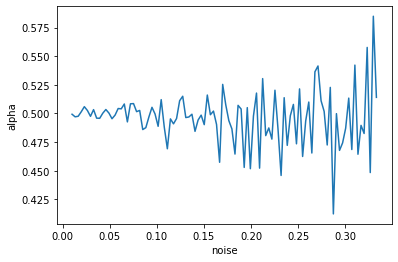

In [49]:
sns.lineplot(data=df, x='noise', y='alpha')

<AxesSubplot:xlabel='noise', ylabel='prior'>

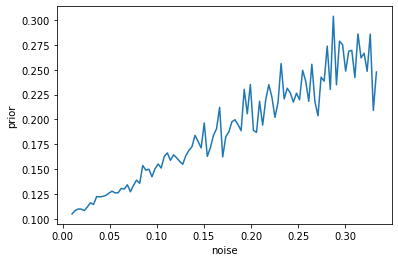

In [50]:
sns.lineplot(data=df, x='noise', y='prior')

### inspect how many trials are needed to still be able to recover parameters

In [20]:
tmp1 = [trials['n_red'].values] * 5
tmp2 = [trials['outcome'].values] * 5
n_red = [item for sublist in tmp1 for item in sublist]
outcome = [item for sublist in tmp2 for item in sublist]

In [21]:
trials = pd.DataFrame({'n_red': n_red, 'outcome': outcome})

In [22]:
trials = trials.sample(frac=1)

In [23]:
trials.reset_index(inplace=True)

In [24]:
del trials['index']

In [21]:
from scripts.analysis import normalize

In [26]:
n_card_per_trial = 7

trials['trial'] = trials.index + 1

trials['n_blue'] = n_card_per_trial - trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1,
                         trials['outcome'] - trials['outcome'] * (trials['n_red'] / n_card_per_trial), \
                         trials['outcome'] - trials['outcome'] * (
                                     n_card_per_trial - trials['n_red']) / n_card_per_trial)
trials['normed_signed_e_v'] = normalize(trials['e_v'])
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

trials['cs_signed_e_v'] = trials['e_v'].cumsum()
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

count_red = abs(trials.outcome[lambda x: x == -1].cumsum())
count_blue = abs(trials.outcome[lambda x: x == 1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

track_freq = [1] * len(trials)
for i, outcome in enumerate(trials['outcome'].values):
    if (i == 0):
        continue
    if (i > 0):
        if (outcome != trials['outcome'].values[i - 1]):
            continue
        if (outcome == trials['outcome'].values[i - 1]):
            track_freq[i] = track_freq[i - 1] + 1
trials['n_consec_colour'] = track_freq

trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']
normalized_signed_colour_count = normalize(trials['signed_n_consec_colour'].values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count
trials['normed_unsigned_colour_count'] = [(v / 5) for v in trials.n_consec_colour]

In [27]:
trials

,n_red,outcome,trial,n_blue,e_v,normed_signed_e_v,normed_unsigned_e_v,cs_signed_e_v,normed_cs_signed_e_v,cs_unsigned_e_v,normed_cs_unsigned_e_v,n_reported_colour_opp,n_consec_colour,signed_n_consec_colour,normed_signed_colour_count,normed_unsigned_colour_count
0,4,1,1,3,0.571429,0.833333,0.714286,0.571429,0.089888,0.571429,0.007590,1,1,1,0.615385,0.2
1,3,-1,2,4,-0.571429,0.166667,0.714286,0.000000,0.067416,1.142857,0.011385,1,1,-1,0.461538,0.2
2,6,-1,3,1,-0.142857,0.416667,0.285714,-0.142857,0.061798,1.285714,0.012334,2,2,-2,0.384615,0.4
3,6,-1,4,1,-0.142857,0.416667,0.285714,-0.285714,0.056180,1.428571,0.013283,3,3,-3,0.307692,0.6
4,4,1,5,3,0.571429,0.833333,0.714286,0.285714,0.078652,2.000000,0.017078,2,1,1,0.615385,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4,1,296,3,0.571429,0.833333,0.714286,23.428571,0.988764,147.428571,0.982922,148,2,2,0.692308,0.4
296,2,1,297,5,0.285714,0.666667,0.428571,23.714286,1.000000,147.714286,0.984820,149,3,3,0.769231,0.6
297,1,-1,298,6,-0.857143,0.000000,1.000000,22.857143,0.966292,148.571429,0.990512,149,1,-1,0.461538,0.2
298,2,-1,299,5,-0.714286,0.083333,0.857143,22.142857,0.938202,149.285714,0.995256,150,2,-2,0.384615,0.4


In [23]:
alpha = 0.1
prior = 0.5
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]

In [29]:
est_n_trials = range(5, 301, 1)

In [30]:
len(est_n_trials)

296

In [31]:
len(sim_data)

300

In [ ]:
## double check length of simulated data

## with noise 0.10

In [25]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.5935668330365915, 'alpha =', 0.005505022834893138)
R2: 9.156432189849628e-05
mean squared error 0.0011364619270955404
SD error 0.03370982049129247
iteration 1 6 6
Best parameter estimates: prior = (0.5965168542861334, 'alpha =', 0.0)
R2: -4.5748394244871093e-05
mean squared error 0.0009477674288868645
SD error 0.0307851274486948
iteration 2 7 7
Best parameter estimates: prior = (0.5686064285748406, 'alpha =', 0.05790905695917242)
R2: 0.1445903231892497
mean squared error 0.0011135184542469128
SD error 0.03336884954543504
iteration 3 8 8
Best parameter estimates: prior = (0.5732108567728956, 'alpha =', 0.05305322016785518)
R2: 0.13373694409547876
mean squared error 0.0009867998030977459
SD error 0.031413316634091505
iteration 4 9 9
Best parameter estimates: prior = (0.5870663791976742, 'alpha =', 0.037508678451750384)
R2: 0.06933906407566692
mean squared error 0.0010290050254076867
SD error 0.03207642026987633
iteration 5 10 10
Best p

Best parameter estimates: prior = (0.5408960753407552, 'alpha =', 0.10837603843322757)
R2: 0.4758291803518069
mean squared error 0.0008962005817431662
SD error 0.029936486794615993
iteration 29 34 34
Best parameter estimates: prior = (0.5429038763294308, 'alpha =', 0.10349050907722117)
R2: 0.47332239276491817
mean squared error 0.0008747996719538334
SD error 0.0295768333492866
iteration 30 35 35
Best parameter estimates: prior = (0.5465146765549661, 'alpha =', 0.09804026954848852)
R2: 0.47737667226876535
mean squared error 0.0008609806881867592
SD error 0.029342467709012155
iteration 31 36 36
Best parameter estimates: prior = (0.5468037798827806, 'alpha =', 0.09821556020503446)
R2: 0.4914716940311116
mean squared error 0.0008394041467167479
SD error 0.028972136418841575
iteration 32 37 37
Best parameter estimates: prior = (0.5462365337316025, 'alpha =', 0.09877599942655191)
R2: 0.485677510670524
mean squared error 0.0008262073605872491
SD error 0.028741469418458086
iteration 33 38 38
B

Best parameter estimates: prior = (0.5499354134552228, 'alpha =', 0.09755932464426079)
R2: 0.5048330431338582
mean squared error 0.0008454050584845584
SD error 0.029075849384540397
iteration 57 62 62
Best parameter estimates: prior = (0.5518285091059902, 'alpha =', 0.09538462974440982)
R2: 0.4938729861061133
mean squared error 0.0008570789124449124
SD error 0.029275684795734617
iteration 58 63 63
Best parameter estimates: prior = (0.5484988171355707, 'alpha =', 0.10083816162868128)
R2: 0.5097429591166095
mean squared error 0.000858277501774094
SD error 0.029296191826575703
iteration 59 64 64
Best parameter estimates: prior = (0.5482235911767318, 'alpha =', 0.10191165031022345)
R2: 0.5224888944659637
mean squared error 0.0008787776415251127
SD error 0.029642192641921115
iteration 60 65 65
Best parameter estimates: prior = (0.5481119349352538, 'alpha =', 0.10228604695681215)
R2: 0.5234300763493789
mean squared error 0.0008673156239385415
SD error 0.02945012464006829
iteration 61 66 66
Be

Best parameter estimates: prior = (0.5466190819744954, 'alpha =', 0.10152135429727649)
R2: 0.5573022690173409
mean squared error 0.0008601128895549544
SD error 0.029323828768287794
iteration 85 90 90
Best parameter estimates: prior = (0.5458485843150036, 'alpha =', 0.10224995584319337)
R2: 0.5633962730064753
mean squared error 0.0008596802193234295
SD error 0.02931953332183849
iteration 86 91 91
Best parameter estimates: prior = (0.5464481578941706, 'alpha =', 0.10243525527504489)
R2: 0.566878633046151
mean squared error 0.0008515579011260789
SD error 0.029175344055365076
iteration 87 92 92
Best parameter estimates: prior = (0.5470011287339428, 'alpha =', 0.10157204588620611)
R2: 0.560712123894234
mean squared error 0.0008544582605103444
SD error 0.02922954319841281
iteration 88 93 93
Best parameter estimates: prior = (0.5464360285212165, 'alpha =', 0.10185100385895998)
R2: 0.5609919727202891
mean squared error 0.0008456139384805737
SD error 0.029079415629105897
iteration 89 94 94
Best

Best parameter estimates: prior = (0.5434147803285783, 'alpha =', 0.10755023389781998)
R2: 0.5897878095108431
mean squared error 0.0008446381568868291
SD error 0.029061391279090253
iteration 113 118 118
Best parameter estimates: prior = (0.5439992782650857, 'alpha =', 0.10733310253896074)
R2: 0.5844773697635015
mean squared error 0.0008484287611105376
SD error 0.029127592978129013
iteration 114 119 119
Best parameter estimates: prior = (0.5440581054861947, 'alpha =', 0.1086157494292207)
R2: 0.5891503522558469
mean squared error 0.0008520598924484985
SD error 0.029188120244375452
iteration 115 120 120
Best parameter estimates: prior = (0.5458903974808781, 'alpha =', 0.10546084170565934)
R2: 0.5838097339649644
mean squared error 0.0008571618272716022
SD error 0.02927687604342761
iteration 116 121 121
Best parameter estimates: prior = (0.5447327386619508, 'alpha =', 0.10642709392104141)
R2: 0.5810020070641144
mean squared error 0.0008572205672094019
SD error 0.029277370311511376
iteration

Best parameter estimates: prior = (0.5463070215079951, 'alpha =', 0.10424230629975002)
R2: 0.591844816818102
mean squared error 0.0008534381492532687
SD error 0.029213256256460325
iteration 141 146 146
Best parameter estimates: prior = (0.5466964340000057, 'alpha =', 0.10390109704106867)
R2: 0.5950208415709493
mean squared error 0.0008477126833548265
SD error 0.029113348231141763
iteration 142 147 147
Best parameter estimates: prior = (0.5455578622016697, 'alpha =', 0.10474618073334026)
R2: 0.5979161501968233
mean squared error 0.000842766223920611
SD error 0.02902933572052766
iteration 143 148 148
Best parameter estimates: prior = (0.5453891339943093, 'alpha =', 0.10538803783770599)
R2: 0.6007854255924321
mean squared error 0.0008496814554421804
SD error 0.02914695954612597
iteration 144 149 149
Best parameter estimates: prior = (0.5454041188776741, 'alpha =', 0.10558371537909518)
R2: 0.6007795629481105
mean squared error 0.0008445261036460802
SD error 0.02905905989975513
iteration 14

Best parameter estimates: prior = (0.5465443126039344, 'alpha =', 0.10476325530163894)
R2: 0.5780217442236042
mean squared error 0.0008818500035793064
SD error 0.02969560719161151
iteration 169 174 174
Best parameter estimates: prior = (0.5472528914131092, 'alpha =', 0.1038729081835178)
R2: 0.5732994284018298
mean squared error 0.0008879125261945059
SD error 0.02979760302250714
iteration 170 175 175
Best parameter estimates: prior = (0.5471410726088484, 'alpha =', 0.10385811315503253)
R2: 0.5718384800791821
mean squared error 0.0008861094626002985
SD error 0.029767255385757193
iteration 171 176 176
Best parameter estimates: prior = (0.5474249662698766, 'alpha =', 0.10344735382929747)
R2: 0.5717094844316427
mean squared error 0.0008822781173638015
SD error 0.029702911360671654
iteration 172 177 177
Best parameter estimates: prior = (0.5476593076062021, 'alpha =', 0.10293735990309215)
R2: 0.5720799425979028
mean squared error 0.0008782602064128994
SD error 0.029635043211875923
iteration 

Best parameter estimates: prior = (0.5486036651766245, 'alpha =', 0.10007750493021682)
R2: 0.5609743227335791
mean squared error 0.0008690104316780784
SD error 0.029478485942679537
iteration 197 202 202
Best parameter estimates: prior = (0.5485805239176588, 'alpha =', 0.10069770108844593)
R2: 0.558956945542554
mean squared error 0.0008688487693822278
SD error 0.02947624007694164
iteration 198 203 203
Best parameter estimates: prior = (0.5494199768332798, 'alpha =', 0.09961289286371663)
R2: 0.5585639811818246
mean squared error 0.0008654469622730296
SD error 0.029417872131895218
iteration 199 204 204
Best parameter estimates: prior = (0.5488301876994818, 'alpha =', 0.09999450990886052)
R2: 0.5557983864076006
mean squared error 0.0008669232653423112
SD error 0.029443547061496565
iteration 200 205 205
Best parameter estimates: prior = (0.549152644042824, 'alpha =', 0.09936173049363299)
R2: 0.5562459060622633
mean squared error 0.0008633068786141738
SD error 0.029382082023356845
iteration 

Best parameter estimates: prior = (0.5475656264985562, 'alpha =', 0.10113460460904647)
R2: 0.5668973104308266
mean squared error 0.0008478956860288638
SD error 0.029117922134738662
iteration 225 230 230
Best parameter estimates: prior = (0.5478772026990657, 'alpha =', 0.10083359531548106)
R2: 0.5666910610228495
mean squared error 0.0008446143706652109
SD error 0.02906224627220084
iteration 226 231 231
Best parameter estimates: prior = (0.5486870299591983, 'alpha =', 0.09987237039580042)
R2: 0.5641079425341358
mean squared error 0.0008461884360152511
SD error 0.029086385046578844
iteration 227 232 232
Best parameter estimates: prior = (0.5490328844235456, 'alpha =', 0.09902310283401908)
R2: 0.5636778015142963
mean squared error 0.0008440665330746259
SD error 0.02905208326209526
iteration 228 233 233
Best parameter estimates: prior = (0.5486687812821708, 'alpha =', 0.10000009030210116)
R2: 0.5655742267307606
mean squared error 0.0008494341245190235
SD error 0.029144469073955435
iteration

Best parameter estimates: prior = (0.5489061389724248, 'alpha =', 0.09882388387538849)
R2: 0.552959186217262
mean squared error 0.0008609244114975075
SD error 0.02934143775290781
iteration 253 258 258
Best parameter estimates: prior = (0.5487907032585538, 'alpha =', 0.09901580843694972)
R2: 0.5535253200401906
mean squared error 0.000857874903209475
SD error 0.02928946832309273
iteration 254 259 259
Best parameter estimates: prior = (0.5481920650001649, 'alpha =', 0.10087769176066996)
R2: 0.556596712230355
mean squared error 0.0008611554831587101
SD error 0.029344624205019366
iteration 255 260 260
Best parameter estimates: prior = (0.5487459162033224, 'alpha =', 0.09993551540694064)
R2: 0.5588436132713009
mean squared error 0.000861016804467055
SD error 0.029342737192894534
iteration 256 261 261
Best parameter estimates: prior = (0.5492177482041422, 'alpha =', 0.09885119901311361)
R2: 0.5572873638759697
mean squared error 0.0008611890917095401
SD error 0.029345872189233783
iteration 257

Best parameter estimates: prior = (0.5503744012190098, 'alpha =', 0.09758946286381089)
R2: 0.5463121262927858
mean squared error 0.0008574896610110218
SD error 0.029282624793733378
iteration 281 286 286
Best parameter estimates: prior = (0.5502289769411556, 'alpha =', 0.09798435113131135)
R2: 0.5422215154193402
mean squared error 0.0008628243248343342
SD error 0.02937294632277471
iteration 282 287 287
Best parameter estimates: prior = (0.5502697540211624, 'alpha =', 0.09828556715931581)
R2: 0.5415639432484132
mean squared error 0.0008617917213916238
SD error 0.02935607867952042
iteration 283 288 288
Best parameter estimates: prior = (0.5515007866033723, 'alpha =', 0.09645185946232036)
R2: 0.5399692101653721
mean squared error 0.0008655656577180443
SD error 0.029420481057500447
iteration 284 289 289
Best parameter estimates: prior = (0.5510813636969611, 'alpha =', 0.09750915205420022)
R2: 0.5404203192631531
mean squared error 0.0008658818992128154
SD error 0.029425866728684195
iteration

In [26]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

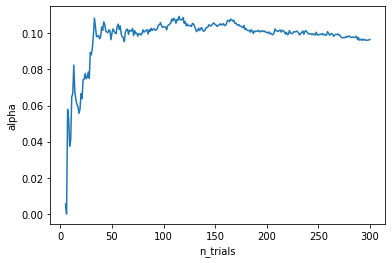

In [27]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

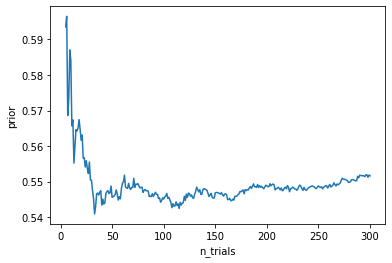

In [28]:
sns.lineplot(data=df, x='n_trials', y='prior')

### with different prior

In [24]:
alpha = 0.1
prior = 0.3
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]

In [30]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.39925810634302, 'alpha =', 0.0)
R2: -0.0004889426239211847
mean squared error 8.326078357970768e-05
SD error 0.009122504794666702
iteration 1 6 6
Best parameter estimates: prior = (0.3659226073657613, 'alpha =', 0.08091968294882715)
R2: 0.4421996836247628
mean squared error 0.0003747414227905335
SD error 0.019294869050137137
iteration 2 7 7
Best parameter estimates: prior = (0.34503448747564597, 'alpha =', 0.11698764607506965)
R2: 0.6588243098691678
mean squared error 0.0003933657568662689
SD error 0.01978424549088889
iteration 3 8 8
Best parameter estimates: prior = (0.3543768513246933, 'alpha =', 0.1079901467796613)
R2: 0.6321048653036011
mean squared error 0.00037319273344792625
SD error 0.019316351856384674
iteration 4 9 9
Best parameter estimates: prior = (0.35420791213707636, 'alpha =', 0.10822986223811297)
R2: 0.649507914597554
mean squared error 0.0003319336353294176
SD error 0.018215302496527138
iteration 5 10 10
Best parame

Best parameter estimates: prior = (0.3393963456841212, 'alpha =', 0.12972236778436402)
R2: 0.6651775954720812
mean squared error 0.0006372937065778001
SD error 0.025241869803361024
iteration 29 34 34
Best parameter estimates: prior = (0.3392146940667452, 'alpha =', 0.12985786233443747)
R2: 0.6695378043759097
mean squared error 0.0006185340803729465
SD error 0.02486937903786223
iteration 30 35 35
Best parameter estimates: prior = (0.340186182573675, 'alpha =', 0.12867695724417552)
R2: 0.6838256084754654
mean squared error 0.0006047731849449302
SD error 0.024591194843263612
iteration 31 36 36
Best parameter estimates: prior = (0.3436178045373141, 'alpha =', 0.1226185613499126)
R2: 0.6730667443537395
mean squared error 0.0006175603524478727
SD error 0.024846850664535566
iteration 32 37 37
Best parameter estimates: prior = (0.3445849197160429, 'alpha =', 0.11955980160420322)
R2: 0.6456301769311089
mean squared error 0.0006589102003103139
SD error 0.02566829768004721
iteration 33 38 38
Best

Best parameter estimates: prior = (0.3460509389343608, 'alpha =', 0.10709076811353438)
R2: 0.6257322653159859
mean squared error 0.0006304303107368483
SD error 0.025108360010809697
iteration 57 62 62
Best parameter estimates: prior = (0.34505028182517933, 'alpha =', 0.10805563969203379)
R2: 0.6246606541004559
mean squared error 0.0006299700796100789
SD error 0.025099103723289412
iteration 58 63 63
Best parameter estimates: prior = (0.34267466872394164, 'alpha =', 0.11123464870870653)
R2: 0.6367094318395414
mean squared error 0.0006400259707260287
SD error 0.02529771701183017
iteration 59 64 64
Best parameter estimates: prior = (0.3434222504857452, 'alpha =', 0.10867204129382627)
R2: 0.6216867946864062
mean squared error 0.0006561126948311266
SD error 0.025614168762348972
iteration 60 65 65
Best parameter estimates: prior = (0.34393228377483287, 'alpha =', 0.10886818408202621)
R2: 0.6172911351937374
mean squared error 0.0006543288086286312
SD error 0.025579699503403722
iteration 61 66 6

Best parameter estimates: prior = (0.34401330778822825, 'alpha =', 0.10488395386162477)
R2: 0.63216155396892
mean squared error 0.0006773958693769251
SD error 0.026023962240592974
iteration 85 90 90
Best parameter estimates: prior = (0.3440567911835834, 'alpha =', 0.10313732312041093)
R2: 0.6205959770878022
mean squared error 0.0006911026750215243
SD error 0.02628876938473783
iteration 86 91 91
Best parameter estimates: prior = (0.3441612788030272, 'alpha =', 0.10305054384739708)
R2: 0.6204422374583911
mean squared error 0.0006853062337424349
SD error 0.026177971165643136
iteration 87 92 92
Best parameter estimates: prior = (0.34322386152541134, 'alpha =', 0.10384101077342765)
R2: 0.62564917047619
mean squared error 0.0006931104489458696
SD error 0.026325983598545703
iteration 88 93 93
Best parameter estimates: prior = (0.3429390280167285, 'alpha =', 0.1050726638578406)
R2: 0.6231378140411028
mean squared error 0.0006902574287784894
SD error 0.02626987434452078
iteration 89 94 94
Best 

Best parameter estimates: prior = (0.3442282207538055, 'alpha =', 0.10147940057647734)
R2: 0.5961100105140482
mean squared error 0.0007421023461337431
SD error 0.02724010949828807
iteration 113 118 118
Best parameter estimates: prior = (0.34361748891411287, 'alpha =', 0.10265624415639994)
R2: 0.5984694500774105
mean squared error 0.0007437952606405763
SD error 0.027272610026849314
iteration 114 119 119
Best parameter estimates: prior = (0.3435853565996837, 'alpha =', 0.1033648166667432)
R2: 0.6025194451331859
mean squared error 0.0007386875255888273
SD error 0.027177631442296697
iteration 115 120 120
Best parameter estimates: prior = (0.3419150517397452, 'alpha =', 0.10580029624750333)
R2: 0.6110187860942771
mean squared error 0.0007382857897846551
SD error 0.027171244868200068
iteration 116 121 121
Best parameter estimates: prior = (0.3423337215743478, 'alpha =', 0.10586106260098317)
R2: 0.6173557607641693
mean squared error 0.0007362355345943618
SD error 0.027131182462659827
iteratio

Best parameter estimates: prior = (0.3429660887417583, 'alpha =', 0.10718476475547715)
R2: 0.6330289296755941
mean squared error 0.0007453230182151515
SD error 0.027300373315503775
iteration 140 145 145
Best parameter estimates: prior = (0.3436866884309228, 'alpha =', 0.10626553622290918)
R2: 0.6362921007885083
mean squared error 0.0007432164103638152
SD error 0.02726127891349372
iteration 141 146 146
Best parameter estimates: prior = (0.342876328234038, 'alpha =', 0.10695887788026825)
R2: 0.638534832896099
mean squared error 0.0007383258527128236
SD error 0.027171400237322924
iteration 142 147 147
Best parameter estimates: prior = (0.34371107292558883, 'alpha =', 0.10660382607733838)
R2: 0.6387509455306313
mean squared error 0.00073455735123771
SD error 0.027100435346238225
iteration 143 148 148
Best parameter estimates: prior = (0.3435731164727123, 'alpha =', 0.10576589618284138)
R2: 0.6411804876513555
mean squared error 0.0007298040695117265
SD error 0.027013502629812138
iteration 1

Best parameter estimates: prior = (0.3443197182775056, 'alpha =', 0.10644624807005333)
R2: 0.6196745295993966
mean squared error 0.0007659913035644346
SD error 0.027676485379217037
iteration 167 172 172
Best parameter estimates: prior = (0.3448351713408968, 'alpha =', 0.10597179396759851)
R2: 0.6158580899319629
mean squared error 0.0007692733236598062
SD error 0.027735568531316816
iteration 168 173 173
Best parameter estimates: prior = (0.3451244642936203, 'alpha =', 0.10483078541396446)
R2: 0.6105172770190239
mean squared error 0.0007766011528635864
SD error 0.027867518314333106
iteration 169 174 174
Best parameter estimates: prior = (0.34469793947716443, 'alpha =', 0.10559775239043727)
R2: 0.610752703204912
mean squared error 0.0007777166688049435
SD error 0.02788676866802672
iteration 170 175 175
Best parameter estimates: prior = (0.3445878382583083, 'alpha =', 0.10566419612004836)
R2: 0.6104769987961391
mean squared error 0.0007738556465864372
SD error 0.027817578833785862
iteratio

Best parameter estimates: prior = (0.3447036444927164, 'alpha =', 0.1053306146194739)
R2: 0.6022180042798684
mean squared error 0.0008147628810829398
SD error 0.028542565751640023
iteration 194 199 199
Best parameter estimates: prior = (0.34441071835415094, 'alpha =', 0.10569070035913497)
R2: 0.6003152078175015
mean squared error 0.000821670876419784
SD error 0.02866438589927525
iteration 195 200 200
Best parameter estimates: prior = (0.3442492175451269, 'alpha =', 0.10662589321639565)
R2: 0.6040817603296522
mean squared error 0.0008268194203270235
SD error 0.028754450426673062
iteration 196 201 201
Best parameter estimates: prior = (0.34405702015522316, 'alpha =', 0.10750215837165045)
R2: 0.6058580132374478
mean squared error 0.0008228586223115175
SD error 0.02868424509507593
iteration 197 202 202
Best parameter estimates: prior = (0.34383668002589074, 'alpha =', 0.10748135262305278)
R2: 0.6060618214423228
mean squared error 0.0008242898032697215
SD error 0.028709722004764397
iteratio

Best parameter estimates: prior = (0.34422680004367456, 'alpha =', 0.1076352998133706)
R2: 0.6105311491950863
mean squared error 0.0008113672031841375
SD error 0.028484450937191298
iteration 221 226 226
Best parameter estimates: prior = (0.3444008685064777, 'alpha =', 0.1070318280674457)
R2: 0.6050300800131252
mean squared error 0.0008191957499398251
SD error 0.028621319786882288
iteration 222 227 227
Best parameter estimates: prior = (0.34446009369272784, 'alpha =', 0.1065490014964985)
R2: 0.604492709710855
mean squared error 0.0008169652958039444
SD error 0.028582604734814818
iteration 223 228 228
Best parameter estimates: prior = (0.34498587695122024, 'alpha =', 0.10672323526460313)
R2: 0.6045035524010103
mean squared error 0.000813883096366022
SD error 0.02852243288152125
iteration 224 229 229
Best parameter estimates: prior = (0.344422233313382, 'alpha =', 0.10602920754630579)
R2: 0.6026378795980305
mean squared error 0.0008141522630562578
SD error 0.028532537768965145
iteration 2

Best parameter estimates: prior = (0.34488948602328534, 'alpha =', 0.10711844516647775)
R2: 0.6030950199926968
mean squared error 0.0008220075871395173
SD error 0.0286694555014692
iteration 249 254 254
Best parameter estimates: prior = (0.3448292575748184, 'alpha =', 0.10692209806566834)
R2: 0.6007708771069429
mean squared error 0.0008236080209035416
SD error 0.028698540230505276
iteration 250 255 255
Best parameter estimates: prior = (0.3455410140843103, 'alpha =', 0.10627907126219492)
R2: 0.6005451294852453
mean squared error 0.0008271187267595158
SD error 0.028759251264996424
iteration 251 256 256
Best parameter estimates: prior = (0.34502399559982677, 'alpha =', 0.1067486612453325)
R2: 0.6008836115079208
mean squared error 0.000827801792589329
SD error 0.0287715384983044
iteration 252 257 257
Best parameter estimates: prior = (0.34564055899092533, 'alpha =', 0.10621632766960244)
R2: 0.6001274839926807
mean squared error 0.000826201490413047
SD error 0.028742465244101345
iteration 2

Best parameter estimates: prior = (0.34467425563985504, 'alpha =', 0.10711047252406924)
R2: 0.6033880401060685
mean squared error 0.0008215791865019836
SD error 0.028662300996746496
iteration 276 281 281
Best parameter estimates: prior = (0.34503485754338087, 'alpha =', 0.10733957972666934)
R2: 0.6027872820964337
mean squared error 0.0008199309572125958
SD error 0.02863379979112452
iteration 277 282 282
Best parameter estimates: prior = (0.34492170666918454, 'alpha =', 0.10677514500660687)
R2: 0.6024691244736777
mean squared error 0.0008206708447583662
SD error 0.028647118736894607
iteration 278 283 283
Best parameter estimates: prior = (0.34469152251491136, 'alpha =', 0.10733428514907277)
R2: 0.6027622654065969
mean squared error 0.0008213618973561723
SD error 0.028659321567912763
iteration 279 284 284
Best parameter estimates: prior = (0.3446441753644424, 'alpha =', 0.10738428079781615)
R2: 0.6037344116499599
mean squared error 0.0008216592798403283
SD error 0.028664548393392223
iter

In [31]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

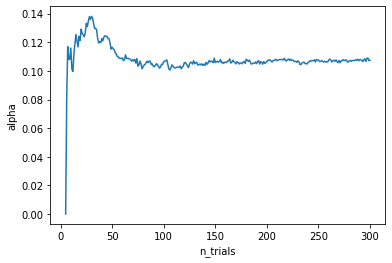

In [32]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

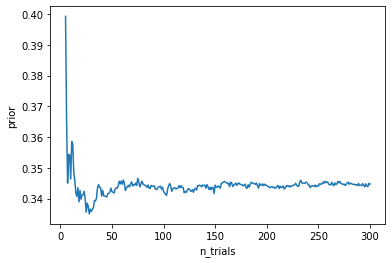

In [33]:
sns.lineplot(data=df, x='n_trials', y='prior')

In [32]:
alpha = 0.8
prior = 0.333
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]

In [33]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.33877484364625754, 'alpha =', 0.8655947240334877)
R2: 0.9890357680483634
mean squared error 0.0005674699518102253
SD error 0.023821547151465262
iteration 1 6 6
Best parameter estimates: prior = (0.34619211890512297, 'alpha =', 0.8571858760942576)
R2: 0.9888638004217142
mean squared error 0.0005171779595764267
SD error 0.022741527175873896
iteration 2 7 7
Best parameter estimates: prior = (0.36147020702633925, 'alpha =', 0.832603215674629)
R2: 0.9909767847042562
mean squared error 0.0005315284178935377
SD error 0.023054875377202685
iteration 3 8 8
Best parameter estimates: prior = (0.36811448126157037, 'alpha =', 0.8273861109579737)
R2: 0.9881549285745841
mean squared error 0.0006128545307419113
SD error 0.024755195225395984
iteration 4 9 9
Best parameter estimates: prior = (0.3680372441745928, 'alpha =', 0.8282060474980804)
R2: 0.9886251953917056
mean squared error 0.0005451370847276294
SD error 0.023347776719463444
iteration 5 10 10

Best parameter estimates: prior = (0.3745273511950022, 'alpha =', 0.8138646709163383)
R2: 0.9883062992781486
mean squared error 0.0007228144647908382
SD error 0.026883205609260143
iteration 29 34 34
Best parameter estimates: prior = (0.3745692216281963, 'alpha =', 0.8137784931317815)
R2: 0.9886328285095308
mean squared error 0.0007041601158890027
SD error 0.02653596750603946
iteration 30 35 35
Best parameter estimates: prior = (0.37478251571693133, 'alpha =', 0.8137310692107167)
R2: 0.9889809697535386
mean squared error 0.0006854540571386275
SD error 0.02618108567206686
iteration 31 36 36
Best parameter estimates: prior = (0.3804498440252148, 'alpha =', 0.8065435210836773)
R2: 0.9887720426260453
mean squared error 0.0007217708482858317
SD error 0.026865711925139424
iteration 32 37 37
Best parameter estimates: prior = (0.38080102854081604, 'alpha =', 0.8066897111068383)
R2: 0.9886945246626421
mean squared error 0.0007113620505753819
SD error 0.026671371366511182
iteration 33 38 38
Best 

Best parameter estimates: prior = (0.37708088007377855, 'alpha =', 0.8090437363682379)
R2: 0.989798538081077
mean squared error 0.0007948585517121278
SD error 0.028189829307572595
iteration 57 62 62
Best parameter estimates: prior = (0.37629531055068444, 'alpha =', 0.8118838845693341)
R2: 0.9896959483766655
mean squared error 0.000791578368496036
SD error 0.0281338431449355
iteration 58 63 63
Best parameter estimates: prior = (0.37662575654801744, 'alpha =', 0.8118640186044925)
R2: 0.9899504525050282
mean squared error 0.000779355666014835
SD error 0.027916937937914544
iteration 59 64 64
Best parameter estimates: prior = (0.3764284901242531, 'alpha =', 0.8129218968593975)
R2: 0.9898445676702942
mean squared error 0.0007796822021548787
SD error 0.027922468840390482
iteration 60 65 65
Best parameter estimates: prior = (0.3764849965720245, 'alpha =', 0.8132250356935292)
R2: 0.9899881189669586
mean squared error 0.000768911809466537
SD error 0.02772918298325032
iteration 61 66 66
Best para

Best parameter estimates: prior = (0.3797398449003376, 'alpha =', 0.8087330391186844)
R2: 0.9906430519682811
mean squared error 0.0007286998223684178
SD error 0.026994435704658048
iteration 85 90 90
Best parameter estimates: prior = (0.37933254745937267, 'alpha =', 0.8084425837956317)
R2: 0.9906336091061411
mean squared error 0.0007255441509108257
SD error 0.026925070532950224
iteration 86 91 91
Best parameter estimates: prior = (0.3796083773796614, 'alpha =', 0.809069436923348)
R2: 0.9906369709527967
mean squared error 0.000718339400164466
SD error 0.0268018316961099
iteration 87 92 92
Best parameter estimates: prior = (0.3794456431642738, 'alpha =', 0.8091887040932505)
R2: 0.9905816736266558
mean squared error 0.0007151849900148268
SD error 0.02674054718106653
iteration 88 93 93
Best parameter estimates: prior = (0.37926041369586844, 'alpha =', 0.8089790049108347)
R2: 0.9902639352040039
mean squared error 0.0007313631832545517
SD error 0.027043348586017864
iteration 89 94 94
Best par

Best parameter estimates: prior = (0.38018665117636585, 'alpha =', 0.8082401861253927)
R2: 0.9888604120607003
mean squared error 0.0007754078907091465
SD error 0.0278458765020659
iteration 113 118 118
Best parameter estimates: prior = (0.3794268406934121, 'alpha =', 0.8089246882082696)
R2: 0.9887900656811405
mean squared error 0.0007850140233824956
SD error 0.028017911497434687
iteration 114 119 119
Best parameter estimates: prior = (0.3797096810326316, 'alpha =', 0.8084631816219631)
R2: 0.9887781424386699
mean squared error 0.0007799164812127523
SD error 0.027926974091102445
iteration 115 120 120
Best parameter estimates: prior = (0.3796398467976995, 'alpha =', 0.8083848894596062)
R2: 0.988779044119601
mean squared error 0.0007735062551182534
SD error 0.027811752571612017
iteration 116 121 121
Best parameter estimates: prior = (0.3779388021767054, 'alpha =', 0.8115250546794072)
R2: 0.9886718629179426
mean squared error 0.0007856338663907562
SD error 0.028027986739999625
iteration 117 

Best parameter estimates: prior = (0.38035358815696857, 'alpha =', 0.809997751540595)
R2: 0.9889993156788743
mean squared error 0.0007634354934465498
SD error 0.02762813683399057
iteration 141 146 146
Best parameter estimates: prior = (0.37819575667620037, 'alpha =', 0.812965826782866)
R2: 0.9887884057744222
mean squared error 0.0007764603669443588
SD error 0.027859601778146635
iteration 142 147 147
Best parameter estimates: prior = (0.38027830525831247, 'alpha =', 0.80984652372571)
R2: 0.9888081721225922
mean squared error 0.0007706823984961421
SD error 0.02776047610460189
iteration 143 148 148
Best parameter estimates: prior = (0.37874508772534266, 'alpha =', 0.8121725726258251)
R2: 0.9890043183799461
mean squared error 0.0007674641402410537
SD error 0.02770084057668645
iteration 144 149 149
Best parameter estimates: prior = (0.380433574925413, 'alpha =', 0.8103956331490235)
R2: 0.9888645474439998
mean squared error 0.0007724228636365955
SD error 0.027792273731936143
iteration 145 15

Best parameter estimates: prior = (0.37882526666884814, 'alpha =', 0.8112061386949886)
R2: 0.9879332476608921
mean squared error 0.0008387090880213921
SD error 0.028960369877551292
iteration 169 174 174
Best parameter estimates: prior = (0.3782908129937838, 'alpha =', 0.812185335626432)
R2: 0.9879919970805812
mean squared error 0.0008414366772640129
SD error 0.029007203002218714
iteration 170 175 175
Best parameter estimates: prior = (0.37871137480954065, 'alpha =', 0.8116979847248503)
R2: 0.9879320914980155
mean squared error 0.0008411629005234372
SD error 0.02900246497321072
iteration 171 176 176
Best parameter estimates: prior = (0.379323754294901, 'alpha =', 0.8097804907615408)
R2: 0.9879259155774593
mean squared error 0.0008374165815604736
SD error 0.028932000501203887
iteration 172 177 177
Best parameter estimates: prior = (0.37832506227937646, 'alpha =', 0.8122497543330581)
R2: 0.9878994968098453
mean squared error 0.0008371752291096231
SD error 0.028933841941800483
iteration 17

Best parameter estimates: prior = (0.37880477963314807, 'alpha =', 0.8106931101126422)
R2: 0.9886106120372568
mean squared error 0.0008016046284391288
SD error 0.028312596193052018
iteration 197 202 202
Best parameter estimates: prior = (0.3785231200391628, 'alpha =', 0.8107984466103066)
R2: 0.988680167678377
mean squared error 0.000798067034953555
SD error 0.02824921999597153
iteration 198 203 203
Best parameter estimates: prior = (0.37870157112890984, 'alpha =', 0.8109195175134898)
R2: 0.9886975085147801
mean squared error 0.0007942783595019747
SD error 0.028182943253780627
iteration 199 204 204
Best parameter estimates: prior = (0.37746731449876353, 'alpha =', 0.8120524880802186)
R2: 0.9885364629341185
mean squared error 0.0008018514144105005
SD error 0.028314100805046403
iteration 200 205 205
Best parameter estimates: prior = (0.3797024840700767, 'alpha =', 0.8080190283107755)
R2: 0.9883831432958
mean squared error 0.0008087470681153219
SD error 0.02843324483654778
iteration 201 20

Best parameter estimates: prior = (0.3802149054939923, 'alpha =', 0.8067192673803485)
R2: 0.9884359191317699
mean squared error 0.0008095629533021453
SD error 0.028452703418565824
iteration 225 230 230
Best parameter estimates: prior = (0.37936287779418804, 'alpha =', 0.8081543850744227)
R2: 0.9885074183234276
mean squared error 0.0008091575864843403
SD error 0.028444335143391238
iteration 226 231 231
Best parameter estimates: prior = (0.3800774517884806, 'alpha =', 0.8063555769008702)
R2: 0.9885377999026328
mean squared error 0.0008075959622374922
SD error 0.02841501681205985
iteration 227 232 232
Best parameter estimates: prior = (0.380192124484185, 'alpha =', 0.8066856995197829)
R2: 0.9884754295109792
mean squared error 0.0008086838071723828
SD error 0.02843600578745381
iteration 228 233 233
Best parameter estimates: prior = (0.38088654224354246, 'alpha =', 0.8056815467056435)
R2: 0.9884753389689672
mean squared error 0.00080732370163252
SD error 0.028412613524840938
iteration 229 2

Best parameter estimates: prior = (0.3799214380504084, 'alpha =', 0.8057254663093879)
R2: 0.9882329815115444
mean squared error 0.0008102985659284222
SD error 0.028461841163646445
iteration 253 258 258
Best parameter estimates: prior = (0.3807479188923734, 'alpha =', 0.8048942787100346)
R2: 0.9882244855825731
mean squared error 0.0008084176351587235
SD error 0.028432179237130418
iteration 254 259 259
Best parameter estimates: prior = (0.3808266261545937, 'alpha =', 0.8049817233248006)
R2: 0.9882024535951709
mean squared error 0.0008070770494132435
SD error 0.028408816413135626
iteration 255 260 260
Best parameter estimates: prior = (0.38086776962089935, 'alpha =', 0.8049847465996802)
R2: 0.9882926428466748
mean squared error 0.0008039653058427061
SD error 0.028354163922685853
iteration 256 261 261
Best parameter estimates: prior = (0.3804259402856869, 'alpha =', 0.8053014636492125)
R2: 0.9882331205217186
mean squared error 0.0008057883480121717
SD error 0.028385592964249768
iteration 2

Best parameter estimates: prior = (0.379322187091204, 'alpha =', 0.8086088141058698)
R2: 0.988292907861104
mean squared error 0.0008141475830098328
SD error 0.028533083872390366
iteration 281 286 286
Best parameter estimates: prior = (0.37990818776964214, 'alpha =', 0.8079129194428353)
R2: 0.9883198144163116
mean squared error 0.0008114814287711403
SD error 0.028486217712414535
iteration 282 287 287
Best parameter estimates: prior = (0.37998640818951057, 'alpha =', 0.8077830033261377)
R2: 0.9882485791365353
mean squared error 0.0008137690078810384
SD error 0.028526636662662152
iteration 283 288 288
Best parameter estimates: prior = (0.3801707581185729, 'alpha =', 0.8070919818618187)
R2: 0.9881393880475456
mean squared error 0.0008209405382043335
SD error 0.028652059602224805
iteration 284 289 289
Best parameter estimates: prior = (0.3798998732840145, 'alpha =', 0.8072462654006571)
R2: 0.9882539123863948
mean squared error 0.0008185107300259685
SD error 0.028609211490229682
iteration 28

In [34]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

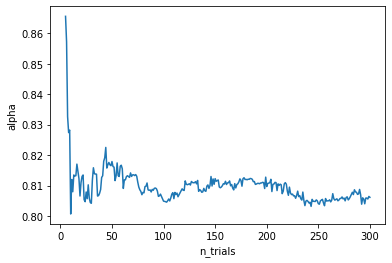

In [35]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

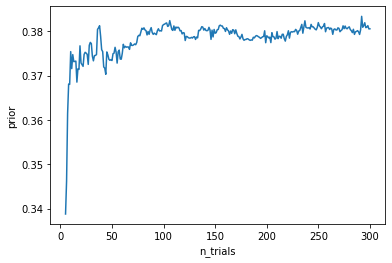

In [36]:
sns.lineplot(data=df, x='n_trials', y='prior')

In [39]:
alpha = 0.8
prior = 0.5
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]

In [40]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.5499365160263775, 'alpha =', 0.7998846652202176)
R2: 0.991590582655836
mean squared error 0.00010543062317154739
SD error 0.010266926749406262
iteration 1 6 6
Best parameter estimates: prior = (0.5487163672121622, 'alpha =', 0.8025660346501646)
R2: 0.9966186814803747
mean squared error 8.81226765256958e-05
SD error 0.009385791905683186
iteration 2 7 7
Best parameter estimates: prior = (0.5469035324433591, 'alpha =', 0.8063918346262466)
R2: 0.9979441764880785
mean squared error 7.667861562324762e-05
SD error 0.0087555203909743
iteration 3 8 8
Best parameter estimates: prior = (0.5654180654506786, 'alpha =', 0.7867376319699767)
R2: 0.9921840860623768
mean squared error 0.0002690394846328007
SD error 0.016379112266653832
iteration 4 9 9
Best parameter estimates: prior = (0.5696024561507742, 'alpha =', 0.781152549557644)
R2: 0.9917153775415443
mean squared error 0.0002672977803456128
SD error 0.01634851264800352
iteration 5 10 10
Best pa

Best parameter estimates: prior = (0.5455036096178036, 'alpha =', 0.8020167128150719)
R2: 0.9864957236775346
mean squared error 0.000659638835923403
SD error 0.025680099773208225
iteration 29 34 34
Best parameter estimates: prior = (0.5433599782099805, 'alpha =', 0.8062028971954555)
R2: 0.9860665107144823
mean squared error 0.000677534782328378
SD error 0.026024314176644994
iteration 30 35 35
Best parameter estimates: prior = (0.5475495878914717, 'alpha =', 0.8003938071467682)
R2: 0.98708376097922
mean squared error 0.0006716548591691926
SD error 0.025916123601367125
iteration 31 36 36
Best parameter estimates: prior = (0.5495605123342084, 'alpha =', 0.7976752567621094)
R2: 0.988052155271178
mean squared error 0.0006579715717662624
SD error 0.025650667996759337
iteration 32 37 37
Best parameter estimates: prior = (0.5490276855012147, 'alpha =', 0.7955866709979416)
R2: 0.9870376128076623
mean squared error 0.0006964918661049857
SD error 0.026390045840171666
iteration 33 38 38
Best param

Best parameter estimates: prior = (0.5492620325750389, 'alpha =', 0.7942940025339394)
R2: 0.9877537239202917
mean squared error 0.0007147505309017153
SD error 0.026734724914612002
iteration 57 62 62
Best parameter estimates: prior = (0.5497120246288297, 'alpha =', 0.7940367738867167)
R2: 0.9876890120291282
mean squared error 0.0007078852858279407
SD error 0.026606093446593766
iteration 58 63 63
Best parameter estimates: prior = (0.5503512368790996, 'alpha =', 0.7931312060454815)
R2: 0.9880492138713008
mean squared error 0.0006979336746927342
SD error 0.026418432174672345
iteration 59 64 64
Best parameter estimates: prior = (0.5497706296873461, 'alpha =', 0.7950539778188901)
R2: 0.9882742729499047
mean squared error 0.0006949020581016889
SD error 0.026360931698646013
iteration 60 65 65
Best parameter estimates: prior = (0.5497911270532975, 'alpha =', 0.794640599562712)
R2: 0.9882943125582039
mean squared error 0.0006842644999744506
SD error 0.02615792357154201
iteration 61 66 66
Best pa

Best parameter estimates: prior = (0.5464812477636098, 'alpha =', 0.8047745068832425)
R2: 0.989150243965521
mean squared error 0.0007445161254233184
SD error 0.0272858087623608
iteration 85 90 90
Best parameter estimates: prior = (0.5469097123947038, 'alpha =', 0.8029918226257275)
R2: 0.9889270218041438
mean squared error 0.0007586694502480018
SD error 0.027543801231738763
iteration 86 91 91
Best parameter estimates: prior = (0.5463663319260865, 'alpha =', 0.8037322830817538)
R2: 0.9889562449243134
mean squared error 0.000757410459435737
SD error 0.027521028680742653
iteration 87 92 92
Best parameter estimates: prior = (0.5448840389190626, 'alpha =', 0.8054754687767117)
R2: 0.9889401649856597
mean squared error 0.0007650222320712983
SD error 0.027659006602114566
iteration 88 93 93
Best parameter estimates: prior = (0.5447535653198098, 'alpha =', 0.8062629446285814)
R2: 0.9889012033948822
mean squared error 0.00076346215588413
SD error 0.027630818837825758
iteration 89 94 94
Best parame

Best parameter estimates: prior = (0.544348708157654, 'alpha =', 0.808950778458392)
R2: 0.988744712555775
mean squared error 0.000781822786369511
SD error 0.027961084769237664
iteration 113 118 118
Best parameter estimates: prior = (0.5435467374866433, 'alpha =', 0.8094882103541455)
R2: 0.9887447224615492
mean squared error 0.0007815101022200361
SD error 0.02795428460884769
iteration 114 119 119
Best parameter estimates: prior = (0.5426488393434159, 'alpha =', 0.8105495470835594)
R2: 0.9886527953921749
mean squared error 0.0007882204792127436
SD error 0.028074070329533646
iteration 115 120 120
Best parameter estimates: prior = (0.5442996149996788, 'alpha =', 0.807875309486261)
R2: 0.9888862275239584
mean squared error 0.0007819958895766808
SD error 0.0279638872792463
iteration 116 121 121
Best parameter estimates: prior = (0.5438412702811846, 'alpha =', 0.80888912262277)
R2: 0.9890316480956594
mean squared error 0.0007798519084791921
SD error 0.027924836954118376
iteration 117 122 122


Best parameter estimates: prior = (0.545489722506458, 'alpha =', 0.8058923102565202)
R2: 0.9898407265622421
mean squared error 0.0007591393737563663
SD error 0.027552370755863417
iteration 141 146 146
Best parameter estimates: prior = (0.5452550188361673, 'alpha =', 0.8067454008541869)
R2: 0.9899053596162187
mean squared error 0.0007604769781954804
SD error 0.027576663006106703
iteration 142 147 147
Best parameter estimates: prior = (0.5453353784783279, 'alpha =', 0.8068082683764473)
R2: 0.989984791476839
mean squared error 0.0007557557709779512
SD error 0.027490826389535292
iteration 143 148 148
Best parameter estimates: prior = (0.5453417386402418, 'alpha =', 0.8062249154014515)
R2: 0.9899441913177921
mean squared error 0.0007587201625491268
SD error 0.027544859742112487
iteration 144 149 149
Best parameter estimates: prior = (0.545547593976639, 'alpha =', 0.8060740831910482)
R2: 0.9898650235440226
mean squared error 0.0007598679308340923
SD error 0.027565654399100113
iteration 145 1

Best parameter estimates: prior = (0.546591159431496, 'alpha =', 0.8064870189044678)
R2: 0.988854139276034
mean squared error 0.0008122198009190158
SD error 0.028499469312135293
iteration 169 174 174
Best parameter estimates: prior = (0.5464708548674869, 'alpha =', 0.8064079213296572)
R2: 0.9888695072356577
mean squared error 0.0008083602134942725
SD error 0.028431494972890384
iteration 170 175 175
Best parameter estimates: prior = (0.5464859171065728, 'alpha =', 0.8065826472966896)
R2: 0.9887994385867663
mean squared error 0.0008100670838363127
SD error 0.02846108557469648
iteration 171 176 176
Best parameter estimates: prior = (0.5461121705982512, 'alpha =', 0.8067329298279527)
R2: 0.9887878411185665
mean squared error 0.0008063497417134679
SD error 0.028393312275501705
iteration 172 177 177
Best parameter estimates: prior = (0.5461514214386786, 'alpha =', 0.8072446130082608)
R2: 0.9887718322447879
mean squared error 0.0008105976164511466
SD error 0.02846916302013308
iteration 173 17

Best parameter estimates: prior = (0.5493282578749616, 'alpha =', 0.8026949101192488)
R2: 0.9887730456100068
mean squared error 0.0008044208409690435
SD error 0.028362023026894247
iteration 197 202 202
Best parameter estimates: prior = (0.5488648304097081, 'alpha =', 0.8033512633029567)
R2: 0.9886365056960567
mean squared error 0.0008126970663863477
SD error 0.02850784150313677
iteration 198 203 203
Best parameter estimates: prior = (0.5516269680677153, 'alpha =', 0.7978040011726585)
R2: 0.9886141372327294
mean squared error 0.000811759264572769
SD error 0.028490767872127794
iteration 199 204 204
Best parameter estimates: prior = (0.5487558212592694, 'alpha =', 0.8034111974139058)
R2: 0.9887660966598919
mean squared error 0.0008049747699400876
SD error 0.028371899229312283
iteration 200 205 205
Best parameter estimates: prior = (0.5489002412271694, 'alpha =', 0.8032882809243166)
R2: 0.988838082112153
mean squared error 0.0008010661399757233
SD error 0.02830309118414064
iteration 201 20

Best parameter estimates: prior = (0.5494938859240974, 'alpha =', 0.8023237853891918)
R2: 0.9888130987219939
mean squared error 0.0007998091469871259
SD error 0.02828054137801085
iteration 225 230 230
Best parameter estimates: prior = (0.5488388455377187, 'alpha =', 0.8031343093730107)
R2: 0.9887619708397588
mean squared error 0.0008001654408707115
SD error 0.028286340090337866
iteration 226 231 231
Best parameter estimates: prior = (0.5486501706579512, 'alpha =', 0.8037084411606997)
R2: 0.9888185011011412
mean squared error 0.0007999551610171925
SD error 0.028282693567944
iteration 227 232 232
Best parameter estimates: prior = (0.5487189638317035, 'alpha =', 0.8037450524594575)
R2: 0.988863615619499
mean squared error 0.0007985860900335933
SD error 0.028259253745769368
iteration 228 233 233
Best parameter estimates: prior = (0.5485591906220031, 'alpha =', 0.8043413589923987)
R2: 0.988901759198294
mean squared error 0.0007971526381111749
SD error 0.028233846226536793
iteration 229 234 

Best parameter estimates: prior = (0.548150671402001, 'alpha =', 0.8043775272851339)
R2: 0.9887428828609174
mean squared error 0.0008022837129480076
SD error 0.028324588936384124
iteration 253 258 258
Best parameter estimates: prior = (0.5473414813554571, 'alpha =', 0.8049798447922709)
R2: 0.9887438268405698
mean squared error 0.000803923912798632
SD error 0.028346162160897716
iteration 254 259 259
Best parameter estimates: prior = (0.5480752993689391, 'alpha =', 0.8048602568756431)
R2: 0.9888280135265974
mean squared error 0.0008009562086813732
SD error 0.02830115840578215
iteration 255 260 260
Best parameter estimates: prior = (0.5480001293136939, 'alpha =', 0.8053821591468635)
R2: 0.9888649397077336
mean squared error 0.0007995493101007109
SD error 0.0282761047881659
iteration 256 261 261
Best parameter estimates: prior = (0.5482310455168887, 'alpha =', 0.8045688194206743)
R2: 0.9888571492371654
mean squared error 0.0008018837701006063
SD error 0.028316424192426328
iteration 257 262

Best parameter estimates: prior = (0.5458936379771525, 'alpha =', 0.8080576145465119)
R2: 0.9887543030255924
mean squared error 0.0008021899601921409
SD error 0.02831916920985863
iteration 281 286 286
Best parameter estimates: prior = (0.5463991027310654, 'alpha =', 0.8079242834663877)
R2: 0.9887499462565297
mean squared error 0.0008014725940078047
SD error 0.028310036411296927
iteration 282 287 287
Best parameter estimates: prior = (0.5465338913778739, 'alpha =', 0.8081816722684304)
R2: 0.988772132167495
mean squared error 0.0008016946915971463
SD error 0.028314165390089307
iteration 283 288 288
Best parameter estimates: prior = (0.5468672171594373, 'alpha =', 0.8071629571575599)
R2: 0.9886752561017813
mean squared error 0.0008058099729258571
SD error 0.028386790052397408
iteration 284 289 289
Best parameter estimates: prior = (0.547009937679728, 'alpha =', 0.8072661020475179)
R2: 0.988684654331727
mean squared error 0.0008036224297773905
SD error 0.028347875673503428
iteration 285 29

In [41]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

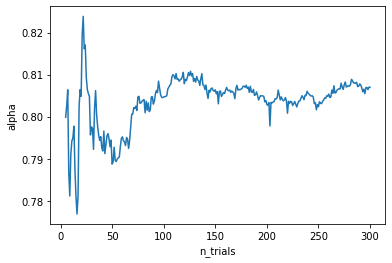

In [42]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

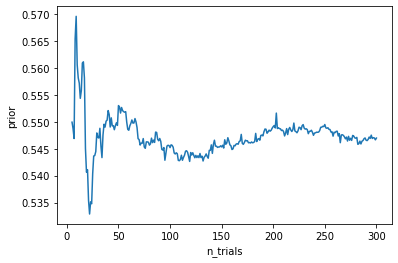

In [43]:
sns.lineplot(data=df, x='n_trials', y='prior')

## with noise 0.15

In [83]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.2311542287278977, 'alpha =', 0.45481951729813097)
R2: 0.9397434421177505
mean squared error 0.0012748928700076286
SD error 0.03570563291564723
iteration 1 6 6
Best parameter estimates: prior = (0.18772218719529196, 'alpha =', 0.5092470450712459)
R2: 0.9456954654268611
mean squared error 0.001781272522800171
SD error 0.04220511545514398
iteration 2 7 7
Best parameter estimates: prior = (0.1930760297400757, 'alpha =', 0.48422311476519153)
R2: 0.934888687342505
mean squared error 0.0019708793137309384
SD error 0.04439452433170897
iteration 3 8 8
Best parameter estimates: prior = (0.19488500952249835, 'alpha =', 0.49320850624375323)
R2: 0.926917126658068
mean squared error 0.00209071839103754
SD error 0.04572437301149026
iteration 4 9 9
Best parameter estimates: prior = (0.1955725549669015, 'alpha =', 0.49388953534392455)
R2: 0.9270031174935989
mean squared error 0.0018682511866172518
SD error 0.043223267380911506
iteration 5 10 10
Best 

Best parameter estimates: prior = (0.19733489193764678, 'alpha =', 0.4778599537634569)
R2: 0.9216270779776043
mean squared error 0.0019314679816230668
SD error 0.0439484687234227
iteration 29 34 34
Best parameter estimates: prior = (0.19199814526933312, 'alpha =', 0.48516611202438414)
R2: 0.9233470389331545
mean squared error 0.0019780750733293046
SD error 0.044471499238419546
iteration 30 35 35
Best parameter estimates: prior = (0.19305890753643867, 'alpha =', 0.4839256328626019)
R2: 0.9221436280207777
mean squared error 0.001954608673559214
SD error 0.044210947866085364
iteration 31 36 36
Best parameter estimates: prior = (0.1917640367136217, 'alpha =', 0.48617207450934347)
R2: 0.9229174387116015
mean squared error 0.0019200630613112986
SD error 0.043813491446418135
iteration 32 37 37
Best parameter estimates: prior = (0.1953635547850543, 'alpha =', 0.48090313716572336)
R2: 0.9207838148234905
mean squared error 0.001938504999198975
SD error 0.044028441052108666
iteration 33 38 38
Bes

Best parameter estimates: prior = (0.18748732507117408, 'alpha =', 0.4824081099774016)
R2: 0.9153573700150405
mean squared error 0.0020662011933962267
SD error 0.04545533106713425
iteration 57 62 62
Best parameter estimates: prior = (0.18954926494453148, 'alpha =', 0.4806584463437134)
R2: 0.913720155716242
mean squared error 0.00207610311728061
SD error 0.045562674154861996
iteration 58 63 63
Best parameter estimates: prior = (0.18685218362328973, 'alpha =', 0.4862170678234401)
R2: 0.9152452714235175
mean squared error 0.0020714324853110563
SD error 0.04551293132238013
iteration 59 64 64
Best parameter estimates: prior = (0.18771958368317682, 'alpha =', 0.48407547454219607)
R2: 0.9155139290614318
mean squared error 0.0020391472460215944
SD error 0.04515657276845818
iteration 60 65 65
Best parameter estimates: prior = (0.1871367459418543, 'alpha =', 0.4845326649784987)
R2: 0.9127192134383484
mean squared error 0.0020778730568687944
SD error 0.04558051999316873
iteration 61 66 66
Best pa

Best parameter estimates: prior = (0.18800236366694306, 'alpha =', 0.4892519835467608)
R2: 0.9223783708983025
mean squared error 0.0020983751639596375
SD error 0.04580580586106466
iteration 85 90 90
Best parameter estimates: prior = (0.18851921345032482, 'alpha =', 0.4882541829316033)
R2: 0.9221007512934374
mean squared error 0.0020867500648658233
SD error 0.04568091925892406
iteration 86 91 91
Best parameter estimates: prior = (0.18827859128839766, 'alpha =', 0.48842248394219734)
R2: 0.922342471028499
mean squared error 0.002064640337197115
SD error 0.04543831286762968
iteration 87 92 92
Best parameter estimates: prior = (0.1883959383856605, 'alpha =', 0.4888537006447903)
R2: 0.9222474158940488
mean squared error 0.0020512503975469647
SD error 0.04529070958008991
iteration 88 93 93
Best parameter estimates: prior = (0.187907432144824, 'alpha =', 0.489545373812833)
R2: 0.9233289680039299
mean squared error 0.002039028445724906
SD error 0.0451548578127753
iteration 89 94 94
Best paramet

Best parameter estimates: prior = (0.1822343661021226, 'alpha =', 0.49755262536009015)
R2: 0.9273643306352624
mean squared error 0.0020265942891231465
SD error 0.045013936772855416
iteration 113 118 118
Best parameter estimates: prior = (0.18111222952567876, 'alpha =', 0.4985397956192344)
R2: 0.9273902087708612
mean squared error 0.002010592447003715
SD error 0.04483953016249287
iteration 114 119 119
Best parameter estimates: prior = (0.18122750112682082, 'alpha =', 0.49847168476912856)
R2: 0.9286225233646598
mean squared error 0.0019938807418980755
SD error 0.04465268960885688
iteration 115 120 120
Best parameter estimates: prior = (0.18060258643966365, 'alpha =', 0.49878273101830567)
R2: 0.9300474014990141
mean squared error 0.0019935127016079157
SD error 0.04464874813882569
iteration 116 121 121
Best parameter estimates: prior = (0.180425179376307, 'alpha =', 0.4994245271910615)
R2: 0.9306423902513052
mean squared error 0.00197739084121463
SD error 0.04446762036093667
iteration 117 

Best parameter estimates: prior = (0.18308300157264548, 'alpha =', 0.49587856767585864)
R2: 0.9303288741332992
mean squared error 0.001963245630317076
SD error 0.04430411227575261
iteration 141 146 146
Best parameter estimates: prior = (0.182390043012163, 'alpha =', 0.49641422753670755)
R2: 0.9301401134996047
mean squared error 0.0019564140220977126
SD error 0.044231369139228635
iteration 142 147 147
Best parameter estimates: prior = (0.18068192679316047, 'alpha =', 0.49870150300686683)
R2: 0.930191223415185
mean squared error 0.001986475969290786
SD error 0.044569837070750136
iteration 143 148 148
Best parameter estimates: prior = (0.18120028709985028, 'alpha =', 0.49807666977331133)
R2: 0.9304417323303774
mean squared error 0.0019740812147405733
SD error 0.04443028504518562
iteration 144 149 149
Best parameter estimates: prior = (0.18131564423932403, 'alpha =', 0.498345057351968)
R2: 0.930818655713409
mean squared error 0.0019625768784606555
SD error 0.04429976107976038
iteration 145

Best parameter estimates: prior = (0.18259279311912163, 'alpha =', 0.4954534763430611)
R2: 0.930616338048389
mean squared error 0.0018947134574478343
SD error 0.04352830554128051
iteration 169 174 174
Best parameter estimates: prior = (0.18334780159213104, 'alpha =', 0.49539010496692837)
R2: 0.929937246953129
mean squared error 0.0019048398086540662
SD error 0.043642799961828176
iteration 170 175 175
Best parameter estimates: prior = (0.18270269782656504, 'alpha =', 0.49593265480519044)
R2: 0.9296839123991635
mean squared error 0.001901099228956315
SD error 0.04360125563257328
iteration 171 176 176
Best parameter estimates: prior = (0.18351950471703296, 'alpha =', 0.4949344074344394)
R2: 0.9299768964747922
mean squared error 0.0018902991896219599
SD error 0.04347741229286093
iteration 172 177 177
Best parameter estimates: prior = (0.1831202860187772, 'alpha =', 0.4954055366152973)
R2: 0.930524780783389
mean squared error 0.0018804720073699913
SD error 0.04336438576550513
iteration 173 

Best parameter estimates: prior = (0.1815980095798858, 'alpha =', 0.4950321599799629)
R2: 0.9319402584976602
mean squared error 0.0018555008664012343
SD error 0.04307519963428134
iteration 197 202 202
Best parameter estimates: prior = (0.18171406467948872, 'alpha =', 0.4947494937475198)
R2: 0.9320128034316781
mean squared error 0.00184707700702909
SD error 0.04297758055349795
iteration 198 203 203
Best parameter estimates: prior = (0.18144681567868792, 'alpha =', 0.4946358366923269)
R2: 0.9315200471263355
mean squared error 0.0018516339446048918
SD error 0.04303061635264589
iteration 199 204 204
Best parameter estimates: prior = (0.18152508744290533, 'alpha =', 0.49439461352356034)
R2: 0.9315359152346709
mean squared error 0.0018442682619222678
SD error 0.04294492714690207
iteration 200 205 205
Best parameter estimates: prior = (0.18129881307884013, 'alpha =', 0.49480105458030077)
R2: 0.931679338313908
mean squared error 0.0018355036201819067
SD error 0.04284277786919874
iteration 201 

Best parameter estimates: prior = (0.1812064678654722, 'alpha =', 0.49414771432193977)
R2: 0.9338991620177346
mean squared error 0.0018071716926578352
SD error 0.04251075013754482
iteration 225 230 230
Best parameter estimates: prior = (0.18198089216932434, 'alpha =', 0.4926249935504804)
R2: 0.9336775267601088
mean squared error 0.0018080348034473057
SD error 0.04252041600718925
iteration 226 231 231
Best parameter estimates: prior = (0.1816711590556633, 'alpha =', 0.49353046384121635)
R2: 0.9330014418959514
mean squared error 0.001818559002697597
SD error 0.04264438304886237
iteration 227 232 232
Best parameter estimates: prior = (0.18152846615973103, 'alpha =', 0.4935504894250184)
R2: 0.9329984360678274
mean squared error 0.0018130303623569224
SD error 0.042579592051553566
iteration 228 233 233
Best parameter estimates: prior = (0.18157601584121325, 'alpha =', 0.49402616048656667)
R2: 0.9330780599464312
mean squared error 0.0018196168779042636
SD error 0.04265669367841944
iteration 2

Best parameter estimates: prior = (0.17797356142468376, 'alpha =', 0.49736543785541526)
R2: 0.9333786008937845
mean squared error 0.001825976844617096
SD error 0.042731094999839965
iteration 253 258 258
Best parameter estimates: prior = (0.17798220744188048, 'alpha =', 0.49709651797486887)
R2: 0.9330636186195889
mean squared error 0.0018345920778848046
SD error 0.04283162116480742
iteration 254 259 259
Best parameter estimates: prior = (0.177611284672408, 'alpha =', 0.4973784652776949)
R2: 0.9333371978670748
mean squared error 0.00184139291429033
SD error 0.042911003376853704
iteration 255 260 260
Best parameter estimates: prior = (0.17751764134984385, 'alpha =', 0.4982463254795068)
R2: 0.9335669698920399
mean squared error 0.0018494833252814884
SD error 0.043003572549073506
iteration 256 261 261
Best parameter estimates: prior = (0.1772828457203805, 'alpha =', 0.49822488363904166)
R2: 0.9340825923060035
mean squared error 0.001842859622600094
SD error 0.04292836076101053
iteration 257

Best parameter estimates: prior = (0.17559553452585608, 'alpha =', 0.5015554682414675)
R2: 0.933039257967243
mean squared error 0.0018936596997184267
SD error 0.04351598385553747
iteration 281 286 286
Best parameter estimates: prior = (0.17615452746785562, 'alpha =', 0.5012578748837981)
R2: 0.9334699730727405
mean squared error 0.0018913235271026405
SD error 0.0434891318104274
iteration 282 287 287
Best parameter estimates: prior = (0.1760875792319395, 'alpha =', 0.5016070196846704)
R2: 0.9337179929528507
mean squared error 0.0018970095931935675
SD error 0.04355464184943223
iteration 283 288 288
Best parameter estimates: prior = (0.1757794149285602, 'alpha =', 0.5021967136786516)
R2: 0.933931102039818
mean squared error 0.0018911938169963627
SD error 0.04348770469107017
iteration 284 289 289
Best parameter estimates: prior = (0.17621896890301128, 'alpha =', 0.5015625235107517)
R2: 0.9338657689502439
mean squared error 0.0018868205521622608
SD error 0.0434365384619724
iteration 285 290 

In [84]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

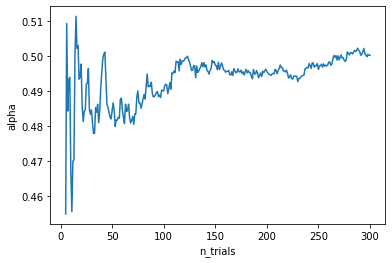

In [85]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

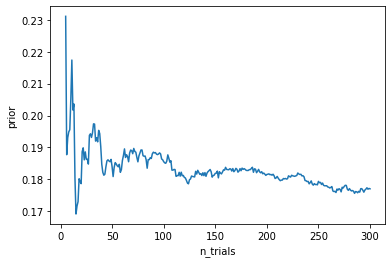

In [86]:
sns.lineplot(data=df, x='n_trials', y='prior')

## with noise = 0.07

In [75]:
est_params_ntt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_ntt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.13331670623671002, 'alpha =', 0.49805780124618554)
R2: 0.9955344079153592
mean squared error 0.00010689427690937372
SD error 0.01033896770083173
iteration 1 6 6
Best parameter estimates: prior = (0.15225146524222913, 'alpha =', 0.4745518066742216)
R2: 0.993012891066315
mean squared error 0.00019191225339569898
SD error 0.013814118083214826
iteration 2 7 7
Best parameter estimates: prior = (0.1495872013011258, 'alpha =', 0.4803012760540779)
R2: 0.9939003856071442
mean squared error 0.00017205083715817683
SD error 0.013115082295255574
iteration 3 8 8
Best parameter estimates: prior = (0.14886228896696718, 'alpha =', 0.4823940217162648)
R2: 0.9939491995035336
mean squared error 0.00015426141933604778
SD error 0.012420184864636339
iteration 4 9 9
Best parameter estimates: prior = (0.1499348728184422, 'alpha =', 0.48114040746234593)
R2: 0.9939539939054611
mean squared error 0.00013751663007384302
SD error 0.011719659168717271
iteration 5 

Best parameter estimates: prior = (0.13864261631907618, 'alpha =', 0.49800237545563864)
R2: 0.9853580438404566
mean squared error 0.00036712381478807855
SD error 0.019155771167331855
iteration 29 34 34
Best parameter estimates: prior = (0.1373829215471781, 'alpha =', 0.4993991101722477)
R2: 0.9860404572299718
mean squared error 0.00035738632006459707
SD error 0.018904043774422584
iteration 30 35 35
Best parameter estimates: prior = (0.13640098875579867, 'alpha =', 0.49967206017897375)
R2: 0.9857578311180913
mean squared error 0.0003576128586334914
SD error 0.018910265983179013
iteration 31 36 36
Best parameter estimates: prior = (0.13611605116380382, 'alpha =', 0.5001935041935063)
R2: 0.9859543266238707
mean squared error 0.0003480797926123712
SD error 0.018656895804465255
iteration 32 37 37
Best parameter estimates: prior = (0.1375263944651595, 'alpha =', 0.498499515384606)
R2: 0.9859675925791529
mean squared error 0.0003451566250883871
SD error 0.01857831842641629
iteration 33 38 38


Best parameter estimates: prior = (0.14085262194971243, 'alpha =', 0.4907914978437568)
R2: 0.9847945691710922
mean squared error 0.000355028895304574
SD error 0.018838991843707447
iteration 57 62 62
Best parameter estimates: prior = (0.14310730652278758, 'alpha =', 0.4880377153525848)
R2: 0.9848452419893258
mean squared error 0.0003505766596420409
SD error 0.018721446177235083
iteration 58 63 63
Best parameter estimates: prior = (0.14172024268805697, 'alpha =', 0.49028226811961756)
R2: 0.9848183165654876
mean squared error 0.00035584739647288416
SD error 0.01886160139912545
iteration 59 64 64
Best parameter estimates: prior = (0.1409598460732771, 'alpha =', 0.4925287165551213)
R2: 0.9845401124912073
mean squared error 0.00035720776128894135
SD error 0.018899328842902883
iteration 60 65 65
Best parameter estimates: prior = (0.14254240496940407, 'alpha =', 0.49107431829086307)
R2: 0.9840918689958116
mean squared error 0.00036233104978757394
SD error 0.01903371969237699
iteration 61 66 66

Best parameter estimates: prior = (0.13710757809732887, 'alpha =', 0.4980708142872661)
R2: 0.9860130725979668
mean squared error 0.000366749702976684
SD error 0.019150654354848355
iteration 85 90 90
Best parameter estimates: prior = (0.13703411017924672, 'alpha =', 0.49815127831321626)
R2: 0.9859886609239413
mean squared error 0.00036461530982858194
SD error 0.01909445606389974
iteration 86 91 91
Best parameter estimates: prior = (0.1383862199941664, 'alpha =', 0.49615178277858984)
R2: 0.9859542830133009
mean squared error 0.000362740706196952
SD error 0.019043780968676614
iteration 87 92 92
Best parameter estimates: prior = (0.13718415637767062, 'alpha =', 0.49782063721295194)
R2: 0.9859747375779633
mean squared error 0.00035873968874794383
SD error 0.01894038820673205
iteration 88 93 93
Best parameter estimates: prior = (0.13653500621285272, 'alpha =', 0.49888865869550836)
R2: 0.986104577886167
mean squared error 0.0003578435209504611
SD error 0.018916189291276305
iteration 89 94 94


Best parameter estimates: prior = (0.13493368184406634, 'alpha =', 0.5012079403606977)
R2: 0.984868166895853
mean squared error 0.00040109754494445235
SD error 0.020027389364832896
iteration 113 118 118
Best parameter estimates: prior = (0.13562991171173475, 'alpha =', 0.5003854431130015)
R2: 0.9846570915461933
mean squared error 0.0004044784669666049
SD error 0.020111578033402414
iteration 114 119 119
Best parameter estimates: prior = (0.1352838797116187, 'alpha =', 0.500545255324663)
R2: 0.9849094868396349
mean squared error 0.00040208862157658457
SD error 0.020049961614790758
iteration 115 120 120
Best parameter estimates: prior = (0.136221874008358, 'alpha =', 0.4997769800237594)
R2: 0.9849988051649381
mean squared error 0.00040365879981929125
SD error 0.020091240663887972
iteration 116 121 121
Best parameter estimates: prior = (0.13627743734573713, 'alpha =', 0.49979649910241564)
R2: 0.9851484144645621
mean squared error 0.00040033110858647106
SD error 0.020008045745134078
iterati

Best parameter estimates: prior = (0.13769344508606268, 'alpha =', 0.4978482962581705)
R2: 0.9853639235661503
mean squared error 0.0003911528180084678
SD error 0.01977541501509932
iteration 140 145 145
Best parameter estimates: prior = (0.13711268887498843, 'alpha =', 0.4988968840663604)
R2: 0.9853183131557167
mean squared error 0.0003944492480009556
SD error 0.019860611923084373
iteration 141 146 146
Best parameter estimates: prior = (0.1364278632190302, 'alpha =', 0.4997132077993888)
R2: 0.9853152887318317
mean squared error 0.00039187054430002595
SD error 0.019795014637299796
iteration 142 147 147
Best parameter estimates: prior = (0.13818073299540032, 'alpha =', 0.4975694282907258)
R2: 0.9854927813295804
mean squared error 0.00039001355592064587
SD error 0.019742768251628025
iteration 143 148 148
Best parameter estimates: prior = (0.1369997999452097, 'alpha =', 0.4992211644679134)
R2: 0.9855254116143468
mean squared error 0.000388163979275909
SD error 0.01970160183863097
iteration 

Best parameter estimates: prior = (0.13692490081482653, 'alpha =', 0.49796591555220177)
R2: 0.984710222651252
mean squared error 0.00040004201860411215
SD error 0.020000418589739923
iteration 167 172 172
Best parameter estimates: prior = (0.13558588109980468, 'alpha =', 0.5003269869598255)
R2: 0.9847784272018253
mean squared error 0.0003980129124156772
SD error 0.01994948272132989
iteration 168 173 173
Best parameter estimates: prior = (0.13645042283852551, 'alpha =', 0.4990161943059405)
R2: 0.9848697320591686
mean squared error 0.0003960880371397978
SD error 0.01990193129626141
iteration 169 174 174
Best parameter estimates: prior = (0.1367103791505826, 'alpha =', 0.4985884309563883)
R2: 0.9848340198871581
mean squared error 0.0003948367252781298
SD error 0.019870493537154046
iteration 170 175 175
Best parameter estimates: prior = (0.13643445548925293, 'alpha =', 0.4989057545910397)
R2: 0.9848434575382838
mean squared error 0.00039264524195003163
SD error 0.019814800938217456
iteratio

Best parameter estimates: prior = (0.1342068459441146, 'alpha =', 0.5018556057459194)
R2: 0.9849624430237333
mean squared error 0.0004008301165003864
SD error 0.0200207376434751
iteration 194 199 199
Best parameter estimates: prior = (0.1343027475841955, 'alpha =', 0.501685904402245)
R2: 0.9849516990402318
mean squared error 0.00039972168945406964
SD error 0.019992892475333358
iteration 195 200 200
Best parameter estimates: prior = (0.13494776206963938, 'alpha =', 0.5006075432716888)
R2: 0.9849278647827758
mean squared error 0.0003987863853423537
SD error 0.019969557176159794
iteration 196 201 201
Best parameter estimates: prior = (0.13454731926277363, 'alpha =', 0.501371819341514)
R2: 0.9849942221682282
mean squared error 0.00039822342545750664
SD error 0.019955527569947572
iteration 197 202 202
Best parameter estimates: prior = (0.13436043575869158, 'alpha =', 0.5017887059094357)
R2: 0.9850250354622546
mean squared error 0.00039630270635466444
SD error 0.019907314585745708
iteration 

Best parameter estimates: prior = (0.13431917815007433, 'alpha =', 0.5018766355802574)
R2: 0.9850843214774787
mean squared error 0.00039875152874976856
SD error 0.019968034773502334
iteration 221 226 226
Best parameter estimates: prior = (0.1344853305960506, 'alpha =', 0.5015298614664072)
R2: 0.9850972447805854
mean squared error 0.00039937254803940167
SD error 0.01998275465399712
iteration 222 227 227
Best parameter estimates: prior = (0.13434387050677818, 'alpha =', 0.5012902413330952)
R2: 0.9850703145176916
mean squared error 0.0004015609804781042
SD error 0.02003868953961125
iteration 223 228 228
Best parameter estimates: prior = (0.1344228759511087, 'alpha =', 0.5004470156911441)
R2: 0.9849510792612882
mean squared error 0.00040425540460898305
SD error 0.02010564125364202
iteration 224 229 229
Best parameter estimates: prior = (0.1337404701445291, 'alpha =', 0.5021754660995165)
R2: 0.9848288966397057
mean squared error 0.0004063033898634648
SD error 0.020156967221397627
iteration 

Best parameter estimates: prior = (0.1351925239300071, 'alpha =', 0.5010244714782062)
R2: 0.9846035981410058
mean squared error 0.0004084879485445428
SD error 0.020211026261277885
iteration 249 254 254
Best parameter estimates: prior = (0.13499723532276725, 'alpha =', 0.501242461608483)
R2: 0.9845690765269745
mean squared error 0.0004093539830439701
SD error 0.020232371139672668
iteration 250 255 255
Best parameter estimates: prior = (0.13516546356654455, 'alpha =', 0.501220041789243)
R2: 0.9845000258282853
mean squared error 0.0004111482896899693
SD error 0.020276481979035924
iteration 251 256 256
Best parameter estimates: prior = (0.1348910793277766, 'alpha =', 0.501445264995849)
R2: 0.9844235592449737
mean squared error 0.0004120546112491997
SD error 0.020299040472414456
iteration 252 257 257
Best parameter estimates: prior = (0.13533590632016912, 'alpha =', 0.5006343921392686)
R2: 0.9844093107433494
mean squared error 0.00041099375547308254
SD error 0.020272974198555647
iteration 2

Best parameter estimates: prior = (0.13696789199962542, 'alpha =', 0.4974998332014755)
R2: 0.9847818467719864
mean squared error 0.0004073592621176189
SD error 0.020181439373785113
iteration 276 281 281
Best parameter estimates: prior = (0.13705942700321092, 'alpha =', 0.498317607529559)
R2: 0.9846547504103912
mean squared error 0.0004093428082789761
SD error 0.020231629340707505
iteration 277 282 282
Best parameter estimates: prior = (0.13594757691680853, 'alpha =', 0.49969689082005436)
R2: 0.984621174438532
mean squared error 0.000408911621859477
SD error 0.020220941227752677
iteration 278 283 283
Best parameter estimates: prior = (0.1364021836044334, 'alpha =', 0.4985738008562068)
R2: 0.9846418104669025
mean squared error 0.00040755426892999386
SD error 0.02018596523748448
iteration 279 284 284
Best parameter estimates: prior = (0.13678651858264673, 'alpha =', 0.4982961924942984)
R2: 0.9846886536496623
mean squared error 0.00040612362306772734
SD error 0.020152405027044448
iteration

In [76]:
df = pd.DataFrame(est_params_ntt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

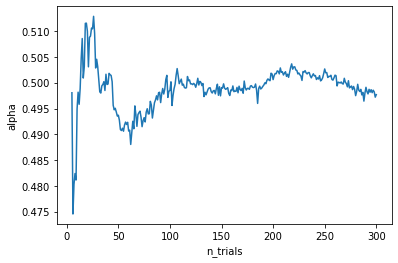

In [77]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

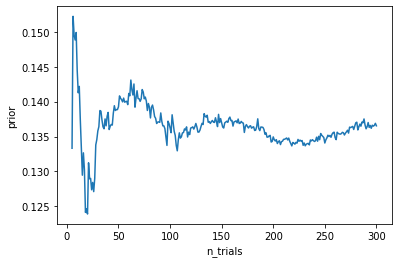

In [78]:
sns.lineplot(data=df, x='n_trials', y='prior')

### recover parameters from actual past colour reports

In [10]:
t1 = pd.read_feather('data/pilot2_subj1.ftr')

In [102]:
alpha = 0.75
prior = 0.3
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in t1['normed_signed_e_v'].values]

In [109]:
from collections import Counter

Counter(t1.e_v)

Counter({-0.1428571428571429: 5,
         0.2857142857142857: 8,
         0.4285714285714286: 6,
         0.1428571428571429: 8,
         0.5714285714285714: 6,
         0.7142857142857143: 13,
         0.8571428571428572: 11,
         -0.2857142857142857: 3})

In [110]:
Counter(t2.e_v)

Counter({-0.1428571428571429: 16,
         0.2857142857142857: 5,
         0.4285714285714286: 5,
         0.1428571428571429: 7,
         0.5714285714285714: 5,
         0.7142857142857143: 5,
         -0.5714285714285714: 1,
         -0.4285714285714286: 1,
         -0.2857142857142857: 11,
         -0.8571428571428572: 1,
         -0.7142857142857143: 3})

In [106]:
t2.tail()

,index,n_red,outcome,n_blue,e_v,normed_signed_e_v,normed_unsigned_e_v,cs_signed_e_v,normed_cs_signed_e_v,cs_unsigned_e_v,normed_cs_unsigned_e_v,n_reported_colour_opp,n_consec_colour,signed_n_consec_colour,normed_signed_colour_count,normed_unsigned_colour_count
55,115,1,1,6,0.142857,0.636364,0.285714,2.000000,0.772727,18.571429,0.909722,26,3,3,0.727273,0.6
56,116,5,1,2,0.714286,1.000000,0.857143,2.714286,1.000000,19.285714,0.944444,27,4,4,0.818182,0.8
57,117,2,-1,5,-0.714286,0.090909,0.857143,2.000000,0.772727,20.000000,0.979167,31,1,-1,0.363636,0.2
58,118,6,-1,1,-0.142857,0.454545,0.285714,1.857143,0.727273,20.142857,0.986111,32,2,-2,0.272727,0.4
59,119,5,-1,2,-0.285714,0.363636,0.428571,1.571429,0.636364,20.428571,1.000000,33,3,-3,0.181818,0.6


In [56]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=t1[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * t1['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.6502024027390818, 'alpha =', 0.43833584644375906)
R2: 0.9617098585804668
mean squared error 0.00030598660224845505
SD error 0.017492471690811043
iteration 1 6 6
Best parameter estimates: prior = (0.6480194416167547, 'alpha =', 0.46524017541472823)
R2: 0.9362193664441716
mean squared error 0.0005377236798349826
SD error 0.02318884185008692
iteration 2 7 7
Best parameter estimates: prior = (0.6451357232882435, 'alpha =', 0.4756525136903931)
R2: 0.9588738777739921
mean squared error 0.00047057353472194956
SD error 0.021692684667671436
iteration 3 8 8
Best parameter estimates: prior = (0.625658556034174, 'alpha =', 0.5366457446415788)
R2: 0.954941306689447
mean squared error 0.0008719359432466439
SD error 0.029528340084279403
iteration 4 9 9
Best parameter estimates: prior = (0.7366307590387214, 'alpha =', 0.2287734626634815)
R2: 0.1957442879089687
mean squared error 0.017921976756762572
SD error 0.1338727065601787
iteration 5 10 10
Best

Best parameter estimates: prior = (0.6955260902465478, 'alpha =', 0.11967853324372404)
R2: 0.035537245975197584
mean squared error 0.035503945681486695
SD error 0.1884243276916431
iteration 29 34 34
Best parameter estimates: prior = (0.6804384569609805, 'alpha =', 0.12907862233223977)
R2: 0.03788133046043585
mean squared error 0.03702736406758284
SD error 0.19242473281706704
iteration 30 35 35
Best parameter estimates: prior = (0.6857936028249763, 'alpha =', 0.11645153986021399)
R2: 0.03286517400644007
mean squared error 0.03620161625124817
SD error 0.19026708712743132
iteration 31 36 36
Best parameter estimates: prior = (0.6858724558621434, 'alpha =', 0.12921944274679387)
R2: 0.038452075207893066
mean squared error 0.03736064812206103
SD error 0.19328900887464068
iteration 32 37 37
Best parameter estimates: prior = (0.6908186263727459, 'alpha =', 0.11636318808480478)
R2: 0.03234639969809627
mean squared error 0.03668515728701034
SD error 0.19153348234337308
iteration 33 38 38
Best par

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 57 62 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 58 63 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 59 64 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 60 65 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 61 6

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 85 90 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 86 91 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 87 92 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 88 93 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 89 9

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 113 118 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 114 119 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 115 120 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 116 121 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 140 145 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 141 146 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 142 147 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 143 148 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 167 172 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 168 173 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 169 174 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 170 175 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 194 199 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 195 200 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 196 201 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 197 202 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 221 226 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 222 227 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 223 228 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 224 229 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 248 253 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 249 254 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 250 255 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 251 256 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 275 280 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 276 281 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 277 282 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iteration 278 283 60
Best parameter estimates: prior = (0.7651468988297814, 'alpha =', 0.010711693873499621)
R2: 0.0002939946121813808
mean squared error 0.03770063633938891
SD error 0.19416651025984555
iterat

In [57]:
df = pd.DataFrame(est_params_nt)

Game play from subject 1 mostly violated expectations (lying most of the time) -> parameter recovery not well possible, because model with high default prior fits best.

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

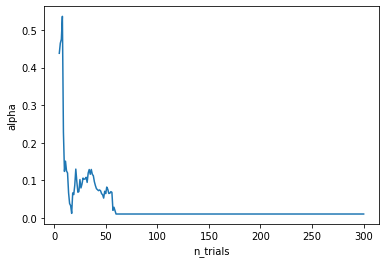

In [58]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

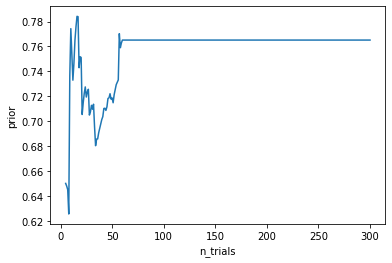

In [59]:
sns.lineplot(data=df, x='n_trials', y='prior')

On responses from subject 2 from pilot 2b

In [11]:
t2 = pd.read_feather('data/pilot2_subj2.ftr')

In [61]:
alpha = 0.75
prior = 0.3
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in t2['normed_signed_e_v'].values]

In [62]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=t2[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * t2['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.49212716130099804, 'alpha =', 0.5210415440970834)
R2: 0.9685600524476112
mean squared error 0.0001862228814054203
SD error 0.013646341451585154
iteration 1 6 6
Best parameter estimates: prior = (0.4920364543505375, 'alpha =', 0.5274860414994883)
R2: 0.9686567018404284
mean squared error 0.00017442830990498722
SD error 0.013008467846147346
iteration 2 7 7
Best parameter estimates: prior = (0.4790850709579028, 'alpha =', 0.5461619675995882)
R2: 0.9796780925421409
mean squared error 0.00015856169636106152
SD error 0.012592121358770721
iteration 3 8 8
Best parameter estimates: prior = (0.463324435206229, 'alpha =', 0.5726849345740341)
R2: 0.9836437371467813
mean squared error 0.00018511354723433802
SD error 0.013605416075700524
iteration 4 9 9
Best parameter estimates: prior = (0.45527841944971326, 'alpha =', 0.582993045447065)
R2: 0.985949623751915
mean squared error 0.00017791857951463048
SD error 0.013328488913021911
iteration 5 10 10

Best parameter estimates: prior = (0.3707308611420391, 'alpha =', 0.7118751274204506)
R2: 0.9806018891290852
mean squared error 0.0006619906878432796
SD error 0.025727722694670007
iteration 29 34 34
Best parameter estimates: prior = (0.36509193391901734, 'alpha =', 0.7201044754074615)
R2: 0.9811666243993431
mean squared error 0.0007017774876868403
SD error 0.026491066936163998
iteration 30 35 35
Best parameter estimates: prior = (0.3666853360464222, 'alpha =', 0.7188752965408574)
R2: 0.9804388476266391
mean squared error 0.0007087071471305099
SD error 0.026621553767825695
iteration 31 36 36
Best parameter estimates: prior = (0.36598279615091434, 'alpha =', 0.7222003869725014)
R2: 0.9811591635271023
mean squared error 0.0007061617583268724
SD error 0.026570306080314385
iteration 32 37 37
Best parameter estimates: prior = (0.36563719147282536, 'alpha =', 0.7218614384369029)
R2: 0.981231163220359
mean squared error 0.0006869411820028594
SD error 0.0262093335399833
iteration 33 38 38
Best 

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 57 62 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 58 63 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 59 64 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 60 65 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 61 66 60


Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 85 90 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 86 91 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 87 92 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 88 93 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 89 94 60


Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 113 118 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 114 119 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 115 120 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 116 121 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 1

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 141 146 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 142 147 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 143 148 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 144 149 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 1

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 169 174 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 170 175 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 171 176 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 172 177 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 1

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 197 202 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 198 203 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 199 204 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 200 205 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 2

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 225 230 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 226 231 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 227 232 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 228 233 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 2

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 253 258 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 254 259 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 255 260 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 256 261 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 2

Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 281 286 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 282 287 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 283 288 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 284 289 60
Best parameter estimates: prior = (0.35824235861711967, 'alpha =', 0.7340421443510069)
R2: 0.9807618098553597
mean squared error 0.0006860899894064522
SD error 0.026193247062306416
iteration 2

In [63]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

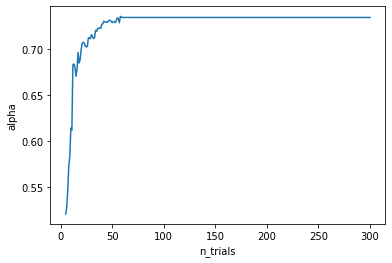

In [64]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

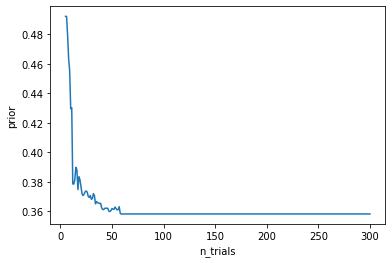

In [65]:
sns.lineplot(data=df, x='n_trials', y='prior')

On pilot 2b last subject

In [12]:
t5 = pd.read_feather('data/pilot2_subj4.ftr')

In [74]:
alpha = 0.75
prior = 0.3
noise = 0.10

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in t5['normed_signed_e_v'].values]

In [75]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=t5[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * t5['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.3927926213861055, 'alpha =', 0.6941209998562146)
R2: 0.9837900481421006
mean squared error 0.0002791608850430988
SD error 0.01668739739573807
iteration 1 6 6
Best parameter estimates: prior = (0.39419969413943523, 'alpha =', 0.6844075516291791)
R2: 0.9858274374788405
mean squared error 0.0002488541192696726
SD error 0.01577510522788297
iteration 2 7 7
Best parameter estimates: prior = (0.4050358133850774, 'alpha =', 0.652753995472732)
R2: 0.9858217025953953
mean squared error 0.00030182849927675516
SD error 0.017373211037043083
iteration 3 8 8
Best parameter estimates: prior = (0.3860778852370535, 'alpha =', 0.7030764044105966)
R2: 0.9801840886298961
mean squared error 0.0006190840914497113
SD error 0.02488133444667019
iteration 4 9 9
Best parameter estimates: prior = (0.3778258262153991, 'alpha =', 0.7123886485982612)
R2: 0.9788756253031532
mean squared error 0.0006391597848261322
SD error 0.025281608265494186
iteration 5 10 10
Best

Best parameter estimates: prior = (0.364481879337647, 'alpha =', 0.7325602657164492)
R2: 0.988070318116026
mean squared error 0.0005441229157104656
SD error 0.023317260589965732
iteration 29 34 34
Best parameter estimates: prior = (0.3645059255772449, 'alpha =', 0.7310286049282723)
R2: 0.9870100900944467
mean squared error 0.0005756381811806603
SD error 0.023991324347672257
iteration 30 35 35
Best parameter estimates: prior = (0.36204173332948075, 'alpha =', 0.7349857908298092)
R2: 0.986879366435962
mean squared error 0.0005721966112905361
SD error 0.02392062530690057
iteration 31 36 36
Best parameter estimates: prior = (0.36456913577638533, 'alpha =', 0.7282078066901653)
R2: 0.9863068034987843
mean squared error 0.0005922264362726333
SD error 0.024335671780200286
iteration 32 37 37
Best parameter estimates: prior = (0.3647314696463839, 'alpha =', 0.7280437759141161)
R2: 0.9864224070122498
mean squared error 0.0005764953403107429
SD error 0.024010264349919524
iteration 33 38 38
Best pa

Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 57 62 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 58 63 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 59 64 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 60 65 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 61 66 60
Best param

Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 85 90 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 86 91 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 87 92 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 88 93 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 89 94 60
Best param

Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 113 118 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 114 119 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 115 120 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 116 121 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 117 122 60


Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 141 146 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 142 147 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 143 148 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 144 149 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 145 150 60


Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 169 174 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 170 175 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 171 176 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 172 177 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 173 178 60


Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 197 202 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 198 203 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 199 204 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 200 205 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 201 206 60


Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 225 230 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 226 231 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 227 232 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 228 233 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 229 234 60


Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 253 258 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 254 259 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 255 260 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 256 261 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 257 262 60


Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 281 286 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 282 287 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 283 288 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 284 289 60
Best parameter estimates: prior = (0.3540222084291022, 'alpha =', 0.7426990342521689)
R2: 0.982419866063261
mean squared error 0.0007061968485847492
SD error 0.026574117188848844
iteration 285 290 60


In [76]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

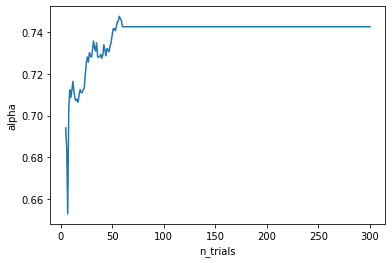

In [77]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

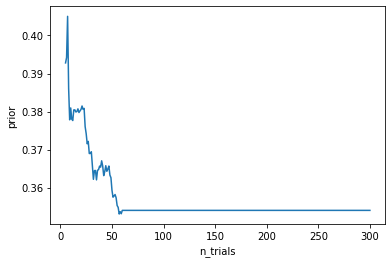

In [78]:
sns.lineplot(data=df, x='n_trials', y='prior')

In [73]:
tt = t1.append(t2)

In [15]:
tn = t1.append(t5)

In [16]:
tm = t2.append(t5)

In [74]:
trials = tt.iloc[:,:5]

In [75]:
trials.reset_index(inplace=True)

In [76]:
trials

,level_0,index,n_red,outcome,n_blue,e_v
0,0,0,6,-1,1,-0.142857
1,1,1,6,-1,1,-0.142857
2,2,2,2,1,5,0.285714
3,3,3,3,1,4,0.428571
4,4,4,1,1,6,0.142857
...,...,...,...,...,...,...
115,55,115,1,1,6,0.142857
116,56,116,5,1,2,0.714286
117,57,117,2,-1,5,-0.714286
118,58,118,6,-1,1,-0.142857


In [77]:
n_card_per_trial = 7

trials['trial'] = trials.index + 1

trials['n_blue'] = n_card_per_trial - trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1,
                         trials['outcome'] - trials['outcome'] * (trials['n_red'] / n_card_per_trial), \
                         trials['outcome'] - trials['outcome'] * (
                                     n_card_per_trial - trials['n_red']) / n_card_per_trial)
trials['normed_signed_e_v'] = normalize(trials['e_v'])
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

trials['cs_signed_e_v'] = trials['e_v'].cumsum()
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

count_red = abs(trials.outcome[lambda x: x == -1].cumsum())
count_blue = abs(trials.outcome[lambda x: x == 1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

track_freq = [1] * len(trials)
for i, outcome in enumerate(trials['outcome'].values):
    if (i == 0):
        continue
    if (i > 0):
        if (outcome != trials['outcome'].values[i - 1]):
            continue
        if (outcome == trials['outcome'].values[i - 1]):
            track_freq[i] = track_freq[i - 1] + 1
trials['n_consec_colour'] = track_freq

trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']
normalized_signed_colour_count = normalize(trials['signed_n_consec_colour'].values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count
trials['normed_unsigned_colour_count'] = [(v / 5) for v in trials.n_consec_colour]

In [23]:
trials

,level_0,index,n_red,outcome,n_blue,e_v,trial,normed_signed_e_v,normed_unsigned_e_v,cs_signed_e_v,normed_cs_signed_e_v,cs_unsigned_e_v,normed_cs_unsigned_e_v,n_reported_colour_opp,n_consec_colour,signed_n_consec_colour,normed_signed_colour_count,normed_unsigned_colour_count
0,0,0,6,-1,1,-0.142857,1,0.416667,0.285714,-1.428571e-01,0.004831,0.142857,0.005682,1,1,-1,0.235294,0.2
1,1,1,6,-1,1,-0.142857,2,0.416667,0.285714,-2.857143e-01,0.000000,0.285714,0.008523,2,2,-2,0.176471,0.4
2,2,2,2,1,5,0.285714,3,0.666667,0.428571,-1.110223e-16,0.009662,0.571429,0.014205,1,1,1,0.352941,0.2
3,3,3,3,1,4,0.428571,4,0.750000,0.571429,4.285714e-01,0.024155,1.000000,0.022727,2,2,2,0.411765,0.4
4,4,4,1,1,6,0.142857,5,0.583333,0.285714,5.714286e-01,0.028986,1.142857,0.025568,3,3,3,0.470588,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,55,115,1,1,6,0.142857,116,0.583333,0.285714,2.857143e+01,0.975845,48.285714,0.963068,78,3,3,0.470588,0.6
116,56,116,5,1,2,0.714286,117,0.916667,0.857143,2.928571e+01,1.000000,49.000000,0.977273,79,4,4,0.529412,0.8
117,57,117,2,-1,5,-0.714286,118,0.083333,0.857143,2.857143e+01,0.975845,49.714286,0.991477,39,1,-1,0.235294,0.2
118,58,118,6,-1,1,-0.142857,119,0.416667,0.285714,2.842857e+01,0.971014,49.857143,0.994318,40,2,-2,0.176471,0.4


<AxesSubplot:ylabel='normed_signed_colour_count'>

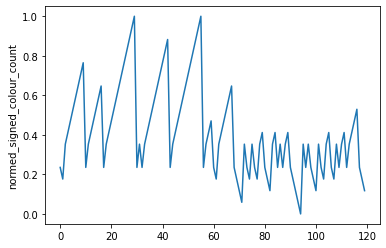

In [24]:
sns.lineplot(data=trials.normed_signed_colour_count)

In [121]:
alpha = 0.7
prior = 0.333
noise = 0.07

sim_data = [prior + alpha * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]

In [122]:
est_params_nt = []

for i, n in enumerate(est_n_trials):
    ss_tot =  np.sum((sim_data[:n]-np.mean(sim_data[:n]))**2)
    print("iteration", i, n, len(sim_data[:n]))
    gp_result = gp_minimize(partial(objective_single_model, response=sim_data[:n], trials=trials[:n], stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'][:n]
    mse = mean_squared_error(sim_data[:n], pred)
    est_params_nt.append({'prior': gp_result.x[0], 'alpha': gp_result.x[1], 'n_trials': est_n_trials[i], 'mse': mse})
    print("mean squared error", mse)
    print("SD error", np.std(sim_data[:n]-pred))
    print("=" * 100)

iteration 0 5 5
Best parameter estimates: prior = (0.31466146775780995, 'alpha =', 0.8166534632790116)
R2: 0.9774058780175505
mean squared error 0.0002752737380993371
SD error 0.016585903396272552
iteration 1 6 6
Best parameter estimates: prior = (0.31604768738826655, 'alpha =', 0.8168152591087443)
R2: 0.9792204890357413
mean squared error 0.00023259380597641304
SD error 0.015249149454410674
iteration 2 7 7
Best parameter estimates: prior = (0.31714477247396994, 'alpha =', 0.8133983471409254)
R2: 0.9861256028609865
mean squared error 0.00020124072695008305
SD error 0.01418432375952472
iteration 3 8 8
Best parameter estimates: prior = (0.34021569318576544, 'alpha =', 0.770113512182119)
R2: 0.98160086455244
mean squared error 0.0003132372944559044
SD error 0.01769771081231571
iteration 4 9 9
Best parameter estimates: prior = (0.34723057355221515, 'alpha =', 0.7587822351060013)
R2: 0.987002530192715
mean squared error 0.00028097037185482006
SD error 0.016761987543714402
iteration 5 10 10


Best parameter estimates: prior = (0.38732026739133624, 'alpha =', 0.69505427085274)
R2: 0.9694137765732241
mean squared error 0.0006198793553319727
SD error 0.024897376435035663
iteration 29 34 34
Best parameter estimates: prior = (0.3851623034561047, 'alpha =', 0.6965671861012899)
R2: 0.9682490207230464
mean squared error 0.0006291914836228172
SD error 0.0250832569910668
iteration 30 35 35
Best parameter estimates: prior = (0.38124396428780216, 'alpha =', 0.7031060864710248)
R2: 0.9691844808705008
mean squared error 0.0006360094252158917
SD error 0.02521868354749176
iteration 31 36 36
Best parameter estimates: prior = (0.3818803656317806, 'alpha =', 0.7020068756479404)
R2: 0.9692073125538933
mean squared error 0.000621062031010099
SD error 0.02492105910047112
iteration 32 37 37
Best parameter estimates: prior = (0.3819922547796404, 'alpha =', 0.7017916448134195)
R2: 0.9706154365684063
mean squared error 0.0006046405168112685
SD error 0.02458866811484051
iteration 33 38 38
Best parame

Best parameter estimates: prior = (0.3854988663748917, 'alpha =', 0.6929818437192694)
R2: 0.9657499767529885
mean squared error 0.0007097252737480132
SD error 0.026640151997946067
iteration 57 62 62
Best parameter estimates: prior = (0.3813762453642376, 'alpha =', 0.6973959941014681)
R2: 0.9665524249644845
mean squared error 0.0007208680184876491
SD error 0.02684894801918912
iteration 58 63 63
Best parameter estimates: prior = (0.3799845076204556, 'alpha =', 0.698708593219347)
R2: 0.9662909618357158
mean squared error 0.0007183341032523438
SD error 0.026801631472380856
iteration 59 64 64
Best parameter estimates: prior = (0.38092672448031195, 'alpha =', 0.698563638123788)
R2: 0.9655314610412165
mean squared error 0.0007237140154272668
SD error 0.026900866691255437
iteration 60 65 65
Best parameter estimates: prior = (0.380662984297651, 'alpha =', 0.6967697255788272)
R2: 0.9649323461287619
mean squared error 0.0007375116247460586
SD error 0.027146999531074637
iteration 61 66 66
Best par

Best parameter estimates: prior = (0.3755078096415443, 'alpha =', 0.7039604310576343)
R2: 0.9728185771193996
mean squared error 0.0008143780489538775
SD error 0.02853523803743861
iteration 85 90 90
Best parameter estimates: prior = (0.37511808192721524, 'alpha =', 0.7032276225783411)
R2: 0.972351698132107
mean squared error 0.0008192130918597075
SD error 0.028621519731931794
iteration 86 91 91
Best parameter estimates: prior = (0.3768505471176313, 'alpha =', 0.7009150999822679)
R2: 0.9724958540314795
mean squared error 0.0008142678134127466
SD error 0.028534667488586088
iteration 87 92 92
Best parameter estimates: prior = (0.37547912919403675, 'alpha =', 0.7025832517943346)
R2: 0.9730498119755119
mean squared error 0.0008058007958337711
SD error 0.028382651727009368
iteration 88 93 93
Best parameter estimates: prior = (0.37746170984545935, 'alpha =', 0.7003118735968169)
R2: 0.9735035210657863
mean squared error 0.0007982986746467369
SD error 0.02825377574466623
iteration 89 94 94
Best 

Best parameter estimates: prior = (0.38530768988027764, 'alpha =', 0.692119703419185)
R2: 0.9712330431959257
mean squared error 0.0008518891334970565
SD error 0.0291871340757717
iteration 113 118 118
Best parameter estimates: prior = (0.3839723208498387, 'alpha =', 0.6934798337211511)
R2: 0.9723933827351446
mean squared error 0.0008509745834071142
SD error 0.029170428349361247
iteration 114 119 119
Best parameter estimates: prior = (0.3827636001197839, 'alpha =', 0.695299346528443)
R2: 0.972330735422489
mean squared error 0.0008541870257973098
SD error 0.02922647703451453
iteration 115 120 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 116 121 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 117 122 120

Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 141 146 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 142 147 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 143 148 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 144 149 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 145 150 120


Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 169 174 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 170 175 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 171 176 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 172 177 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 173 178 120


Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 197 202 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 198 203 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 199 204 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 200 205 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 201 206 120


Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 225 230 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 226 231 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 227 232 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 228 233 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 229 234 120


Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 253 258 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 254 259 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 255 260 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 256 261 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 257 262 120


Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 281 286 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 282 287 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 283 288 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 284 289 120
Best parameter estimates: prior = (0.38141468510106297, 'alpha =', 0.6967564115130385)
R2: 0.9725141662186
mean squared error 0.0008549514505493433
SD error 0.029239144122299828
iteration 285 290 120


In [123]:
df = pd.DataFrame(est_params_nt)

<AxesSubplot:xlabel='n_trials', ylabel='alpha'>

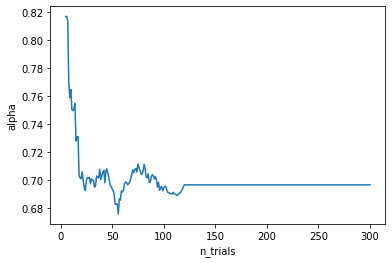

In [124]:
sns.lineplot(data=df, x='n_trials', y='alpha')

<AxesSubplot:xlabel='n_trials', ylabel='prior'>

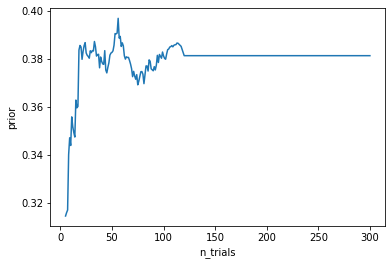

In [125]:
sns.lineplot(data=df, x='n_trials', y='prior')

## Randomize parameter simulation values

In [68]:
random_alpha = []
for i in range(10):
    random_alpha.append(random.uniform(0, 1))

In [69]:
random_prior = []
for i in range(10):
    random_prior.append(random.choice([0, 0.167, 0.333, 0.5, 0.667, 0.833, 1]))

In [ ]:
from itertools import product

rand_params = list(product(random_alpha, random_prior))
rand_params = set(rand_params)

In [10]:
noise = 0.07

## Simulate low variance data (low learning rates, varying priors)

In [71]:
random_alpha = []
for i in range(5000):
    random_alpha.append(random.uniform(0, 0.4))

In [72]:
random_prior = []

for i in range(5000):
    random_prior.append(random.choice([0, 0.167, 0.333, 0.5, 0.667, 0.833, 1]))

# random_prior = [0] * len(random_alpha)

In [73]:
rand_params = list(zip(random_alpha, random_prior))

In [35]:
# from itertools import product

# rand_params = list(product(random_alpha, random_prior))
# rand_params = set(rand_params)

In [74]:
from statistics import variance

sim_data = []
sim_variance = []

for i, params in enumerate(rand_params):
    print(i, params)
    sim = [params[1] + params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)
    
    sim_var = variance(sim)
    sim_variance.append(sim_var)

0 (0.05134856489364208, 0.833)
1 (0.23207810577213445, 0.5)
2 (0.01997972486844022, 1)
3 (0.24189618642832134, 0.333)
4 (0.3630306083200867, 0)
5 (0.32500772340355033, 0.833)
6 (0.08494062081342345, 0.167)
7 (0.16978456981514745, 0)
8 (0.15295597169740263, 0.167)
9 (0.11797316897264075, 0.833)
10 (0.3555818164400586, 0.167)
11 (0.2898515765003119, 0.667)
12 (0.23619239562270541, 0.833)
13 (0.33418790366270384, 0.667)
14 (0.2177028996111078, 0.333)
15 (0.32130159407378833, 0.333)
16 (0.3969948807335746, 0.667)
17 (0.11845640366065031, 0.833)
18 (0.21536487305086563, 1)
19 (0.15906280397835043, 0.167)
20 (0.3002940568734378, 0.833)
21 (0.34914881066604914, 0)
22 (0.18528696730485428, 1)
23 (0.3800657065450821, 1)
24 (0.13167338158223735, 0.667)
25 (0.14588890386592676, 1)
26 (0.06870511679280407, 0.5)
27 (0.36714335418958804, 0.667)
28 (0.15761118812331923, 1)
29 (0.22459935983280332, 0.667)
30 (0.3319172829845794, 0)
31 (0.16656109445118972, 0.167)
32 (0.23554506494043684, 0.333)
33 (0.

344 (0.1843317308026723, 0.5)
345 (0.09267144466406513, 0.5)
346 (0.3871333826760923, 0.833)
347 (0.2954652538337254, 0.833)
348 (0.26137380794040577, 1)
349 (0.3825529118631439, 0.5)
350 (0.27191564586903205, 1)
351 (0.008873846881143344, 0.833)
352 (0.2717626380488149, 0.5)
353 (0.04911431267702376, 0.667)
354 (0.36317146460082356, 0.5)
355 (0.16221865321739945, 0.667)
356 (0.06758067875392229, 0)
357 (0.34044468330460526, 0.167)
358 (0.09368049977024194, 0.167)
359 (0.07957829239001644, 0.5)
360 (0.3201662645206351, 0.167)
361 (0.16567677350934618, 1)
362 (0.03971522879184711, 0.667)
363 (0.05670075457162019, 0.833)
364 (0.3635200829418926, 0.5)
365 (0.3395132237054541, 0.667)
366 (0.22889647100196614, 0.167)
367 (0.35114904081376763, 0.167)
368 (0.32173359116241657, 0.333)
369 (0.2921662522946301, 0)
370 (0.36981861962716983, 0.833)
371 (0.08573414995739546, 0.167)
372 (0.25513881932125426, 0.333)
373 (0.11871360762746336, 0)
374 (0.18468406653659702, 0)
375 (0.3375319217946425, 0.

683 (0.16347792266590308, 0.667)
684 (0.3000005737796037, 0.333)
685 (0.21606580038022935, 0.833)
686 (0.002049329226467744, 0.833)
687 (0.30408651396384784, 0.667)
688 (0.3467920196881491, 0)
689 (0.28449960165434723, 0.667)
690 (0.040654187728355766, 0.667)
691 (0.049049287472067694, 0.667)
692 (0.008166125826426418, 0.5)
693 (0.3676306113739377, 0.833)
694 (0.16197520557463335, 0.333)
695 (0.16946123861518048, 0.833)
696 (0.03320624285268097, 0.833)
697 (0.09247490155283211, 0.333)
698 (0.14237243645641434, 0.667)
699 (0.2186475948963117, 0.667)
700 (0.10851919529255571, 0.333)
701 (0.22937388431243166, 0)
702 (0.09210632932181664, 0.5)
703 (0.176894245120241, 0.333)
704 (0.3638732355049397, 0.167)
705 (0.21476497264960434, 1)
706 (0.19609124278953005, 0.5)
707 (0.12524588296328298, 0.833)
708 (0.35909413398363693, 0.167)
709 (0.20575196371388957, 0.5)
710 (0.16018223664933254, 0)
711 (0.13518134696368023, 0.833)
712 (0.28162130079357056, 0.5)
713 (0.12019821393276726, 0.333)
714 (0

1034 (0.04866496877697882, 0.167)
1035 (0.030488497457674457, 1)
1036 (0.05994782902946976, 1)
1037 (0.25234416122476055, 0.333)
1038 (0.16550401172727558, 0.667)
1039 (0.06977513116193977, 0.333)
1040 (0.19943005013555176, 0.167)
1041 (0.35054403200417145, 0.667)
1042 (0.23786354832623818, 0.667)
1043 (0.2701930633684384, 0.333)
1044 (0.19189221080273844, 0.333)
1045 (0.13794924090028987, 0.667)
1046 (0.3462766564145311, 0.333)
1047 (0.1789959401584732, 0.5)
1048 (0.14919029570405481, 0.833)
1049 (0.3424970010770971, 0.833)
1050 (0.32821939891744595, 0.333)
1051 (0.16182935967961476, 1)
1052 (0.358261415277487, 0.667)
1053 (0.17481872808738733, 1)
1054 (0.21465394606574906, 0.167)
1055 (0.32791952127180735, 1)
1056 (0.34979971737428267, 0.167)
1057 (0.2789495949588088, 0.333)
1058 (0.38340348452500167, 0.833)
1059 (0.20311469347114983, 0.667)
1060 (0.04491286619637731, 0.667)
1061 (0.09537118285503486, 0.833)
1062 (0.3472148348929174, 0.167)
1063 (0.3292687657270053, 0)
1064 (0.298273

1452 (0.0027728392249142253, 0.667)
1453 (0.05447696363394172, 0.5)
1454 (0.17032117872682118, 0.167)
1455 (0.09451998160960247, 0.5)
1456 (0.26948910010028987, 0.167)
1457 (0.35171572797895384, 0.667)
1458 (0.18322451544519863, 0.333)
1459 (0.07216063280637197, 0.667)
1460 (0.012771480563410133, 0.333)
1461 (0.2604486189743653, 0.333)
1462 (0.11014523058132353, 0.167)
1463 (0.3920323822738247, 1)
1464 (0.2459673032908548, 0.333)
1465 (0.34774721453317187, 0.667)
1466 (0.08947590973251791, 0.333)
1467 (0.26221986414812265, 1)
1468 (0.3084116524814527, 0.167)
1469 (0.20662347544739262, 1)
1470 (0.04430943594932862, 0.833)
1471 (0.2500614192587595, 0.833)
1472 (0.18890967644022788, 0.833)
1473 (0.31226795778059835, 0)
1474 (0.37567478681004685, 0.167)
1475 (0.2921972964890453, 0.667)
1476 (0.2482246006824949, 0)
1477 (0.37283878814243054, 0.333)
1478 (0.24333552675885697, 1)
1479 (0.33980186524990685, 0)
1480 (0.18739434633354365, 0.667)
1481 (0.14216054957017815, 0)
1482 (0.099897725049

1811 (0.0004232657364226622, 0.833)
1812 (0.20613073131901605, 0.167)
1813 (0.0511996672610056, 0.5)
1814 (0.1832356261092748, 0.5)
1815 (0.01110761079955145, 0.5)
1816 (0.29137758370199346, 0.167)
1817 (0.3418260862828054, 0.5)
1818 (0.09186229079126473, 0.667)
1819 (0.37084732464174863, 0.667)
1820 (0.11607386377675591, 0.5)
1821 (0.3602080599077418, 0.167)
1822 (0.18683106913651001, 0.667)
1823 (0.38411935291117855, 0)
1824 (0.03741800355578517, 0.5)
1825 (0.07568750872657604, 0.667)
1826 (0.3672273395604588, 0)
1827 (0.20463610481194086, 1)
1828 (0.27362027407919587, 1)
1829 (0.20236517476192045, 1)
1830 (0.17321201227937572, 0.667)
1831 (0.36333898623716354, 0)
1832 (0.30159229763375267, 1)
1833 (0.11620435483876977, 0.5)
1834 (0.1085062156816091, 0.667)
1835 (0.10512418460128524, 0.333)
1836 (0.0644859724811239, 0)
1837 (0.12622358637165304, 0)
1838 (0.020778396241404984, 0.167)
1839 (0.07800483440547122, 0.167)
1840 (0.004360776619160678, 0.333)
1841 (0.1828172886829579, 0.333)


2234 (0.16124311604782737, 0.667)
2235 (0.007450675904585547, 0.5)
2236 (0.2562517428762268, 1)
2237 (0.2760252958232396, 0.333)
2238 (0.3649796096979294, 0.5)
2239 (0.020043830777776828, 0.833)
2240 (0.3351217119611474, 0.5)
2241 (0.37008481911471214, 0.5)
2242 (0.08985528948000449, 0)
2243 (0.030175482459953253, 0.5)
2244 (0.2511632071613357, 0.667)
2245 (0.2626851056993144, 0.5)
2246 (0.18953049416875142, 0.167)
2247 (0.0977497769154629, 0.667)
2248 (0.37963826993575017, 0.833)
2249 (0.33128021704353394, 0)
2250 (0.34021193834672, 1)
2251 (0.2161516225510373, 0.333)
2252 (0.23080253086518554, 0)
2253 (0.13488199467824388, 0)
2254 (0.32671887845683234, 0)
2255 (0.12368413508157024, 0)
2256 (0.24533959970742103, 0.833)
2257 (0.1388584296949844, 0)
2258 (0.160258919394298, 0)
2259 (0.3830577392282719, 0.5)
2260 (0.23793580385048896, 1)
2261 (0.17238526555167422, 0)
2262 (0.3524887171893125, 0)
2263 (0.1903867793855011, 0.167)
2264 (0.32286640901589014, 0)
2265 (0.1496190522797957, 0.33

2534 (0.09122418823982965, 0)
2535 (0.17869713552858857, 1)
2536 (0.017948174783617744, 0)
2537 (0.28068010175740093, 0.167)
2538 (0.15342802675777217, 0.833)
2539 (0.22724882373420857, 0.5)
2540 (0.012758668668463891, 0.833)
2541 (0.16041543963420157, 0.167)
2542 (0.09648329771109082, 0.333)
2543 (0.2010060070341159, 0.5)
2544 (0.14122667043677858, 0)
2545 (0.3528203395812749, 0.167)
2546 (0.23537207996298212, 0.667)
2547 (0.027785531543137676, 1)
2548 (0.08359940595028155, 0.167)
2549 (0.18501698747936912, 0.5)
2550 (0.0202455237836793, 0.167)
2551 (0.03145329308785607, 1)
2552 (0.2375649333576254, 0)
2553 (0.002622749433276628, 0.167)
2554 (0.017420700984039916, 0)
2555 (0.23799762886455822, 1)
2556 (0.062292498196349036, 0.833)
2557 (0.331962417308974, 0)
2558 (0.30422008209653084, 0.833)
2559 (0.17622914901779518, 0)
2560 (0.38551549108565064, 1)
2561 (0.15717602072919212, 0.333)
2562 (0.0372782747226748, 0.167)
2563 (0.06107504955802794, 0.833)
2564 (0.3602145770841612, 0.833)
25

2951 (0.2177054531986521, 0.333)
2952 (0.04131098903683275, 0.833)
2953 (0.08939843966523667, 0.167)
2954 (0.05977263783076606, 0.333)
2955 (0.3854740182189403, 0.833)
2956 (0.3573928623418522, 0)
2957 (0.045595374456084775, 0.667)
2958 (0.29786927904305943, 1)
2959 (0.29245800499559876, 0.833)
2960 (0.11326675770876432, 1)
2961 (0.29253089779844305, 1)
2962 (0.2918759917014355, 0)
2963 (0.15225091538794674, 0)
2964 (0.3924514037918838, 0)
2965 (0.18764960187273172, 0.5)
2966 (0.38358887944393083, 0.833)
2967 (0.32704962983704666, 0.833)
2968 (0.39780038352233915, 0.833)
2969 (0.36039097051789604, 1)
2970 (0.37554023672723846, 0.167)
2971 (0.08595708534949537, 0.167)
2972 (0.35654213234026483, 0.333)
2973 (0.3457442614074475, 0.833)
2974 (0.052540443482287105, 0.833)
2975 (0.015310594759124552, 0.333)
2976 (0.39584112846139613, 1)
2977 (0.024625338104677798, 0.667)
2978 (0.0847066528159599, 0.167)
2979 (0.061954723923514934, 0.167)
2980 (0.05038978202989322, 0.167)
2981 (0.343037655189

3576 (0.39649900164080815, 0.167)
3577 (0.2189707341721889, 0.667)
3578 (0.39169321865370227, 0.167)
3579 (0.3022234950843313, 0)
3580 (0.22124606801885682, 0.167)
3581 (0.21935705994259647, 0.5)
3582 (0.012075487771083405, 0.167)
3583 (0.061698119046047856, 0.333)
3584 (0.282288015660396, 0.667)
3585 (0.0660838457299842, 1)
3586 (0.39692459539246117, 0)
3587 (0.3385425213109265, 0.5)
3588 (0.016933483412513974, 0)
3589 (0.37517864344429186, 0.167)
3590 (0.22498290018210196, 0.167)
3591 (0.23780522179865013, 0.833)
3592 (0.11863285634131326, 0.167)
3593 (0.12585083873061095, 0)
3594 (0.24965899360377206, 0.333)
3595 (0.2057921173656887, 0.333)
3596 (0.27596375187180716, 0.333)
3597 (0.04407918871416472, 0.167)
3598 (0.07189674940493562, 0.5)
3599 (0.15356395044360036, 0.5)
3600 (0.27985547350033024, 0)
3601 (0.16212393779841305, 0)
3602 (0.3938514709353922, 0.667)
3603 (0.3303802888145936, 0.5)
3604 (0.3297167408986462, 0.333)
3605 (0.2536409453978938, 0.5)
3606 (0.03635936465404419, 0

3860 (0.3278590916686575, 1)
3861 (0.056062008089137465, 0.167)
3862 (0.06645982517578242, 1)
3863 (0.24881486226890243, 0.833)
3864 (0.24725066184747957, 0.667)
3865 (0.11707409205855886, 1)
3866 (0.037112881914424765, 1)
3867 (0.20935498774658062, 0.833)
3868 (0.2992451586855468, 0.833)
3869 (0.38566533842825534, 0.333)
3870 (0.03472562626013281, 0.333)
3871 (0.026468733058344008, 0.833)
3872 (0.10776665229060499, 0.667)
3873 (0.046131893657563386, 0.667)
3874 (0.1974292658934219, 1)
3875 (0.0652776689072431, 0.333)
3876 (0.10123164991704235, 1)
3877 (0.0013271894958789777, 1)
3878 (0.31941205128182304, 0)
3879 (0.3174760501336875, 1)
3880 (0.27192878343400667, 0.333)
3881 (0.00877614883572475, 0.333)
3882 (0.05642920369873142, 0.5)
3883 (0.13205467190055775, 0.167)
3884 (0.27680478477700776, 0.833)
3885 (0.16793018907837942, 0)
3886 (0.0965539678336497, 0.167)
3887 (0.09273304472186755, 0.333)
3888 (0.020230937664180805, 0.333)
3889 (0.32379248598995347, 0.333)
3890 (0.3263471174219

4201 (0.3145330403669955, 1)
4202 (0.017747393604056638, 0.333)
4203 (0.06269857249512767, 0.333)
4204 (0.23733052134597205, 0.5)
4205 (0.1882250355996322, 0)
4206 (0.14615313744070818, 0.167)
4207 (0.3614823381779837, 0.5)
4208 (0.3412825984396828, 0.5)
4209 (0.3870657455929666, 0)
4210 (0.08756986342059557, 0)
4211 (0.26082206113519696, 0.333)
4212 (0.29772233902972317, 0.5)
4213 (0.34993807649490205, 0.167)
4214 (0.3522891448056259, 0.667)
4215 (0.06185804266108539, 0.5)
4216 (0.385703340960511, 0.667)
4217 (0.04114361064719745, 0.667)
4218 (0.2578197786132035, 0)
4219 (0.3923872080276462, 1)
4220 (0.02445890445942536, 1)
4221 (0.07902706810552039, 0)
4222 (0.2647897814710513, 0.333)
4223 (0.12559698615871104, 0.167)
4224 (0.22311469271852935, 0.5)
4225 (0.3065288759611633, 0.5)
4226 (0.35738649803233824, 0.167)
4227 (0.2599922601492332, 0)
4228 (0.08562759441216726, 0.167)
4229 (0.08450015911407666, 0.667)
4230 (0.17973829637849917, 1)
4231 (0.23414021504781668, 0)
4232 (0.01777738

4620 (0.28661998286728163, 0)
4621 (0.09634561604575453, 0.5)
4622 (0.2959980662247484, 0.833)
4623 (0.25391029505800844, 0.167)
4624 (0.1251028368878216, 0.333)
4625 (0.15295341315819888, 0.333)
4626 (0.03681732527246786, 0.833)
4627 (0.09154918888816913, 0.167)
4628 (0.02959665152577782, 0.667)
4629 (0.25430090587675414, 1)
4630 (0.0676267648432038, 0.333)
4631 (0.23676331331439845, 0.833)
4632 (0.18037352172465912, 0.333)
4633 (0.0565577653445982, 0.333)
4634 (0.15076525236773422, 0)
4635 (0.14599796167717166, 1)
4636 (0.0726727697766675, 0.833)
4637 (0.01894406760377776, 0.833)
4638 (0.0522295356250893, 0.167)
4639 (0.24953187266587645, 0.167)
4640 (0.3472437007933527, 1)
4641 (0.25453273759471884, 0.833)
4642 (0.12133676358716908, 0.333)
4643 (0.3528380929376915, 0.667)
4644 (0.05858962406801367, 0.833)
4645 (0.32764351832810573, 0.167)
4646 (0.16609814917762425, 0)
4647 (0.38811668672148714, 0.833)
4648 (0.3319342649787416, 0.833)
4649 (0.04927575927880006, 1)
4650 (0.11504844664

4915 (0.24706680793002836, 0.667)
4916 (0.005672632257254096, 0)
4917 (0.2722696554855289, 0.167)
4918 (0.15827376396686077, 0)
4919 (0.14018702028244542, 0.833)
4920 (0.09714804583642551, 0.5)
4921 (0.0992953128534495, 0.5)
4922 (0.1405556641296169, 0.333)
4923 (0.20571948940451437, 0.667)
4924 (0.3451684745683612, 0.833)
4925 (0.08475273412870764, 0.833)
4926 (0.31417870994831565, 1)
4927 (0.0449214975022072, 1)
4928 (0.19661555431019295, 1)
4929 (0.3824286667997922, 0.667)
4930 (0.2565100877496459, 1)
4931 (0.3927321192637973, 0)
4932 (0.334713552449188, 1)
4933 (0.2932272530277062, 0)
4934 (0.29464006287069, 0.333)
4935 (0.11174705112634596, 0.5)
4936 (0.06155838378975509, 0)
4937 (0.31439828045145346, 0.5)
4938 (0.25281574689261443, 0.5)
4939 (0.19919443117226932, 0.833)
4940 (0.03600705490194631, 0.833)
4941 (0.2801688699550451, 0.833)
4942 (0.22650412852104873, 0.167)
4943 (0.02935693481328863, 1)
4944 (0.06458550283529951, 0.5)
4945 (0.28802792295524665, 0.333)
4946 (0.04421290

In [75]:
max(sim_variance)

0.019447368006369505

[(0.0, 1.0)]

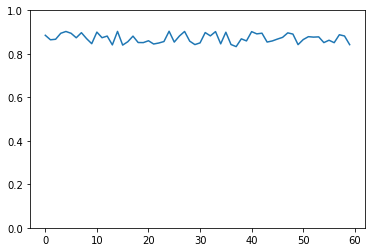

In [87]:
p = sns.lineplot(data=sim_data[47])
p.set(ylim=(0,1))

In [77]:
from scripts.analysis import skopt_fit_single_model_single_response

In [78]:
sim_result = []

for i, sim in enumerate(sim_data):
    print(i)
    result = skopt_fit_single_model_single_response(sim, trials, param_search_space, 'normed_signed_e_v')
    sim_result.append(result)

0
Best parameter estimates: prior = (0.8694101366012223, 'alpha =', 0.053285737916768126)
R2: 0.42341125009138547
BIC: -460.109881792278
AIC: -464.29857091672216
1
Best parameter estimates: prior = (0.5318244621343029, 'alpha =', 0.23762247803510297)
R2: 0.9394564436862151
BIC: -463.3382955770851
AIC: -467.5269847015293
2
Best parameter estimates: prior = (1.0, 'alpha =', 0.064063411212393)
R2: -0.8059479359963901
BIC: -423.7134684832055
AIC: -427.90215760764966
3
Best parameter estimates: prior = (0.3664643798261322, 'alpha =', 0.24497863465724903)
R2: 0.9494768554725865
BIC: -471.57046274383305
AIC: -475.75915186827723
4
Best parameter estimates: prior = (0.03820392996965109, 'alpha =', 0.37057849795131076)
R2: 0.9719347679046388
BIC: -457.4896606780047
AIC: -461.6783498024489
5
Best parameter estimates: prior = (0.8677144709422805, 'alpha =', 0.3229140779404051)
R2: 0.9633794401019692
BIC: -457.67696462992456
AIC: -461.86565375436874
6
Best parameter estimates: prior = (0.2054240457

Best parameter estimates: prior = (0.3712368367101209, 'alpha =', 0.22825997706620532)
R2: 0.9217520123009715
BIC: -451.1525758019331
AIC: -455.3412649263773
33
Best parameter estimates: prior = (0.030186531562344514, 'alpha =', 0.15823072199094196)
R2: 0.88625602759421
BIC: -470.6550953888472
AIC: -474.8437845132914
34
Best parameter estimates: prior = (0.1956889414632065, 'alpha =', 0.10106724308994322)
R2: 0.7504866118830515
BIC: -466.59363057363055
AIC: -470.78231969807473
35
Best parameter estimates: prior = (0.8690355000533264, 'alpha =', 0.2131235054093481)
R2: 0.9275402806404021
BIC: -464.5278274517915
AIC: -468.7165165762357
36
Best parameter estimates: prior = (0.02607941924586815, 'alpha =', 0.13504397657046646)
R2: 0.8202506410379864
BIC: -459.57524722554297
AIC: -463.76393634998715
37
Best parameter estimates: prior = (0.7020325380382596, 'alpha =', 0.24922252186955848)
R2: 0.9427771898090485
BIC: -460.692629796396
AIC: -464.88131892084016
38
Best parameter estimates: prio

Best parameter estimates: prior = (0.20113841291725115, 'alpha =', 0.30065648398290584)
R2: 0.9654402697945169
BIC: -469.60963451925636
AIC: -473.79832364370054
65
Best parameter estimates: prior = (0.19425242934101783, 'alpha =', 0.01297380460182516)
R2: 0.04777907701036743
BIC: -466.3491485391956
AIC: -470.5378376636398
66
Best parameter estimates: prior = (0.711309711770617, 'alpha =', 0.0672548226943855)
R2: 0.5679331417298739
BIC: -469.44180412335146
AIC: -473.63049324779564
67
Best parameter estimates: prior = (0.8622130421980666, 'alpha =', 0.363177022947713)
R2: 0.976765442703996
BIC: -471.6724959084249
AIC: -475.86118503286906
68
Best parameter estimates: prior = (1.0, 'alpha =', 0.27140333838979136)
R2: 0.8797033194410002
BIC: -424.0995941940752
AIC: -428.2882833185194
69
Best parameter estimates: prior = (0.19835891535509073, 'alpha =', 0.03125418933064701)
R2: 0.20439347801974794
BIC: -462.5160803336663
AIC: -466.7047694581105
70
Best parameter estimates: prior = (0.0300781

Best parameter estimates: prior = (0.8593486287037674, 'alpha =', 0.28422059502374325)
R2: 0.9624597639375173
BIC: -471.17818069504807
AIC: -475.36686981949225
97
Best parameter estimates: prior = (0.7044530692064614, 'alpha =', 0.10494084107883214)
R2: 0.7453710753022225
BIC: -460.9853124085538
AIC: -465.174001532998
98
Best parameter estimates: prior = (0.023432774422146703, 'alpha =', 0.13061335687479214)
R2: 0.8133668899519528
BIC: -462.3790173421932
AIC: -466.5677064666374
99
Best parameter estimates: prior = (0.7044250455006434, 'alpha =', 0.12876262769548932)
R2: 0.8304726921727978
BIC: -467.1228643265934
AIC: -471.3115534510376
100
Best parameter estimates: prior = (0.5372226804453751, 'alpha =', 0.16271214773974768)
R2: 0.8687868069747764
BIC: -456.49472376366305
AIC: -460.6834128881072
101
Best parameter estimates: prior = (0.872480257590234, 'alpha =', 0.22046512728996948)
R2: 0.9322588988114343
BIC: -465.5718815417291
AIC: -469.7605706661733
102
Best parameter estimates: pr

Best parameter estimates: prior = (0.5300100342245968, 'alpha =', 0.16622794703197166)
R2: 0.8906667424180557
BIC: -467.246321545448
AIC: -471.43501066989216
129
Best parameter estimates: prior = (0.7007032847459654, 'alpha =', 0.1744595702533511)
R2: 0.9040665409628577
BIC: -470.0509706519608
AIC: -474.239659776405
130
Best parameter estimates: prior = (0.7106679719624367, 'alpha =', 0.05724611593805092)
R2: 0.46108405266660857
BIC: -459.41209735402447
AIC: -463.60078647846865
131
Best parameter estimates: prior = (0.03759357427734193, 'alpha =', 0.2328859796407213)
R2: 0.9297093504358367
BIC: -455.6793313230182
AIC: -459.86802044746236
132
Best parameter estimates: prior = (0.19351525816995505, 'alpha =', 0.06076993641438531)
R2: 0.4585640521966987
BIC: -456.2673653471293
AIC: -460.4560544715735
133
Best parameter estimates: prior = (0.364617192052993, 'alpha =', 0.2700832141034406)
R2: 0.9494848156393906
BIC: -459.3109406713486
AIC: -463.49962979579277
134
Best parameter estimates: 

Best parameter estimates: prior = (0.20214291431880146, 'alpha =', 0.11942050512876344)
R2: 0.8017164432474211
BIC: -461.8377634611929
AIC: -466.02645258563706
161
Best parameter estimates: prior = (0.5338915042269211, 'alpha =', 0.19867805833220664)
R2: 0.9092633125690491
BIC: -458.57181290107815
AIC: -462.7605020255223
162
Best parameter estimates: prior = (0.8638982787480582, 'alpha =', 0.281415498354842)
R2: 0.9545285187237388
BIC: -460.84008693503506
AIC: -465.02877605947924
163
Best parameter estimates: prior = (0.1980675929479856, 'alpha =', 0.14211348770690563)
R2: 0.8291473210385301
BIC: -452.4995057272786
AIC: -456.68819485172276
164
Best parameter estimates: prior = (0.5349002761841485, 'alpha =', 0.1917158392760747)
R2: 0.9178791755655183
BIC: -468.73576976545496
AIC: -472.92445888989914
165
Best parameter estimates: prior = (0.19892264283298783, 'alpha =', 0.13609613557407027)
R2: 0.8571203999647454
BIC: -472.6100599286148
AIC: -476.798749053059
166
Best parameter estimate

Best parameter estimates: prior = (0.7006571715307156, 'alpha =', 0.06066258296591706)
R2: 0.4777813908919435
BIC: -457.45922129397036
AIC: -461.64791041841454
193
Best parameter estimates: prior = (0.20250678919651954, 'alpha =', 0.041145674123042736)
R2: 0.31104380097330264
BIC: -463.1800563317295
AIC: -467.36874545617366
194
Best parameter estimates: prior = (0.5432715599481528, 'alpha =', 0.17665605860111044)
R2: 0.896075906872602
BIC: -463.23456012395496
AIC: -467.42324924839915
195
Best parameter estimates: prior = (1.0, 'alpha =', 0.18967355020027982)
R2: 0.7826911023082752
BIC: -435.8490137403023
AIC: -440.0377028647465
196
Best parameter estimates: prior = (0.19077111948565864, 'alpha =', 0.4068736520564843)
R2: 0.9841333259451637
BIC: -481.53758846888786
AIC: -485.72627759333204
197
Best parameter estimates: prior = (0.7029591600782594, 'alpha =', 0.32990301948080836)
R2: 0.9661803411230449
BIC: -460.0642830708289
AIC: -464.25297219527306
198
Best parameter estimates: prior =

Best parameter estimates: prior = (1.0, 'alpha =', 0.12045625857738264)
R2: 0.2548989654712892
BIC: -425.5256321878288
AIC: -429.714321312273
225
Best parameter estimates: prior = (0.03326072188039312, 'alpha =', 0.13753303744805406)
R2: 0.8112888079382318
BIC: -451.90571124919876
AIC: -456.09440037364294
226
Best parameter estimates: prior = (0.034099186973175384, 'alpha =', 0.1481137289122507)
R2: 0.8404440689090302
BIC: -455.48905554139134
AIC: -459.6777446658355
227
Best parameter estimates: prior = (1.0, 'alpha =', 0.27482118138798844)
R2: 0.8904365869015172
BIC: -432.2820862950621
AIC: -436.47077541950625
228
Best parameter estimates: prior = (0.5328687640675485, 'alpha =', 0.2669746005525612)
R2: 0.9513735057094703
BIC: -461.9069197681781
AIC: -466.0956088926223
229
Best parameter estimates: prior = (1.0, 'alpha =', 0.36509526710033446)
R2: 0.9156231235566948
BIC: -414.4938311167034
AIC: -418.6825202411476
230
Best parameter estimates: prior = (0.3539292161104226, 'alpha =', 0.2

Best parameter estimates: prior = (0.5441258860298335, 'alpha =', 0.37033737197760325)
R2: 0.976727523947419
BIC: -469.3592509708534
AIC: -473.5479400952976
257
Best parameter estimates: prior = (0.8691360877899862, 'alpha =', 0.36863368797420276)
R2: 0.9749828679970604
BIC: -465.50345476551604
AIC: -469.6921438899602
258
Best parameter estimates: prior = (0.03318342519235439, 'alpha =', 0.032711684575151556)
R2: 0.23239543741925384
BIC: -462.76627933042323
AIC: -466.9549684548674
259
Best parameter estimates: prior = (0.03438238822538716, 'alpha =', 0.2137386318376223)
R2: 0.9405622218076829
BIC: -476.8316639252612
AIC: -481.02035304970536
260
Best parameter estimates: prior = (0.5297602387171927, 'alpha =', 0.1470844805419893)
R2: 0.8383374171631655
BIC: -454.6315395742339
AIC: -458.8202286986781
261
Best parameter estimates: prior = (0.036335707153484456, 'alpha =', 0.29670700982048454)
R2: 0.9581931308886594
BIC: -459.50800285530516
AIC: -463.69669197974935
262
Best parameter estim

Best parameter estimates: prior = (0.36237075528562745, 'alpha =', 0.18191388655456273)
R2: 0.8935652664452427
BIC: -459.3274597382426
AIC: -463.5161488626868
289
Best parameter estimates: prior = (0.03930654403255978, 'alpha =', 0.3393667938162463)
R2: 0.9697852261794027
BIC: -463.7274749227951
AIC: -467.9161640472393
290
Best parameter estimates: prior = (0.5359263126470049, 'alpha =', 0.37585278017751733)
R2: 0.9779128748026685
BIC: -470.79927623914506
AIC: -474.98796536358924
291
Best parameter estimates: prior = (0.19971976236454672, 'alpha =', 0.06438037452302005)
R2: 0.5373167735313458
BIC: -465.60233265370414
AIC: -469.7910217781483
292
Best parameter estimates: prior = (0.8734846379921729, 'alpha =', 0.08991330426660953)
R2: 0.6667637295992557
BIC: -456.59471405628005
AIC: -460.78340318072424
293
Best parameter estimates: prior = (0.528961048055103, 'alpha =', 0.20386565332875936)
R2: 0.9161187901961679
BIC: -459.92570254266167
AIC: -464.11439166710585
294
Best parameter estim

Best parameter estimates: prior = (1.0, 'alpha =', 0.38453179909578394)
R2: 0.9439553321998855
BIC: -426.7482401474173
AIC: -430.93692927186146
321
Best parameter estimates: prior = (0.37049130318954393, 'alpha =', 0.28374527558990353)
R2: 0.9561015359806769
BIC: -461.8021866891962
AIC: -465.9908758136404
322
Best parameter estimates: prior = (0.5408507905225328, 'alpha =', 0.05684901447138779)
R2: 0.49700486146005185
BIC: -470.8073230845987
AIC: -474.9960122090429
323
Best parameter estimates: prior = (0.03892994166139852, 'alpha =', 0.0)
R2: -0.0006924100913017206
BIC: -452.7268782276912
AIC: -456.9155673521354
324
Best parameter estimates: prior = (0.8712203220102442, 'alpha =', 0.1797315185050995)
R2: 0.8842251752705534
BIC: -453.5554111532625
AIC: -457.7441002777067
325
Best parameter estimates: prior = (0.3629526731289427, 'alpha =', 0.13572697364478975)
R2: 0.8223287248724126
BIC: -456.4094825931325
AIC: -460.5981717175767
326
Best parameter estimates: prior = (0.204585817806284

Best parameter estimates: prior = (0.5378159822099885, 'alpha =', 0.2654671826392672)
R2: 0.9429038714653545
BIC: -453.28228108620135
AIC: -457.47097021064553
353
Best parameter estimates: prior = (0.6957985646638217, 'alpha =', 0.05433351148249397)
R2: 0.5267719578165939
BIC: -480.4679300350234
AIC: -484.6566191594676
354
Best parameter estimates: prior = (0.5318235645773413, 'alpha =', 0.37179730610274647)
R2: 0.9703176138443287
BIC: -453.9765502181019
AIC: -458.1652393425461
355
Best parameter estimates: prior = (0.7020778366360519, 'alpha =', 0.16064261022213833)
R2: 0.8758165633901073
BIC: -461.63495383826887
AIC: -465.82364296271305
356
Best parameter estimates: prior = (0.03630539670587166, 'alpha =', 0.06738449875246211)
R2: 0.5249113693025711
BIC: -465.9662832207207
AIC: -470.1549723451649
357
Best parameter estimates: prior = (0.20881520662497616, 'alpha =', 0.3350742747859391)
R2: 0.9642379433330818
BIC: -454.8658734043231
AIC: -459.0545625287673
358
Best parameter estimates

Best parameter estimates: prior = (1.0, 'alpha =', 0.11053097019068613)
R2: 0.0767491823347739
BIC: -425.8288268379486
AIC: -430.0175159623928
385
Best parameter estimates: prior = (0.20463236368936322, 'alpha =', 0.2532225178749695)
R2: 0.9513424799250857
BIC: -470.23775836829077
AIC: -474.42644749273495
386
Best parameter estimates: prior = (0.03859260954096285, 'alpha =', 0.2174491220074845)
R2: 0.9252979099377066
BIC: -460.0037415830636
AIC: -464.19243070750775
387
Best parameter estimates: prior = (0.3650692878102526, 'alpha =', 0.0398652395098739)
R2: 0.2910052187366706
BIC: -459.2309142866577
AIC: -463.4196034111019
388
Best parameter estimates: prior = (1.0, 'alpha =', 0.36076521043266013)
R2: 0.9274543925343508
BIC: -423.10774176395756
AIC: -427.29643088840174
389
Best parameter estimates: prior = (0.041494095644968906, 'alpha =', 0.03773981364753315)
R2: 0.29324838560310806
BIC: -466.8402103379696
AIC: -471.0288994624138
390
Best parameter estimates: prior = (0.69972945241647

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (1.0, 'alpha =', 0.0821300385246148)
R2: -0.20198871973442833
BIC: -435.6743391905139
AIC: -439.86302831495806
401
Best parameter estimates: prior = (0.3694239081356635, 'alpha =', 0.2659823944121055)
R2: 0.9458975487857029
BIC: -456.93814668790236
AIC: -461.12683581234654
402
Best parameter estimates: prior = (0.5294340544892762, 'alpha =', 0.25918452543913784)
R2: 0.9521138168158241
BIC: -467.27877486114807
AIC: -471.46746398559225
403
Best parameter estimates: prior = (0.6998859152567138, 'alpha =', 0.3443973229491888)
R2: 0.9726474524248271
BIC: -468.14421802708125
AIC: -472.33290715152543
404
Best parameter estimates: prior = (1.0, 'alpha =', 0.3744505608199074)
R2: 0.9440204497152912
BIC: -430.0268145223615
AIC: -434.2155036468057
405
Best parameter estimates: prior = (0.20466634332065145, 'alpha =', 0.02353897881287815)
R2: 0.1354106464170658
BIC: -465.41022218777647
AIC: -469.59891131222065
406
Best parameter estimates: prior = (0.2078533809952

Best parameter estimates: prior = (0.6966666425888683, 'alpha =', 0.1922487323863527)
R2: 0.9105187657385345
BIC: -463.4656997581236
AIC: -467.6543888825678
433
Best parameter estimates: prior = (0.03948693796077299, 'alpha =', 0.03629499479041858)
R2: 0.20624504030661828
BIC: -442.20215250510694
AIC: -446.3908416295511
434
Best parameter estimates: prior = (0.20272100530549908, 'alpha =', 0.23469514299636157)
R2: 0.9329002241190976
BIC: -457.1589258677731
AIC: -461.3476149922173
435
Best parameter estimates: prior = (0.8653213784533463, 'alpha =', 0.13032521701395353)
R2: 0.8166852936524333
BIC: -459.4656449925839
AIC: -463.6543341170281
436
Best parameter estimates: prior = (0.03741058587856339, 'alpha =', 0.31354214535599806)
R2: 0.9590207239720651
BIC: -454.36964496779365
AIC: -458.5583340922378
437
Best parameter estimates: prior = (0.3618039805920114, 'alpha =', 0.28653655449669313)
R2: 0.9563816246169111
BIC: -461.2494321606259
AIC: -465.43812128507005
438
Best parameter estimat

Best parameter estimates: prior = (0.6984203035495895, 'alpha =', 0.006147019892986533)
R2: 0.010304469967975183
BIC: -466.4102533060471
AIC: -470.59894243049126
465
Best parameter estimates: prior = (0.7044642346567306, 'alpha =', 0.36547863801919495)
R2: 0.9732459357527989
BIC: -462.3083650322525
AIC: -466.49705415669666
466
Best parameter estimates: prior = (1.0, 'alpha =', 0.38622761545978734)
R2: 0.9403700537192482
BIC: -423.72412897169426
AIC: -427.91281809613844
467
Best parameter estimates: prior = (0.8689121925745955, 'alpha =', 0.19670928858735162)
R2: 0.9182366495170369
BIC: -466.4353418845417
AIC: -470.62403100898587
468
Best parameter estimates: prior = (0.37367726687364367, 'alpha =', 0.3804705556270552)
R2: 0.9738202267453797
BIC: -458.9024910337897
AIC: -463.0911801582339
469
Best parameter estimates: prior = (0.03885397870997775, 'alpha =', 0.36378396345332836)
R2: 0.9663387166212258
BIC: -448.86329176916877
AIC: -453.05198089361295
470
Best parameter estimates: prior 

Best parameter estimates: prior = (0.7040622335812188, 'alpha =', 0.12850202576601147)
R2: 0.8222420623327965
BIC: -463.86794821513337
AIC: -468.05663733957755
497
Best parameter estimates: prior = (0.2136081847103575, 'alpha =', 0.21286734356302917)
R2: 0.9228685327948104
BIC: -460.4265020349427
AIC: -464.6151911593869
498
Best parameter estimates: prior = (0.024678222947103978, 'alpha =', 0.4052192189610275)
R2: 0.9803228483987357
BIC: -468.9074248057675
AIC: -473.0961139302117
499
Best parameter estimates: prior = (0.8708484685327806, 'alpha =', 0.1296262275755398)
R2: 0.8154974792774636
BIC: -459.94676477523547
AIC: -464.13545389967965
500
Best parameter estimates: prior = (0.6989420737416243, 'alpha =', 0.09776004095910554)
R2: 0.675873263541511
BIC: -449.5237857262991
AIC: -453.71247485074326
501
Best parameter estimates: prior = (1.0, 'alpha =', 0.44523617805315224)
R2: 0.9592676069267292
BIC: -426.8476070674993
AIC: -431.0362961919435
502
Best parameter estimates: prior = (0.87

Best parameter estimates: prior = (0.206914291673206, 'alpha =', 0.13101331074313177)
R2: 0.8400246549591526
BIC: -469.8968846729282
AIC: -474.0855737973724
529
Best parameter estimates: prior = (0.6985723321989652, 'alpha =', 0.04414749010659426)
R2: 0.3502295493220957
BIC: -463.7184082658796
AIC: -467.90709739032377
530
Best parameter estimates: prior = (0.20343448125104074, 'alpha =', 0.3567619427712899)
R2: 0.9702044571584804
BIC: -458.25155173343484
AIC: -462.440240857879
531
Best parameter estimates: prior = (0.025757153529816182, 'alpha =', 0.28687296077636837)
R2: 0.9569576355421575
BIC: -461.8866490606203
AIC: -466.0753381850645
532
Best parameter estimates: prior = (0.35758733124386194, 'alpha =', 0.3921878122724669)
R2: 0.9813355046328877
BIC: -475.8681278764774
AIC: -480.05681700092157
533
Best parameter estimates: prior = (0.20325929881029256, 'alpha =', 0.08389277937947447)
R2: 0.6841068835390594
BIC: -467.38534881559445
AIC: -471.57403794003864
534
Best parameter estimat

Best parameter estimates: prior = (1.0, 'alpha =', 0.4238585158352118)
R2: 0.9447243716003153
BIC: -417.97845313682234
AIC: -422.1671422612665
561
Best parameter estimates: prior = (0.20394273973281757, 'alpha =', 0.17522043042440835)
R2: 0.8973096594089983
BIC: -465.1146518085078
AIC: -469.303340932952
562
Best parameter estimates: prior = (1.0, 'alpha =', 0.2174035405708646)
R2: 0.7308846063766439
BIC: -415.7158434324156
AIC: -419.9045325568598
563
Best parameter estimates: prior = (0.20060025444680551, 'alpha =', 0.10406525191252494)
R2: 0.7757413411233935
BIC: -471.90307707880805
AIC: -476.09176620325223
564
Best parameter estimates: prior = (0.21022108450291555, 'alpha =', 0.017731726437302905)
R2: 0.11112049132179291
BIC: -483.1604964657122
AIC: -487.34918559015637
565
Best parameter estimates: prior = (0.031256362229761206, 'alpha =', 0.22956718760084446)
R2: 0.9462695462856214
BIC: -474.86521777578207
AIC: -479.05390690022625
566
Best parameter estimates: prior = (0.87648349614

Best parameter estimates: prior = (0.03946764051734638, 'alpha =', 0.08094216840430898)
R2: 0.6252634186611385
BIC: -458.04043162298944
AIC: -462.2291207474336
593
Best parameter estimates: prior = (0.7050491120366986, 'alpha =', 0.0)
R2: -3.4288907402313384e-07
BIC: -456.7910589282235
AIC: -460.9797480526677
594
Best parameter estimates: prior = (0.8639261045202592, 'alpha =', 0.3025841411631518)
R2: 0.9602840378214518
BIC: -460.1355006447174
AIC: -464.3241897691616
595
Best parameter estimates: prior = (0.03496382886140233, 'alpha =', 0.267188940811652)
R2: 0.9493216181179585
BIC: -460.3248154736407
AIC: -464.51350459808486
596
Best parameter estimates: prior = (0.694998524297388, 'alpha =', 0.2698736525924133)
R2: 0.9487550312092671
BIC: -458.8805771464886
AIC: -463.06926627093276
597
Best parameter estimates: prior = (1.0, 'alpha =', 0.10014456628602145)
R2: -0.32986943714921435
BIC: -421.91347790494325
AIC: -426.10216702938743
598
Best parameter estimates: prior = (0.8666943371719

Best parameter estimates: prior = (0.3645736419725999, 'alpha =', 0.2645924873616598)
R2: 0.9482555300238563
BIC: -459.9274046545762
AIC: -464.1160937790204
625
Best parameter estimates: prior = (1.0, 'alpha =', 0.04898351791858923)
R2: -0.6678611898608788
BIC: -420.315498734135
AIC: -424.5041878585792
626
Best parameter estimates: prior = (0.3777754854812678, 'alpha =', 0.11382936710246644)
R2: 0.7703187492180886
BIC: -459.43062926625686
AIC: -463.61931839070104
627
Best parameter estimates: prior = (0.20517069757611114, 'alpha =', 0.08630102097013806)
R2: 0.698760906081926
BIC: -470.5961118251737
AIC: -474.7848009496179
628
Best parameter estimates: prior = (0.20527197865328137, 'alpha =', 0.18881627191814757)
R2: 0.9057217552185003
BIC: -462.35187993429514
AIC: -466.5405690587393
629
Best parameter estimates: prior = (1.0, 'alpha =', 0.2710426638102454)
R2: 0.8614684642648842
BIC: -419.89412369478237
AIC: -424.08281281922655
630
Best parameter estimates: prior = (0.8709448495274681,

Best parameter estimates: prior = (0.6953633232396816, 'alpha =', 0.25736811964467554)
R2: 0.9428364445942158
BIC: -456.9243600808414
AIC: -461.11304920528556
657
Best parameter estimates: prior = (1.0, 'alpha =', 0.3026051271943284)
R2: 0.8894021594799079
BIC: -420.1009632891231
AIC: -424.2896524135673
658
Best parameter estimates: prior = (0.5322872202213674, 'alpha =', 0.2390115042013663)
R2: 0.9388957060289584
BIC: -461.50189127964796
AIC: -465.69058040409215
659
Best parameter estimates: prior = (0.20249094938662673, 'alpha =', 0.24164653276809586)
R2: 0.9310116902862203
BIC: -452.70136853923975
AIC: -456.89005766368393
660
Best parameter estimates: prior = (0.3683147480001423, 'alpha =', 0.18626934497798395)
R2: 0.8769089105548344
BIC: -445.5392535647151
AIC: -449.7279426891593
661
Best parameter estimates: prior = (0.36805718745242183, 'alpha =', 0.1419113217530738)
R2: 0.8563300414947009
BIC: -467.6557845216075
AIC: -471.84447364605165
662
Best parameter estimates: prior = (0.2

Best parameter estimates: prior = (0.04443084893615831, 'alpha =', 0.33737181790178006)
R2: 0.9699806553822875
BIC: -465.1362704979507
AIC: -469.3249596223949
689
Best parameter estimates: prior = (0.7015930709792384, 'alpha =', 0.2907096018070746)
R2: 0.9577701357295976
BIC: -461.49028525086874
AIC: -465.6789743753129
690
Best parameter estimates: prior = (0.7064493045997875, 'alpha =', 0.03035131290871991)
R2: 0.17446177494243453
BIC: -450.56975034975676
AIC: -454.75843947420094
691
Best parameter estimates: prior = (0.6931641375133719, 'alpha =', 0.061942836109605874)
R2: 0.5211566940797454
BIC: -465.9509834802664
AIC: -470.1396726047106
692
Best parameter estimates: prior = (0.5315723349175013, 'alpha =', 0.014008742333144088)
R2: 0.04055955546251944
BIC: -454.4314025500074
AIC: -458.6200916744516
693
Best parameter estimates: prior = (0.8793739777989279, 'alpha =', 0.3564454474168013)
R2: 0.9739782618017185
BIC: -466.9932386914769
AIC: -471.1819278159211
694
Best parameter estimat

Best parameter estimates: prior = (0.7027213888337986, 'alpha =', 0.12307618227027502)
R2: 0.8103248825572431
BIC: -465.0267947440606
AIC: -469.2154838685048
721
Best parameter estimates: prior = (0.37163004304489866, 'alpha =', 0.016255450040167107)
R2: 0.06671280207974462
BIC: -459.67897945197
AIC: -463.8676685764142
722
Best parameter estimates: prior = (0.864099448970903, 'alpha =', 0.25739830279728815)
R2: 0.9458099131502141
BIC: -460.76135794591306
AIC: -464.95004707035724
723
Best parameter estimates: prior = (0.20489568233922012, 'alpha =', 0.20589434827453612)
R2: 0.9119065303229128
BIC: -455.9389250282088
AIC: -460.127614152653
724
Best parameter estimates: prior = (0.5371003929138868, 'alpha =', 0.006806051569033764)
R2: 0.012619910286522984
BIC: -462.3078652699737
AIC: -466.4965543944179
725
Best parameter estimates: prior = (0.5308747331385155, 'alpha =', 0.01760054989274968)
R2: 0.09439787930919441
BIC: -473.5870017151538
AIC: -477.775690839598
726
Best parameter estimate

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.0400422928247751, 'alpha =', 0.0)
R2: -0.00015674320905900707
BIC: -455.9419554707777
AIC: -460.1306445952219
741
Best parameter estimates: prior = (0.7093772754018544, 'alpha =', 0.2069409613638119)
R2: 0.9230282220031484
BIC: -464.2000297891647
AIC: -468.3887189136089
742
Best parameter estimates: prior = (0.5324706139939672, 'alpha =', 0.3693337831452291)
R2: 0.9746243127524309
BIC: -464.40078134099736
AIC: -468.58947046544154
743
Best parameter estimates: prior = (0.02937214060194071, 'alpha =', 0.05204384489478092)
R2: 0.40163698230389033
BIC: -457.35967057653
AIC: -461.5483597009742
744
Best parameter estimates: prior = (0.1930490425246798, 'alpha =', 0.3220461028148752)
R2: 0.9654838719125817
BIC: -461.8087522842508
AIC: -465.99744140869495
745
Best parameter estimates: prior = (0.5404630621817645, 'alpha =', 0.39380367977008285)
R2: 0.9784083251436905
BIC: -466.687953043057
AIC: -470.8766421675012
746
Best parameter estimates: prior = (0.532

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.03066244647842069, 'alpha =', 0.022446532548325734)
R2: 0.10196840534497364
BIC: -447.9496931643671
AIC: -452.1383822888113
764
Best parameter estimates: prior = (1.0, 'alpha =', 0.3857223391123874)
R2: 0.951658093430676
BIC: -431.83785514623156
AIC: -436.02654427067574
765
Best parameter estimates: prior = (1.0, 'alpha =', 0.18626668296189453)
R2: 0.6935190482412196
BIC: -426.8972478995702
AIC: -431.08593702401436
766
Best parameter estimates: prior = (0.36617109034445533, 'alpha =', 0.28399697135292057)
R2: 0.9584318363255951
BIC: -465.36798739805994
AIC: -469.5566765225041
767
Best parameter estimates: prior = (0.7162525855373942, 'alpha =', 0.20719070599596262)
R2: 0.9216991064329928
BIC: -462.30547837648777
AIC: -466.49416750093195
768
Best parameter estimates: prior = (0.5409522869644197, 'alpha =', 0.2739965870402182)
R2: 0.9541266438264302
BIC: -463.5350786396232
AIC: -467.72376776406736
769
Best parameter estimates: prior = (0.5290169288331

Best parameter estimates: prior = (1.0, 'alpha =', 0.2663750967430515)
R2: 0.8631239264061192
BIC: -422.9109457204165
AIC: -427.0996348448607
796
Best parameter estimates: prior = (0.19561433183011726, 'alpha =', 0.08714512490699278)
R2: 0.673964258803448
BIC: -460.1191269220324
AIC: -464.3078160464766
797
Best parameter estimates: prior = (0.20534757401434262, 'alpha =', 0.3438591288219985)
R2: 0.9735931742904826
BIC: -470.43768913693594
AIC: -474.6263782613801
798
Best parameter estimates: prior = (1.0, 'alpha =', 0.38655546993695067)
R2: 0.929713283178197
BIC: -416.51079497019674
AIC: -420.6994840946409
799
Best parameter estimates: prior = (0.7055931570375348, 'alpha =', 0.19101089714379849)
R2: 0.9006762960180227
BIC: -456.819322238236
AIC: -461.0080113626802
800
Best parameter estimates: prior = (1.0, 'alpha =', 0.2886305686285092)
R2: 0.8834657007251645
BIC: -422.9861667762171
AIC: -427.17485590066127
801
Best parameter estimates: prior = (0.19870498299718922, 'alpha =', 0.36348

Best parameter estimates: prior = (0.03976576711411744, 'alpha =', 0.17389482973610002)
R2: 0.8965655991192889
BIC: -465.4337969686389
AIC: -469.62248609308307
828
Best parameter estimates: prior = (0.5387199340116706, 'alpha =', 0.1840386305164353)
R2: 0.8965564656465342
BIC: -458.84600862389794
AIC: -463.0346977483421
829
Best parameter estimates: prior = (0.3775243735199024, 'alpha =', 0.26507403354085995)
R2: 0.95389336840297
BIC: -467.1253410955406
AIC: -471.3140302199848
830
Best parameter estimates: prior = (0.5425911664464311, 'alpha =', 0.24571022779472249)
R2: 0.9405678835385595
BIC: -460.0644164881925
AIC: -464.25310561263666
831
Best parameter estimates: prior = (0.8698863737155241, 'alpha =', 0.36666743670714197)
R2: 0.9728401250856765
BIC: -460.82614319554824
AIC: -465.0148323199924
832
Best parameter estimates: prior = (0.3632514713142649, 'alpha =', 0.36734396396238556)
R2: 0.9750313633234226
BIC: -465.9270600142896
AIC: -470.1157491387338
833
Best parameter estimates: 

Best parameter estimates: prior = (0.6984853762662879, 'alpha =', 0.31652406644205)
R2: 0.9630683503122709
BIC: -459.76270785773517
AIC: -463.95139698217935
860
Best parameter estimates: prior = (0.6975680838678396, 'alpha =', 0.3932402041965642)
R2: 0.9731005368432907
BIC: -453.07143507122106
AIC: -457.26012419566524
861
Best parameter estimates: prior = (0.3774316473904813, 'alpha =', 0.07027945952913076)
R2: 0.5636073492457025
BIC: -456.0122551897148
AIC: -460.20094431415896
862
Best parameter estimates: prior = (0.20098587874230225, 'alpha =', 0.09691948185698188)
R2: 0.7273959353277771
BIC: -462.15252369227693
AIC: -466.3412128167211
863
Best parameter estimates: prior = (0.36959449734803496, 'alpha =', 0.3976742461822789)
R2: 0.9772973862627006
BIC: -462.2676965884923
AIC: -466.4563857129365
864
Best parameter estimates: prior = (0.7123987826761259, 'alpha =', 0.1127082915731519)
R2: 0.7518378860974154
BIC: -453.1587957135839
AIC: -457.3474848380281
865
Best parameter estimates: 

Best parameter estimates: prior = (0.3703675289496506, 'alpha =', 0.12159862969858115)
R2: 0.8124378413761592
BIC: -466.70276586721513
AIC: -470.8914549916593
892
Best parameter estimates: prior = (0.6973232465088717, 'alpha =', 0.2879278326394285)
R2: 0.9586486463112053
BIC: -463.9599803945307
AIC: -468.1486695189749
893
Best parameter estimates: prior = (0.5369917569026175, 'alpha =', 0.33775451440141624)
R2: 0.9674115330352889
BIC: -459.86078818288496
AIC: -464.04947730732914
894
Best parameter estimates: prior = (0.3632987900151361, 'alpha =', 0.1595293988914316)
R2: 0.8789810032662304
BIC: -464.87527220140163
AIC: -469.0639613258458
895
Best parameter estimates: prior = (0.5295236308827309, 'alpha =', 0.07126563225999413)
R2: 0.5496485581434518
BIC: -455.3650539058952
AIC: -459.5537430303394
896
Best parameter estimates: prior = (0.20260860201078223, 'alpha =', 0.09502388978710195)
R2: 0.6775232764006107
BIC: -452.4526372872466
AIC: -456.6413264116908
897
Best parameter estimates:

Best parameter estimates: prior = (1.0, 'alpha =', 0.17000011040564697)
R2: 0.759881769207273
BIC: -443.2442816212154
AIC: -447.4329707456596
924
Best parameter estimates: prior = (0.1968306061718212, 'alpha =', 0.3172137440200411)
R2: 0.9624313129521486
BIC: -458.20039953587747
AIC: -462.38908866032165
925
Best parameter estimates: prior = (0.3726406635519572, 'alpha =', 0.318095423619051)
R2: 0.9678647048877582
BIC: -467.65439621592935
AIC: -471.84308534037353
926
Best parameter estimates: prior = (0.1980526167965624, 'alpha =', 0.3778924791440846)
R2: 0.97552416575053
BIC: -463.84254558581245
AIC: -468.0312347102566
927
Best parameter estimates: prior = (0.20267183424933505, 'alpha =', 0.1394273330146772)
R2: 0.8282555372355568
BIC: -456.1270907618344
AIC: -460.31577988627856
928
Best parameter estimates: prior = (0.20944450211334265, 'alpha =', 0.28461673050122954)
R2: 0.9559046101954906
BIC: -460.86857424771455
AIC: -465.05726337215873
929
Best parameter estimates: prior = (0.2036

Best parameter estimates: prior = (0.3728984458165617, 'alpha =', 0.2107761406068829)
R2: 0.9211042819319576
BIC: -460.00959383465585
AIC: -464.1982829591
956
Best parameter estimates: prior = (0.7067603548602898, 'alpha =', 0.3563737931997053)
R2: 0.9680889753816878
BIC: -454.3344979542387
AIC: -458.5231870786829
957
Best parameter estimates: prior = (0.029370378267387132, 'alpha =', 0.3846354354741616)
R2: 0.979678623058524
BIC: -472.8108553349387
AIC: -476.9995444593829
958
Best parameter estimates: prior = (0.03135781596796749, 'alpha =', 0.24029237781154264)
R2: 0.9406291718558688
BIC: -461.4608521284524
AIC: -465.6495412528966
959
Best parameter estimates: prior = (1.0, 'alpha =', 0.20992951956982342)
R2: 0.7061617451201162
BIC: -415.54571700964914
AIC: -419.7344061340933
960
Best parameter estimates: prior = (0.1916371505126028, 'alpha =', 0.06719563240668219)
R2: 0.46918438513568606
BIC: -442.88888084209464
AIC: -447.0775699665388
961
Best parameter estimates: prior = (0.521270

Best parameter estimates: prior = (0.5314591307547929, 'alpha =', 0.04099730710799579)
R2: 0.2699155958742635
BIC: -451.9859864543796
AIC: -456.1746755788238
988
Best parameter estimates: prior = (0.20899121887894184, 'alpha =', 0.0661641498597508)
R2: 0.5544042493340897
BIC: -462.01092053588457
AIC: -466.19960966032875
989
Best parameter estimates: prior = (0.868717074647027, 'alpha =', 0.15159728802386693)
R2: 0.8651103078635904
BIC: -463.4984213006208
AIC: -467.687110425065
990
Best parameter estimates: prior = (0.04189238645424996, 'alpha =', 0.2531102911197216)
R2: 0.9429342281204041
BIC: -459.5060036754071
AIC: -463.6946927998513
991
Best parameter estimates: prior = (0.030695282691773504, 'alpha =', 0.03798169881644043)
R2: 0.2959285756640261
BIC: -465.57473436604795
AIC: -469.76342349049213
992
Best parameter estimates: prior = (0.37137597766826513, 'alpha =', 0.04341138933800597)
R2: 0.32866060298956423
BIC: -456.83018992867704
AIC: -461.0188790531212
993
Best parameter estima

Best parameter estimates: prior = (0.20641632770351373, 'alpha =', 0.24356909948824448)
R2: 0.9442926774643966
BIC: -464.4570779147262
AIC: -468.6457670391704
1019
Best parameter estimates: prior = (0.031249174642711174, 'alpha =', 0.3021900866555655)
R2: 0.9620552074036169
BIC: -463.3850862672979
AIC: -467.57377539174206
1020
Best parameter estimates: prior = (0.03782235466258253, 'alpha =', 0.09900354719925006)
R2: 0.7200632914508713
BIC: -460.443513513519
AIC: -464.6322026379632
1021
Best parameter estimates: prior = (0.3789074610712045, 'alpha =', 0.061970383142849174)
R2: 0.5870801264799815
BIC: -480.79612180263854
AIC: -484.9848109270827
1022
Best parameter estimates: prior = (0.5309435145399268, 'alpha =', 0.030031018438977142)
R2: 0.21221039085167936
BIC: -468.5183214856651
AIC: -472.7070106101093
1023
Best parameter estimates: prior = (0.7054539159531965, 'alpha =', 0.32201167711074363)
R2: 0.9610957774910992
BIC: -454.30090086652217
AIC: -458.48958999096635
1024
Best paramete

Best parameter estimates: prior = (0.37438142664378277, 'alpha =', 0.3235682288034004)
R2: 0.9671948189913347
BIC: -464.081983136427
AIC: -468.2706722608712
1051
Best parameter estimates: prior = (1.0, 'alpha =', 0.2115009242161904)
R2: 0.7440248188135288
BIC: -418.84661664570484
AIC: -423.035305770149
1052
Best parameter estimates: prior = (0.7009239725725332, 'alpha =', 0.3652226913085944)
R2: 0.9760643364812205
BIC: -469.2425634621013
AIC: -473.4312525865455
1053
Best parameter estimates: prior = (1.0, 'alpha =', 0.2255464461362602)
R2: 0.8701214348120797
BIC: -444.06251337229725
AIC: -448.2512024967414
1054
Best parameter estimates: prior = (0.20297672247276544, 'alpha =', 0.21153204316806445)
R2: 0.916410090421313
BIC: -456.02544853173185
AIC: -460.21413765617604
1055
Best parameter estimates: prior = (1.0, 'alpha =', 0.37286912531827915)
R2: 0.9495923814195196
BIC: -435.43278214806594
AIC: -439.6214712725101
1056
Best parameter estimates: prior = (0.20590775142392212, 'alpha =', 

Best parameter estimates: prior = (0.5280658691622784, 'alpha =', 0.36780799377632367)
R2: 0.973801438555302
BIC: -463.0216303544653
AIC: -467.21031947890947
1083
Best parameter estimates: prior = (0.860891623053493, 'alpha =', 0.05593355871153163)
R2: 0.49916624629976714
BIC: -472.96636611968484
AIC: -477.155055244129
1084
Best parameter estimates: prior = (0.20884855000773198, 'alpha =', 0.3364059154803373)
R2: 0.9735833016280991
BIC: -473.074583706602
AIC: -477.2632728310462
1085
Best parameter estimates: prior = (0.524827993325516, 'alpha =', 0.19595306969295678)
R2: 0.8977198372869103
BIC: -451.8018615052928
AIC: -455.99055062973696
1086
Best parameter estimates: prior = (0.03148454956638594, 'alpha =', 0.3953967973670215)
R2: 0.9737943885132253
BIC: -453.96903559473185
AIC: -458.15772471917603
1087
Best parameter estimates: prior = (0.20693409893694295, 'alpha =', 0.2795904541173873)
R2: 0.9547704898950201
BIC: -463.494007273648
AIC: -467.68269639809216
1088
Best parameter estima

Best parameter estimates: prior = (0.3615714922585648, 'alpha =', 0.2120959267656119)
R2: 0.9038675621118863
BIC: -446.5562900967382
AIC: -450.7449792211824
1115
Best parameter estimates: prior = (0.02621923102224979, 'alpha =', 0.3631382340112828)
R2: 0.9719339640649273
BIC: -460.51136133222167
AIC: -464.70005045666585
1116
Best parameter estimates: prior = (0.8638268347066785, 'alpha =', 0.18019674409622136)
R2: 0.8947727899743623
BIC: -460.390289928443
AIC: -464.5789790528872
1117
Best parameter estimates: prior = (0.873827987480869, 'alpha =', 0.1282588243034704)
R2: 0.8232839631087262
BIC: -464.07136356982517
AIC: -468.26005269426935
1118
Best parameter estimates: prior = (0.03057373012387129, 'alpha =', 0.09947941890599536)
R2: 0.7063828315997297
BIC: -457.0171357115538
AIC: -461.205824835998
1119
Best parameter estimates: prior = (0.5276880054484823, 'alpha =', 0.1474348968424858)
R2: 0.8549646783169335
BIC: -462.2932377710596
AIC: -466.48192689550376
1120
Best parameter estimat

Best parameter estimates: prior = (1.0, 'alpha =', 0.13368931773004827)
R2: 0.38475259479885604
BIC: -420.718092106986
AIC: -424.90678123143016
1147
Best parameter estimates: prior = (0.7034709007852687, 'alpha =', 0.249296190664766)
R2: 0.9390108597205611
BIC: -456.3841784910354
AIC: -460.5728676154796
1148
Best parameter estimates: prior = (0.20393287388911477, 'alpha =', 0.02223441257959673)
R2: 0.11206892988667183
BIC: -459.34951506879656
AIC: -463.53820419324074
1149
Best parameter estimates: prior = (0.6991547924421739, 'alpha =', 0.3306281778861034)
R2: 0.9723842445318088
BIC: -472.98136885879796
AIC: -477.17005798324215
1150
Best parameter estimates: prior = (0.8646364540082095, 'alpha =', 0.1839987712965595)
R2: 0.9021866317329827
BIC: -461.8297977700323
AIC: -466.0184868944765
1151
Best parameter estimates: prior = (1.0, 'alpha =', 0.3921060289689318)
R2: 0.9366957254821939
BIC: -419.7006769927458
AIC: -423.88936611719
1152
Best parameter estimates: prior = (1.0, 'alpha =', 0

Best parameter estimates: prior = (0.3661984083140973, 'alpha =', 0.33988657912547)
R2: 0.9734667467982359
BIC: -471.89914191170453
AIC: -476.0878310361487
1179
Best parameter estimates: prior = (0.3748612800888547, 'alpha =', 0.2531129472605078)
R2: 0.9469214827531326
BIC: -463.40190995012296
AIC: -467.59059907456714
1180
Best parameter estimates: prior = (0.8631382090969894, 'alpha =', 0.39757245496042)
R2: 0.9786573182744872
BIC: -466.18740550051234
AIC: -470.3760946249565
1181
Best parameter estimates: prior = (0.030038793572410356, 'alpha =', 0.3539708397589696)
R2: 0.9713567985971826
BIC: -461.6463082830997
AIC: -465.8349974075439
1182
Best parameter estimates: prior = (0.7033215787794942, 'alpha =', 0.085950035439534)
R2: 0.6833008433563225
BIC: -466.6867738327492
AIC: -470.8754629571934
1183
Best parameter estimates: prior = (0.2079139229239734, 'alpha =', 0.2559708394865853)
R2: 0.9430628060958423
BIC: -457.96096093969015
AIC: -462.14965006413433
1184
Best parameter estimates:

Best parameter estimates: prior = (0.35666657296891124, 'alpha =', 0.03281742407800794)
R2: 0.21018280248348942
BIC: -455.798680559412
AIC: -459.9873696838562
1211
Best parameter estimates: prior = (0.7040349533572312, 'alpha =', 0.3670878979250718)
R2: 0.9687628234600685
BIC: -452.00254715523755
AIC: -456.19123627968173
1212
Best parameter estimates: prior = (0.5284234206406875, 'alpha =', 0.030162872460052812)
R2: 0.1965061557049339
BIC: -462.27879239998816
AIC: -466.46748152443234
1213
Best parameter estimates: prior = (0.5404457834057155, 'alpha =', 0.153463695943725)
R2: 0.8813392145184547
BIC: -471.2522086048637
AIC: -475.4408977293079
1214
Best parameter estimates: prior = (1.0, 'alpha =', 0.39887090113423623)
R2: 0.9421071183691703
BIC: -422.46335383796475
AIC: -426.6520429624089
1215
Best parameter estimates: prior = (0.8697688955746105, 'alpha =', 0.3238237580959841)
R2: 0.9665074452127873
BIC: -462.7864993471718
AIC: -466.975188471616
1216
Best parameter estimates: prior = (

Best parameter estimates: prior = (0.0320016547325069, 'alpha =', 0.12661714880459238)
R2: 0.8088252574059941
BIC: -460.87405567822947
AIC: -465.06274480267365
1243
Best parameter estimates: prior = (0.3659347969570896, 'alpha =', 0.2720526520152018)
R2: 0.9390055207940643
BIC: -446.1242071880293
AIC: -450.31289631247347
1244
Best parameter estimates: prior = (0.699515327782056, 'alpha =', 0.15155747506905326)
R2: 0.8593938132942587
BIC: -461.2433656965684
AIC: -465.43205482101257
1245
Best parameter estimates: prior = (0.20185749346796447, 'alpha =', 0.36035081934866847)
R2: 0.9670637450173596
BIC: -451.3980090295823
AIC: -455.58669815402646
1246
Best parameter estimates: prior = (1.0, 'alpha =', 0.3973640141625188)
R2: 0.9332883072050235
BIC: -416.5808433025428
AIC: -420.769532426987
1247
Best parameter estimates: prior = (0.7037218141826364, 'alpha =', 0.12730232425748098)
R2: 0.8169040979889819
BIC: -462.3672506702752
AIC: -466.5559397947194
1248
Best parameter estimates: prior = (

Best parameter estimates: prior = (1.0, 'alpha =', 0.22053389949146188)
R2: 0.7703764134598127
BIC: -419.5579076918176
AIC: -423.7465968162618
1275
Best parameter estimates: prior = (1.0, 'alpha =', 0.366520132110348)
R2: 0.9404714940993282
BIC: -430.02800964538824
AIC: -434.2166987698324
1276
Best parameter estimates: prior = (0.7005027073159936, 'alpha =', 0.27485225138212815)
R2: 0.9465633540720494
BIC: -453.63574660912565
AIC: -457.8244357335698
1277
Best parameter estimates: prior = (0.363252195446242, 'alpha =', 0.3982935427473148)
R2: 0.9753618861736566
BIC: -457.41599206211424
AIC: -461.6046811865584
1278
Best parameter estimates: prior = (0.1940095048302276, 'alpha =', 0.38697073129391857)
R2: 0.976515086501023
BIC: -463.46463002084215
AIC: -467.65331914528633
1279
Best parameter estimates: prior = (0.20736738534890073, 'alpha =', 0.22885700489411298)
R2: 0.9225143971031897
BIC: -450.73690873346897
AIC: -454.92559785791315
1280
Best parameter estimates: prior = (0.872525731983

Best parameter estimates: prior = (0.539825009372247, 'alpha =', 0.23219498481773118)
R2: 0.9267924308746236
BIC: -453.36252884872994
AIC: -457.5512179731741
1307
Best parameter estimates: prior = (0.0313898790745693, 'alpha =', 0.016579574299383847)
R2: 0.06662008452223567
BIC: -466.92568631292414
AIC: -471.1143754373683
1308
Best parameter estimates: prior = (0.3694180348750376, 'alpha =', 0.3880809936513151)
R2: 0.9766298754396373
BIC: -463.66375792919087
AIC: -467.85244705363505
1309
Best parameter estimates: prior = (0.3591642102248937, 'alpha =', 0.048182139552092475)
R2: 0.36493868916651495
BIC: -458.5301985638494
AIC: -462.7188876882936
1310
Best parameter estimates: prior = (0.36751297690530094, 'alpha =', 0.17196111808090533)
R2: 0.8814550016654792
BIC: -456.6380058034759
AIC: -460.8266949279201
1311
Best parameter estimates: prior = (0.5380203771678901, 'alpha =', 0.19276901804131716)
R2: 0.9170809447452463
BIC: -466.7427881002079
AIC: -470.9314772246521
1312
Best parameter 

Best parameter estimates: prior = (0.7044796039528062, 'alpha =', 0.0852081072116011)
R2: 0.6769832555207927
BIC: -465.4313976502531
AIC: -469.62008677469726
1339
Best parameter estimates: prior = (0.7003244234062986, 'alpha =', 0.3617798339290261)
R2: 0.9703737629519956
BIC: -457.43763353146915
AIC: -461.6263226559133
1340
Best parameter estimates: prior = (0.5354166625727479, 'alpha =', 0.3823598653697375)
R2: 0.9735404465566466
BIC: -457.6129376665685
AIC: -461.80162679101267
1341
Best parameter estimates: prior = (0.8649987779343277, 'alpha =', 0.014092631007609699)
R2: 0.05418059391393004
BIC: -459.9516119997205
AIC: -464.1403011241647
1342
Best parameter estimates: prior = (0.3579389934536826, 'alpha =', 0.20917333332072272)
R2: 0.9267077944584574
BIC: -465.7856430732695
AIC: -469.9743321977137
1343
Best parameter estimates: prior = (0.6987738778633589, 'alpha =', 0.3929718287470301)
R2: 0.9747907839091045
BIC: -457.12710844562247
AIC: -461.31579757006665
1344
Best parameter esti

Best parameter estimates: prior = (1.0, 'alpha =', 0.37373388901707305)
R2: 0.931392134858703
BIC: -420.4959772217475
AIC: -424.6846663461917
1371
Best parameter estimates: prior = (0.36765022139489534, 'alpha =', 0.04331518059407689)
R2: 0.33859405163307243
BIC: -461.6301403517252
AIC: -465.81882947616936
1372
Best parameter estimates: prior = (0.20586352243477837, 'alpha =', 0.16164196908596676)
R2: 0.8657377045813552
BIC: -455.29313680560756
AIC: -459.48182593005174
1373
Best parameter estimates: prior = (0.8770522139346667, 'alpha =', 0.11890881278425189)
R2: 0.8084415306737378
BIC: -468.2023983792272
AIC: -472.3910875036714
1374
Best parameter estimates: prior = (1.0, 'alpha =', 0.18743745142796267)
R2: 0.6209042600004091
BIC: -416.02333269540213
AIC: -420.2120218198463
1375
Best parameter estimates: prior = (0.8703513981206404, 'alpha =', 0.2691683794986545)
R2: 0.9502959208979205
BIC: -459.957500835589
AIC: -464.14618996003315
1376
Best parameter estimates: prior = (1.0, 'alpha 

Best parameter estimates: prior = (0.19917570359166542, 'alpha =', 0.14836133916752373)
R2: 0.8701933312980794
BIC: -469.12252143557134
AIC: -473.3112105600155
1403
Best parameter estimates: prior = (0.8671027074855494, 'alpha =', 0.2060445846383664)
R2: 0.9320626681008191
BIC: -471.80610651709503
AIC: -475.9947956415392
1404
Best parameter estimates: prior = (0.8678106976972545, 'alpha =', 0.29342415994411736)
R2: 0.9576314185663829
BIC: -460.34863522718547
AIC: -464.53732435162965
1405
Best parameter estimates: prior = (0.03234155437581193, 'alpha =', 0.14191576537737757)
R2: 0.8673753873327074
BIC: -473.03251707981207
AIC: -477.22120620425625
1406
Best parameter estimates: prior = (0.8620603962329424, 'alpha =', 0.3871862641056002)
R2: 0.973326391879718
BIC: -455.69020195759174
AIC: -459.8788910820359
1407
Best parameter estimates: prior = (1.0, 'alpha =', 0.39178674823183446)
R2: 0.9440986590936971
BIC: -425.7046911501315
AIC: -429.8933802745757
1408
Best parameter estimates: prior

Best parameter estimates: prior = (0.035628363577929915, 'alpha =', 0.01265928649543541)
R2: 0.051233498117854825
BIC: -476.60762746115216
AIC: -480.79631658559634
1435
Best parameter estimates: prior = (0.36437464237847994, 'alpha =', 0.08743345203007795)
R2: 0.6705551571223558
BIC: -461.08017445541617
AIC: -465.26886357986035
1436
Best parameter estimates: prior = (0.040094124411579786, 'alpha =', 0.2548699235390438)
R2: 0.9519199655696421
BIC: -469.0613362158117
AIC: -473.2500253402559
1437
Best parameter estimates: prior = (0.03651594548683949, 'alpha =', 0.21577558889532467)
R2: 0.91765614186349
BIC: -454.7109945628137
AIC: -458.8996836872579
1438
Best parameter estimates: prior = (0.5377814721447697, 'alpha =', 0.35036344328200064)
R2: 0.9770306261182942
BIC: -476.41302866552047
AIC: -480.60171778996465
1439
Best parameter estimates: prior = (1.0, 'alpha =', 0.39772712878104016)
R2: 0.919867753830307
BIC: -408.20869103974917
AIC: -412.39738016419335
1440
Best parameter estimates:

Best parameter estimates: prior = (0.36507162604009574, 'alpha =', 0.09605915483866354)
R2: 0.7238693068903459
BIC: -463.48148138462096
AIC: -467.67017050906514
1467
Best parameter estimates: prior = (1.0, 'alpha =', 0.3094796818579372)
R2: 0.8944658523101724
BIC: -422.89571954664194
AIC: -427.0844086710861
1468
Best parameter estimates: prior = (0.20128939885551522, 'alpha =', 0.3072064354551439)
R2: 0.9568917241019715
BIC: -452.990740475197
AIC: -457.1794295996412
1469
Best parameter estimates: prior = (1.0, 'alpha =', 0.24494451662714015)
R2: 0.9041407527996854
BIC: -447.13085314637766
AIC: -451.31954227082184
1470
Best parameter estimates: prior = (0.8679060054127334, 'alpha =', 0.03557206859034184)
R2: 0.2886623687765475
BIC: -469.44528296662975
AIC: -473.63397209107393
1471
Best parameter estimates: prior = (0.8633943968182468, 'alpha =', 0.2597495589152707)
R2: 0.9501776896819008
BIC: -463.7782017514449
AIC: -467.9668908758891
1472
Best parameter estimates: prior = (0.8729154500

Best parameter estimates: prior = (0.03848913557040674, 'alpha =', 0.18398694548614553)
R2: 0.8864792167816824
BIC: -451.31093267988376
AIC: -455.49962180432794
1499
Best parameter estimates: prior = (0.7065129360915287, 'alpha =', 0.11475774438126816)
R2: 0.776573886446074
BIC: -460.8826824652521
AIC: -465.0713715896963
1500
Best parameter estimates: prior = (1.0, 'alpha =', 0.2642209943346097)
R2: 0.8543990536526075
BIC: -424.5859307065043
AIC: -428.7746198309485
1501
Best parameter estimates: prior = (0.5357968538623513, 'alpha =', 0.39139260788173297)
R2: 0.9735043252769279
BIC: -454.926283573389
AIC: -459.1149726978332
1502
Best parameter estimates: prior = (0.20756498184092992, 'alpha =', 0.09866124528208557)
R2: 0.7204330352308075
BIC: -462.76279853239737
AIC: -466.95148765684155
1503
Best parameter estimates: prior = (1.0, 'alpha =', 0.3157958534185598)
R2: 0.9025217545063994
BIC: -419.6485570085674
AIC: -423.8372461330116
1504
Best parameter estimates: prior = (0.8673560142511

Best parameter estimates: prior = (0.02686218537896323, 'alpha =', 0.21518985066092575)
R2: 0.9225225453441159
BIC: -458.85629612255457
AIC: -463.04498524699875
1531
Best parameter estimates: prior = (0.3753745564513537, 'alpha =', 0.10223086082826244)
R2: 0.7322327751036979
BIC: -459.2299457966527
AIC: -463.4186349210969
1532
Best parameter estimates: prior = (0.19851473758565488, 'alpha =', 0.332100549962536)
R2: 0.9672039422782448
BIC: -461.26781224880443
AIC: -465.4565013732486
1533
Best parameter estimates: prior = (0.36864048595530446, 'alpha =', 0.22891581737652655)
R2: 0.9293313525503554
BIC: -457.4552227379757
AIC: -461.6439118624199
1534
Best parameter estimates: prior = (0.36014619568265777, 'alpha =', 0.06663258924774777)
R2: 0.5627179638117599
BIC: -466.69408626770144
AIC: -470.8827753921456
1535
Best parameter estimates: prior = (0.03454026988318432, 'alpha =', 0.28404315506328126)
R2: 0.9541039918235062
BIC: -459.241755588553
AIC: -463.4304447129972
1536
Best parameter e

Best parameter estimates: prior = (0.6991949824989672, 'alpha =', 0.0752299769908234)
R2: 0.6120734281009595
BIC: -464.49211546410095
AIC: -468.68080458854513
1563
Best parameter estimates: prior = (0.5359226494993032, 'alpha =', 0.28259660431682543)
R2: 0.9493797189894552
BIC: -453.4799865988265
AIC: -457.66867572327067
1564
Best parameter estimates: prior = (0.36911556973597937, 'alpha =', 0.05961128284812666)
R2: 0.543110228903257
BIC: -473.71304273627516
AIC: -477.90173186071934
1565
Best parameter estimates: prior = (0.19650855263367958, 'alpha =', 0.24756121904821807)
R2: 0.9376908247993725
BIC: -455.8973226035472
AIC: -460.0860117279914
1566
Best parameter estimates: prior = (1.0, 'alpha =', 0.1818150827066453)
R2: 0.6720208064776053
BIC: -423.2697090852106
AIC: -427.4583982096548
1567
Best parameter estimates: prior = (0.5288109383938999, 'alpha =', 0.14442031634013255)
R2: 0.8150489436001163
BIC: -448.2313084909284
AIC: -452.4199976153726
1568
Best parameter estimates: prior =

Best parameter estimates: prior = (0.7149992370226218, 'alpha =', 0.10479225552956765)
R2: 0.7327046972359081
BIC: -456.79630261890986
AIC: -460.98499174335404
1595
Best parameter estimates: prior = (0.537577923646504, 'alpha =', 0.38195738813883845)
R2: 0.9731481918879624
BIC: -456.5659713878517
AIC: -460.75466051229586
1596
Best parameter estimates: prior = (0.8676910954350232, 'alpha =', 0.2980080070834125)
R2: 0.9619179224076544
BIC: -464.83476835066875
AIC: -469.02345747511293
1597
Best parameter estimates: prior = (0.3670696734241485, 'alpha =', 0.14061783245795528)
R2: 0.8406177535616128
BIC: -460.2336728024335
AIC: -464.42236192687767
1598
Best parameter estimates: prior = (0.03036701039350969, 'alpha =', 0.2812520705934199)
R2: 0.954976679817299
BIC: -461.62650248622947
AIC: -465.81519161067365
1599
Best parameter estimates: prior = (0.0346115199662985, 'alpha =', 0.2264726470016682)
R2: 0.9278327787565026
BIC: -457.5609192550519
AIC: -461.74960837949607
1600
Best parameter es

Best parameter estimates: prior = (0.5306682234640698, 'alpha =', 0.4034991138594925)
R2: 0.9768341915918896
BIC: -459.2458184633741
AIC: -463.4345075878183
1627
Best parameter estimates: prior = (0.869706467229658, 'alpha =', 0.3344839179149424)
R2: 0.9638039568777979
BIC: -454.5492682217784
AIC: -458.7379573462226
1628
Best parameter estimates: prior = (0.7047924696072796, 'alpha =', 0.25519252029790146)
R2: 0.9454444255392813
BIC: -460.9249993760141
AIC: -465.1136885004583
1629
Best parameter estimates: prior = (0.2026114795454411, 'alpha =', 0.24694778146202187)
R2: 0.9342608888970454
BIC: -453.6628455003745
AIC: -457.85153462481867
1630
Best parameter estimates: prior = (0.03688733468411421, 'alpha =', 0.22138420043538534)
R2: 0.9335989232656919
BIC: -465.2275748333093
AIC: -469.4162639577535
1631
Best parameter estimates: prior = (0.8728833093738311, 'alpha =', 0.15165307138044792)
R2: 0.8872977196799604
BIC: -476.001337751672
AIC: -480.1900268761162
1632
Best parameter estimates

Best parameter estimates: prior = (0.029081639765633313, 'alpha =', 0.3674835062135082)
R2: 0.9688484532435969
BIC: -452.66761639948663
AIC: -456.8563055239308
1659
Best parameter estimates: prior = (0.20008383318130707, 'alpha =', 0.19279228295915884)
R2: 0.9086652885189797
BIC: -460.6727409625661
AIC: -464.86143008701026
1660
Best parameter estimates: prior = (1.0, 'alpha =', 0.2788624973273924)
R2: 0.8599284427375152
BIC: -417.7577526653405
AIC: -421.94644178978467
1661
Best parameter estimates: prior = (0.20124682744770053, 'alpha =', 0.015835918119906818)
R2: 0.0593553721000355
BIC: -461.8303417280159
AIC: -466.0190308524601
1662
Best parameter estimates: prior = (0.7004499730955772, 'alpha =', 0.38996255355237436)
R2: 0.9791875369847558
BIC: -470.11562966214825
AIC: -474.30431878659243
1663
Best parameter estimates: prior = (0.3682921768768539, 'alpha =', 0.23090606608820566)
R2: 0.935140629667891
BIC: -462.4842774774133
AIC: -466.67296660185747
1664
Best parameter estimates: pri

Best parameter estimates: prior = (0.3711116656778167, 'alpha =', 0.28498795202585964)
R2: 0.9595958831236998
BIC: -466.37999695951606
AIC: -470.56868608396024
1691
Best parameter estimates: prior = (0.8600685646745136, 'alpha =', 0.3026150282851538)
R2: 0.9626389342689092
BIC: -464.1951163350941
AIC: -468.3838054595383
1692
Best parameter estimates: prior = (0.202177549982955, 'alpha =', 0.11850070664982695)
R2: 0.7637582292790878
BIC: -453.44597150281584
AIC: -457.63466062726
1693
Best parameter estimates: prior = (0.697741124476275, 'alpha =', 0.03821935841414676)
R2: 0.3191802658889452
BIC: -472.11340857520196
AIC: -476.30209769964614
1694
Best parameter estimates: prior = (0.19892838244655395, 'alpha =', 0.107322480896447)
R2: 0.7362951021704275
BIC: -454.95810030074654
AIC: -459.1467894251907
1695
Best parameter estimates: prior = (1.0, 'alpha =', 0.3354902153875236)
R2: 0.9194652728818433
BIC: -422.4119342471248
AIC: -426.600623371569
1696
Best parameter estimates: prior = (0.85

Best parameter estimates: prior = (0.36892933169770414, 'alpha =', 0.08842229048483848)
R2: 0.6671716442566327
BIC: -458.74926506141594
AIC: -462.9379541858601
1723
Best parameter estimates: prior = (0.8674605667218732, 'alpha =', 0.13958858448520106)
R2: 0.8286731248480841
BIC: -455.84127145505204
AIC: -460.0299605794962
1724
Best parameter estimates: prior = (0.6964477701939114, 'alpha =', 0.10530555946075316)
R2: 0.755744893457748
BIC: -463.27198231478314
AIC: -467.4606714392273
1725
Best parameter estimates: prior = (0.8702624167693022, 'alpha =', 0.10176367533851617)
R2: 0.730578689091386
BIC: -459.61122285026005
AIC: -463.79991197470423
1726
Best parameter estimates: prior = (0.8741697209886746, 'alpha =', 0.028247827490345195)
R2: 0.18046579735285284
BIC: -463.0219810052985
AIC: -467.2106701297427
1727
Best parameter estimates: prior = (1.0, 'alpha =', 0.054924775578535194)
R2: -0.39317762011899005
BIC: -443.5353543523873
AIC: -447.72404347683147
1728
Best parameter estimates: p

Best parameter estimates: prior = (0.20185071124127224, 'alpha =', 0.17307656277936215)
R2: 0.878190321983699
BIC: -454.3015080225901
AIC: -458.4901971470343
1755
Best parameter estimates: prior = (0.036018825563351765, 'alpha =', 0.39828618783424136)
R2: 0.9743367087311171
BIC: -454.5798969816282
AIC: -458.7685861060724
1756
Best parameter estimates: prior = (0.8696920993188846, 'alpha =', 0.31342558811861554)
R2: 0.9522035698283435
BIC: -444.3923345739017
AIC: -448.58102369834586
1757
Best parameter estimates: prior = (0.7021116031257917, 'alpha =', 0.35863014694388407)
R2: 0.9777358577689933
BIC: -475.59952131710605
AIC: -479.78821044155023
1758
Best parameter estimates: prior = (0.7076398652538992, 'alpha =', 0.07118304212354733)
R2: 0.5512328296996207
BIC: -456.176608025777
AIC: -460.3652971502212
1759
Best parameter estimates: prior = (0.20364848209627567, 'alpha =', 0.06764582354557226)
R2: 0.5527056157092137
BIC: -458.4948933645819
AIC: -462.6835824890261
1760
Best parameter es

Best parameter estimates: prior = (0.8689045012225114, 'alpha =', 0.3018685996105817)
R2: 0.961820224465522
BIC: -462.76734400255935
AIC: -466.95603312700354
1787
Best parameter estimates: prior = (0.7079689578341307, 'alpha =', 0.024644057849844747)
R2: 0.12231005560743857
BIC: -451.56876876358115
AIC: -455.75745788802533
1788
Best parameter estimates: prior = (0.7039861041977098, 'alpha =', 0.16628929774575077)
R2: 0.8744289504458516
BIC: -457.53914363522125
AIC: -461.72783275966543
1789
Best parameter estimates: prior = (0.7079842387436963, 'alpha =', 0.06803649519252494)
R2: 0.5600215735965524
BIC: -463.61747372736494
AIC: -467.8061628518091
1790
Best parameter estimates: prior = (0.032228425164910555, 'alpha =', 0.06540687349393792)
R2: 0.473811025982082
BIC: -448.8827937825948
AIC: -453.07148290703896
1791
Best parameter estimates: prior = (0.8729830573802965, 'alpha =', 0.35449236901944753)
R2: 0.9728180939669724
BIC: -464.9747015862083
AIC: -469.1633907106525
1792
Best paramete

Best parameter estimates: prior = (0.7111822053984986, 'alpha =', 0.08475419052405678)
R2: 0.6521540924255604
BIC: -459.36300258832
AIC: -463.5516917127642
1819
Best parameter estimates: prior = (0.6954112303102044, 'alpha =', 0.376239073250718)
R2: 0.9730198108147888
BIC: -458.58646475408244
AIC: -462.7751538785266
1820
Best parameter estimates: prior = (0.5435732310050275, 'alpha =', 0.11025694252184035)
R2: 0.8033295272879071
BIC: -475.8412654927874
AIC: -480.02995461723157
1821
Best parameter estimates: prior = (0.203237673597105, 'alpha =', 0.35516220839212165)
R2: 0.9696420610179637
BIC: -457.97699680541496
AIC: -462.16568592985914
1822
Best parameter estimates: prior = (0.7021693804090265, 'alpha =', 0.1876800104242605)
R2: 0.8933753471145764
BIC: -453.65884314298944
AIC: -457.8475322674336
1823
Best parameter estimates: prior = (0.04149964971476405, 'alpha =', 0.37449891623621184)
R2: 0.9733215799299827
BIC: -459.6846023218335
AIC: -463.8732914462777
1824
Best parameter estimat

Best parameter estimates: prior = (0.2068703082585347, 'alpha =', 0.08676904471936187)
R2: 0.7021874128631251
BIC: -471.21800182515926
AIC: -475.40669094960344
1851
Best parameter estimates: prior = (1.0, 'alpha =', 0.0836959757554556)
R2: -1.1550785454919117
BIC: -414.73924894563356
AIC: -418.92793807007774
1852
Best parameter estimates: prior = (0.19895912117849152, 'alpha =', 0.11697060433947563)
R2: 0.7805333441780744
BIC: -460.0136573738297
AIC: -464.20234649827387
1853
Best parameter estimates: prior = (0.5346455271160722, 'alpha =', 0.1401317070105536)
R2: 0.8425124273205284
BIC: -461.93182647659734
AIC: -466.1205156010415
1854
Best parameter estimates: prior = (0.03709319810968058, 'alpha =', 0.2945994005065971)
R2: 0.9617792000489219
BIC: -465.9462016664283
AIC: -470.1348907908725
1855
Best parameter estimates: prior = (0.7030978086883812, 'alpha =', 0.06324326282223974)
R2: 0.47734930674497444
BIC: -452.33135863049864
AIC: -456.5200477549428
1856
Best parameter estimates: pri

Best parameter estimates: prior = (0.20130764207203036, 'alpha =', 0.04168810868835454)
R2: 0.3043417074746778
BIC: -461.26547496057054
AIC: -465.4541640850147
1883
Best parameter estimates: prior = (0.7102974258053658, 'alpha =', 0.3018339129986455)
R2: 0.9607794038564491
BIC: -461.62249500529515
AIC: -465.81118412973933
1884
Best parameter estimates: prior = (0.695862242446513, 'alpha =', 0.2823951371686269)
R2: 0.9540477787372658
BIC: -459.751431548533
AIC: -463.9401206729772
1885
Best parameter estimates: prior = (0.5377868961431104, 'alpha =', 0.022817016757977735)
R2: 0.12722676753412565
BIC: -461.9428219923497
AIC: -466.1315111167939
1886
Best parameter estimates: prior = (0.8666862490863241, 'alpha =', 0.06160430968463222)
R2: 0.5082251629847494
BIC: -462.7888893946744
AIC: -466.9775785191186
1887
Best parameter estimates: prior = (0.20436170439812423, 'alpha =', 0.29793479608880663)
R2: 0.9616042299911822
BIC: -464.5290821029464
AIC: -468.7177712273906
1888
Best parameter esti

Best parameter estimates: prior = (1.0, 'alpha =', 0.29177264347351106)
R2: 0.9135962366292266
BIC: -437.0979924531632
AIC: -441.2866815776074
1915
Best parameter estimates: prior = (0.02777885180075193, 'alpha =', 0.38841667223103415)
R2: 0.9820857052934014
BIC: -479.5802823663597
AIC: -483.7689714908039
1916
Best parameter estimates: prior = (0.5368621541582747, 'alpha =', 0.10509057990139771)
R2: 0.7691907232088232
BIC: -467.09534241831545
AIC: -471.28403154275964
1917
Best parameter estimates: prior = (0.36933150771202794, 'alpha =', 0.3543213476816363)
R2: 0.972339600799474
BIC: -463.8391667339217
AIC: -468.02785585836585
1918
Best parameter estimates: prior = (0.7010594503400287, 'alpha =', 0.06480272350475573)
R2: 0.5105548653132833
BIC: -458.39386127163596
AIC: -462.58255039608014
1919
Best parameter estimates: prior = (0.8728808355466212, 'alpha =', 0.004410823598727052)
R2: 0.005851519325342336
BIC: -458.92226136882135
AIC: -463.11095049326553
1920
Best parameter estimates: p

Best parameter estimates: prior = (0.6998300799294277, 'alpha =', 0.10368183158252713)
R2: 0.7324259398061033
BIC: -459.1198164523768
AIC: -463.308505576821
1947
Best parameter estimates: prior = (0.8665247213942656, 'alpha =', 0.28166237411993983)
R2: 0.961975574385789
BIC: -471.0214376493282
AIC: -475.2101267737724
1948
Best parameter estimates: prior = (0.20633651760548335, 'alpha =', 0.2364569507828717)
R2: 0.9467946604453884
BIC: -471.8040804640647
AIC: -475.9927695885089
1949
Best parameter estimates: prior = (0.702247585930273, 'alpha =', 0.09250638034284425)
R2: 0.6873068740053991
BIC: -459.20136821279345
AIC: -463.39005733723764
1950
Best parameter estimates: prior = (0.8698622464689473, 'alpha =', 0.027255248796772193)
R2: 0.15431577518310435
BIC: -455.84515559536163
AIC: -460.0338447198058
1951
Best parameter estimates: prior = (0.37575922185799404, 'alpha =', 0.33494041537866864)
R2: 0.9738272167299988
BIC: -474.1264628007976
AIC: -478.31515192524176
1952
Best parameter est

Best parameter estimates: prior = (1.0, 'alpha =', 0.11433505376619234)
R2: -0.05242827733414002
BIC: -418.33096486289827
AIC: -422.51965398734245
1979
Best parameter estimates: prior = (1.0, 'alpha =', 0.20970145906112742)
R2: 0.7875574626114393
BIC: -428.0140115472757
AIC: -432.20270067171987
1980
Best parameter estimates: prior = (0.3710314415642079, 'alpha =', 0.22309243492849593)
R2: 0.927761229795864
BIC: -459.0782213003137
AIC: -463.2669104247579
1981
Best parameter estimates: prior = (0.7127466658550048, 'alpha =', 0.1482063985306706)
R2: 0.8453228494338413
BIC: -457.0654543516221
AIC: -461.2541434760663
1982
Best parameter estimates: prior = (0.19624016827101634, 'alpha =', 0.01235823955170707)
R2: 0.03501699126567348
BIC: -457.370591671599
AIC: -461.5592807960432
1983
Best parameter estimates: prior = (1.0, 'alpha =', 0.112803011551052)
R2: 0.09691728284017587
BIC: -412.8079833732828
AIC: -416.996672497727
1984
Best parameter estimates: prior = (0.3687467354634122, 'alpha =',

Best parameter estimates: prior = (0.54268785048504, 'alpha =', 0.21952032506601693)
R2: 0.9228031524053462
BIC: -457.52833611367873
AIC: -461.7170252381229
2011
Best parameter estimates: prior = (0.3707105210703477, 'alpha =', 0.14301276191332796)
R2: 0.8310335713677196
BIC: -454.49236430919325
AIC: -458.68105343363743
2012
Best parameter estimates: prior = (0.202327694280749, 'alpha =', 0.36553483960504785)
R2: 0.9766400795894883
BIC: -470.63696972029175
AIC: -474.8256588447359
2013
Best parameter estimates: prior = (0.8782167626536765, 'alpha =', 0.1339060381656546)
R2: 0.8160822251888868
BIC: -456.63210230058615
AIC: -460.82079142503034
2014
Best parameter estimates: prior = (0.7072994341734664, 'alpha =', 0.32535135385154346)
R2: 0.9676996854688089
BIC: -464.7012290331111
AIC: -468.88991815755526
2015
Best parameter estimates: prior = (1.0, 'alpha =', 0.3948195388266674)
R2: 0.9382705319927581
BIC: -420.4377933659182
AIC: -424.6264824903624
2016
Best parameter estimates: prior = (

Best parameter estimates: prior = (1.0, 'alpha =', 0.4358249134771587)
R2: 0.955677138323832
BIC: -423.59184139562694
AIC: -427.7805305200711
2043
Best parameter estimates: prior = (0.8704792271689186, 'alpha =', 0.13446533082125078)
R2: 0.824458141346244
BIC: -459.5408842429933
AIC: -463.72957336743747
2044
Best parameter estimates: prior = (0.3635468976761409, 'alpha =', 0.15269470212646338)
R2: 0.876957255013697
BIC: -468.96410372007966
AIC: -473.15279284452384
2045
Best parameter estimates: prior = (1.0, 'alpha =', 0.11256748669767877)
R2: 0.07666464560879138
BIC: -426.6264520647395
AIC: -430.8151411891837
2046
Best parameter estimates: prior = (0.37315123610221956, 'alpha =', 0.2918246584948135)
R2: 0.9734538556104585
BIC: -489.7267548032645
AIC: -493.9154439277087
2047
Best parameter estimates: prior = (0.865434655490066, 'alpha =', 0.3724695724503887)
R2: 0.9750406268004305
BIC: -464.07121824357
AIC: -468.2599073680142
2048
Best parameter estimates: prior = (0.034618517026738335

Best parameter estimates: prior = (0.5424143709559746, 'alpha =', 0.14468486659415403)
R2: 0.8796627221411742
BIC: -477.1661519777615
AIC: -481.3548411022057
2075
Best parameter estimates: prior = (0.5309077816775923, 'alpha =', 0.12259481023561247)
R2: 0.8104199706841025
BIC: -464.36276108601413
AIC: -468.5514502104583
2076
Best parameter estimates: prior = (0.538423960174442, 'alpha =', 0.3975438698185905)
R2: 0.9762450136811504
BIC: -459.7643876415152
AIC: -463.9530767659594
2077
Best parameter estimates: prior = (0.20505235897408292, 'alpha =', 0.3369275692993447)
R2: 0.9674468325955805
BIC: -459.2774005617435
AIC: -463.4660896861877
2078
Best parameter estimates: prior = (0.1991333893346087, 'alpha =', 0.26997783742252873)
R2: 0.9523033677153592
BIC: -462.7144613035605
AIC: -466.90315042800466
2079
Best parameter estimates: prior = (0.7047163240558593, 'alpha =', 0.08232160682675584)
R2: 0.587816350936548
BIC: -447.7347827466918
AIC: -451.923471871136
2080
Best parameter estimates

Best parameter estimates: prior = (0.862420095247947, 'alpha =', 0.32358102915160414)
R2: 0.9661990477515118
BIC: -462.0526972580279
AIC: -466.24138638247206
2107
Best parameter estimates: prior = (0.5320156616736896, 'alpha =', 0.12560883551150562)
R2: 0.7877741553345579
BIC: -453.5129683952501
AIC: -457.70165751969427
2108
Best parameter estimates: prior = (1.0, 'alpha =', 0.1945664709300415)
R2: 0.7277819505199185
BIC: -424.5472107918666
AIC: -428.73589991631076
2109
Best parameter estimates: prior = (0.7068918889992792, 'alpha =', 0.0839902982188612)
R2: 0.676758703469468
BIC: -467.5396618630012
AIC: -471.72835098744537
2110
Best parameter estimates: prior = (0.21085361647625994, 'alpha =', 0.12336906276560368)
R2: 0.7683504030338962
BIC: -448.90525434187595
AIC: -453.0939434663201
2111
Best parameter estimates: prior = (0.8681239358399897, 'alpha =', 0.006244321937877579)
R2: 0.011533372970525146
BIC: -456.6678548871325
AIC: -460.85654401157666
2112
Best parameter estimates: prior

Best parameter estimates: prior = (0.5369022800565129, 'alpha =', 0.16818101352094675)
R2: 0.8931880393049533
BIC: -466.7520122926926
AIC: -470.9407014171368
2139
Best parameter estimates: prior = (0.7017571737382577, 'alpha =', 0.10839402602750754)
R2: 0.757604146368003
BIC: -460.96146058787264
AIC: -465.1501497123168
2140
Best parameter estimates: prior = (0.5393961819169982, 'alpha =', 0.0187666942671314)
R2: 0.08451259828044921
BIC: -457.4822066682581
AIC: -461.67089579270225
2141
Best parameter estimates: prior = (0.8615433382461424, 'alpha =', 0.021455064532573263)
R2: 0.09027741189872607
BIC: -446.87233489480997
AIC: -451.06102401925415
2142
Best parameter estimates: prior = (0.8715182386785744, 'alpha =', 0.35344298357586906)
R2: 0.966298899966971
BIC: -452.19501177358825
AIC: -456.38370089803243
2143
Best parameter estimates: prior = (1.0, 'alpha =', 0.1837368259781)
R2: 0.7174833341004452
BIC: -430.18650602053526
AIC: -434.37519514497944
2144
Best parameter estimates: prior =

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.8658984959777329, 'alpha =', 0.0)
R2: -1.4063047943935203e-05
BIC: -451.19494481360556
AIC: -455.38363393804974
2159
Best parameter estimates: prior = (0.7029868037680261, 'alpha =', 0.30505811606625793)
R2: 0.9588793291586777
BIC: -457.3046678681317
AIC: -461.49335699257585
2160
Best parameter estimates: prior = (0.865593826857293, 'alpha =', 0.3857537165936019)
R2: 0.9754376492707532
BIC: -461.3925988434968
AIC: -465.58128796794097
2161
Best parameter estimates: prior = (0.3704044586474272, 'alpha =', 0.0)
R2: -0.0002515103703806254
BIC: -461.59981741098255
AIC: -465.78850653542673
2162
Best parameter estimates: prior = (0.2043971112063908, 'alpha =', 0.29592319418231594)
R2: 0.9604066772477597
BIC: -463.65588363611613
AIC: -467.8445727605603
2163
Best parameter estimates: prior = (0.37080082251181, 'alpha =', 0.3407433855731498)
R2: 0.969077911103162
BIC: -461.80012622833533
AIC: -465.9888153527795
2164
Best parameter estimates: prior = (1.0, 'al

Best parameter estimates: prior = (0.8690404015388848, 'alpha =', 0.09107369639370304)
R2: 0.7179568976525772
BIC: -469.0226189664908
AIC: -473.211308090935
2191
Best parameter estimates: prior = (0.5359385402017628, 'alpha =', 0.17092943605694888)
R2: 0.9011450279689817
BIC: -470.32522326199444
AIC: -474.5139123864386
2192
Best parameter estimates: prior = (0.03728910141319038, 'alpha =', 0.17528737163721558)
R2: 0.8886967697875867
BIC: -459.50807843661664
AIC: -463.6967675610608
2193
Best parameter estimates: prior = (0.034641843529935566, 'alpha =', 0.31456098449350234)
R2: 0.9632872379622558
BIC: -460.2276251513073
AIC: -464.41631427575146
2194
Best parameter estimates: prior = (1.0, 'alpha =', 0.333100704873536)
R2: 0.9149289930812188
BIC: -422.98522889411566
AIC: -427.17391801855985
2195
Best parameter estimates: prior = (0.3642053742695965, 'alpha =', 0.3367577418482145)
R2: 0.9652551510188434
BIC: -456.72359719774687
AIC: -460.91228632219105
2196
Best parameter estimates: prior

Best parameter estimates: prior = (0.37119688792510197, 'alpha =', 0.04186780212241972)
R2: 0.33356167438621387
BIC: -465.6116079867195
AIC: -469.8002971111637
2223
Best parameter estimates: prior = (0.8693839128883004, 'alpha =', 0.03075674270840782)
R2: 0.19513826663989742
BIC: -465.2765646318637
AIC: -469.4652537563079
2224
Best parameter estimates: prior = (0.7051350066869357, 'alpha =', 0.2076484155116645)
R2: 0.9145445402825534
BIC: -456.80126052280133
AIC: -460.9899496472455
2225
Best parameter estimates: prior = (0.03874587207886579, 'alpha =', 0.0792981203963509)
R2: 0.5897159224106556
BIC: -454.4706420877632
AIC: -458.6593312122074
2226
Best parameter estimates: prior = (0.7073489137534548, 'alpha =', 0.1987843504002798)
R2: 0.9120927020843186
BIC: -460.494607928385
AIC: -464.6832970528292
2227
Best parameter estimates: prior = (1.0, 'alpha =', 0.0720559606063512)
R2: -0.37942937284481704
BIC: -438.00514662876583
AIC: -442.19383575321
2228
Best parameter estimates: prior = (0

Best parameter estimates: prior = (0.034602316427116336, 'alpha =', 0.3303513743516064)
R2: 0.9604645455722104
BIC: -450.42661805746997
AIC: -454.61530718191415
2255
Best parameter estimates: prior = (0.04322954702480535, 'alpha =', 0.11705909215410372)
R2: 0.759222456348841
BIC: -453.2343714486561
AIC: -457.42306057310026
2256
Best parameter estimates: prior = (0.8683711201236407, 'alpha =', 0.25232752757279353)
R2: 0.9423617438840168
BIC: -459.61739486001335
AIC: -463.80608398445753
2257
Best parameter estimates: prior = (0.042329231448995024, 'alpha =', 0.12842294928049175)
R2: 0.7825093335662747
BIC: -444.934232890564
AIC: -449.12292201500816
2258
Best parameter estimates: prior = (0.039020707347599666, 'alpha =', 0.15523696801144574)
R2: 0.8825983501209448
BIC: -470.88731020190204
AIC: -475.0759993263462
2259
Best parameter estimates: prior = (0.542666612361371, 'alpha =', 0.3682751983124796)
R2: 0.9743513618787892
BIC: -464.21628657835294
AIC: -468.4049757027971
2260
Best paramet

Best parameter estimates: prior = (0.3675717889229482, 'alpha =', 0.05541253554453684)
R2: 0.4873698121776341
BIC: -470.2947800965431
AIC: -474.4834692209873
2287
Best parameter estimates: prior = (0.7104318029321942, 'alpha =', 0.19078048318549504)
R2: 0.9143275267102992
BIC: -467.0474688240362
AIC: -471.23615794848035
2288
Best parameter estimates: prior = (0.03567205070344069, 'alpha =', 0.14477076696396438)
R2: 0.8434843457867719
BIC: -461.5371119304142
AIC: -465.7258010548584
2289
Best parameter estimates: prior = (0.032617192981172355, 'alpha =', 0.16272846874747382)
R2: 0.8780617538709825
BIC: -462.62390389876623
AIC: -466.8125930232104
2290
Best parameter estimates: prior = (1.0, 'alpha =', 0.16543140632925943)
R2: 0.5732670655588066
BIC: -423.02511442320906
AIC: -427.21380354765324
2291
Best parameter estimates: prior = (0.35590461286363684, 'alpha =', 0.2659426297363519)
R2: 0.9430778936150511
BIC: -454.2158853710676
AIC: -458.4045744955118
2292
Best parameter estimates: prio

Best parameter estimates: prior = (0.8661433413331018, 'alpha =', 0.136559534659424)
R2: 0.8159343119959497
BIC: -454.27660088647997
AIC: -458.46529001092415
2319
Best parameter estimates: prior = (0.029970881159449066, 'alpha =', 0.31307754127862036)
R2: 0.9626490364519926
BIC: -460.0361122027268
AIC: -464.224801327171
2320
Best parameter estimates: prior = (0.038022748496849695, 'alpha =', 0.1255539220247503)
R2: 0.8431569982882176
BIC: -475.8716803181022
AIC: -480.0603694425464
2321
Best parameter estimates: prior = (0.3649366093099626, 'alpha =', 0.35751158949571665)
R2: 0.9657530245058694
BIC: -449.6822223460965
AIC: -453.8709114705407
2322
Best parameter estimates: prior = (0.8612169930055084, 'alpha =', 0.26359789656253296)
R2: 0.9425858266105507
BIC: -453.50410654581276
AIC: -457.69279567025694
2323
Best parameter estimates: prior = (0.5346161624757496, 'alpha =', 0.08156771424906854)
R2: 0.6131984184188479
BIC: -455.0360525387184
AIC: -459.2247416631626
2324
Best parameter est

Best parameter estimates: prior = (1.0, 'alpha =', 0.27731888627272655)
R2: 0.8981967990593016
BIC: -433.11718200866716
AIC: -437.30587113311134
2351
Best parameter estimates: prior = (0.5302680033335366, 'alpha =', 0.06180336436088749)
R2: 0.5181863500072996
BIC: -464.6642993358642
AIC: -468.8529884603084
2352
Best parameter estimates: prior = (0.7030491681667945, 'alpha =', 0.09524893701775321)
R2: 0.7123694232087903
BIC: -462.7016151799859
AIC: -466.89030430443006
2353
Best parameter estimates: prior = (0.8699770572684545, 'alpha =', 0.08810476625919114)
R2: 0.6651355616409393
BIC: -458.4470314486415
AIC: -462.6357205730857
2354
Best parameter estimates: prior = (0.8641038161506918, 'alpha =', 0.3564920782919408)
R2: 0.9706885125285261
BIC: -459.9207683332382
AIC: -464.10945745768237
2355
Best parameter estimates: prior = (0.36339652665204075, 'alpha =', 0.26997004045351725)
R2: 0.9481082268053895
BIC: -457.6349969789719
AIC: -461.8236861034161
2356
Best parameter estimates: prior =

Best parameter estimates: prior = (0.37425424287664055, 'alpha =', 0.08272856932903255)
R2: 0.574927124348958
BIC: -447.03081251348743
AIC: -451.2195016379316
2383
Best parameter estimates: prior = (0.7000218399843213, 'alpha =', 0.03871997129974349)
R2: 0.28009162187980574
BIC: -460.52305848085894
AIC: -464.7117476053031
2384
Best parameter estimates: prior = (1.0, 'alpha =', 0.06273034298930213)
R2: -0.2948497380604578
BIC: -434.3322050180081
AIC: -438.5208941424523
2385
Best parameter estimates: prior = (0.36353194329208854, 'alpha =', 0.31423519418246126)
R2: 0.9640475992910469
BIC: -462.4326633430027
AIC: -466.62135246744685
2386
Best parameter estimates: prior = (1.0, 'alpha =', 0.3776732155397061)
R2: 0.9437044553763182
BIC: -427.5482648167763
AIC: -431.73695394122046
2387
Best parameter estimates: prior = (0.5360889651776763, 'alpha =', 0.21322202380320848)
R2: 0.9298741985184255
BIC: -466.4636073222641
AIC: -470.6522964467083
2388
Best parameter estimates: prior = (0.202514287

Best parameter estimates: prior = (0.038578280366779474, 'alpha =', 0.13007937541781647)
R2: 0.8042582148768238
BIC: -455.68644706103044
AIC: -459.8751361854746
2415
Best parameter estimates: prior = (0.53109371321289, 'alpha =', 0.161940566614159)
R2: 0.8780437582573569
BIC: -462.3151346446225
AIC: -466.5038237690667
2416
Best parameter estimates: prior = (0.20114951511993115, 'alpha =', 0.03591710913563989)
R2: 0.229907783798601
BIC: -454.8923215901588
AIC: -459.081010714603
2417
Best parameter estimates: prior = (0.0287097912266507, 'alpha =', 0.10815033923741192)
R2: 0.7391992205680966
BIC: -455.79420894699155
AIC: -459.9828980714357
2418
Best parameter estimates: prior = (0.19833748534621948, 'alpha =', 0.403879472384461)
R2: 0.978339280099695
BIC: -463.3086947653575
AIC: -467.49738388980165
2419
Best parameter estimates: prior = (0.20317728358353945, 'alpha =', 0.3457915244911512)
R2: 0.9705937283098581
BIC: -463.2606777661483
AIC: -467.4493668905925
2420
Best parameter estimates

Best parameter estimates: prior = (0.873763282323505, 'alpha =', 0.009513060982463144)
R2: 0.025031665790989366
BIC: -459.9291364598075
AIC: -464.1178255842517
2447
Best parameter estimates: prior = (1.0, 'alpha =', 0.2500637683264014)
R2: 0.8776329450821682
BIC: -433.358005979454
AIC: -437.5466951038982
2448
Best parameter estimates: prior = (0.8603675699349755, 'alpha =', 0.26423586226609913)
R2: 0.9485367386188338
BIC: -460.29838358436
AIC: -464.4870727088042
2449
Best parameter estimates: prior = (0.3721031310150445, 'alpha =', 0.20171639261807373)
R2: 0.9188525754030632
BIC: -463.5549010454482
AIC: -467.7435901698924
2450
Best parameter estimates: prior = (0.2124518987004628, 'alpha =', 0.10328701618615618)
R2: 0.7179511029829634
BIC: -452.53968314054543
AIC: -456.7283722649896
2451
Best parameter estimates: prior = (0.3624992912663755, 'alpha =', 0.11487471398485577)
R2: 0.8043988004079161
BIC: -471.01811898966656
AIC: -475.20680811411074
2452
Best parameter estimates: prior = (0

Best parameter estimates: prior = (1.0, 'alpha =', 0.35304442989595486)
R2: 0.9464980200503219
BIC: -439.92829124904443
AIC: -444.1169803734886
2479
Best parameter estimates: prior = (0.0415714160880353, 'alpha =', 0.09662838388711244)
R2: 0.701453532023598
BIC: -457.7721181975871
AIC: -461.96080732203126
2480
Best parameter estimates: prior = (0.034670623424059153, 'alpha =', 0.14639079800030882)
R2: 0.8775367571843605
BIC: -473.35001576878227
AIC: -477.53870489322645
2481
Best parameter estimates: prior = (0.3735278444659049, 'alpha =', 0.0009654673882492872)
R2: -2.2138825767514803e-05
BIC: -459.47897792225757
AIC: -463.66766704670175
2482
Best parameter estimates: prior = (1.0, 'alpha =', 0.23386338169242776)
R2: 0.8096678231702746
BIC: -422.6549396349447
AIC: -426.8436287593889
2483
Best parameter estimates: prior = (1.0, 'alpha =', 0.34651340882677834)
R2: 0.9322092811476922
BIC: -429.1076391790114
AIC: -433.2963283034556
2484
Best parameter estimates: prior = (0.0385375926947967

Best parameter estimates: prior = (0.3752686830887153, 'alpha =', 0.10125557757431479)
R2: 0.765549534445858
BIC: -471.5391963481451
AIC: -475.72788547258926
2511
Best parameter estimates: prior = (0.3646894152027501, 'alpha =', 0.07213016921410748)
R2: 0.5963830707520245
BIC: -462.87979597319355
AIC: -467.06848509763773
2512
Best parameter estimates: prior = (0.7115466724541643, 'alpha =', 0.31679374806953353)
R2: 0.9640720145667366
BIC: -461.03230829726925
AIC: -465.22099742171343
2513
Best parameter estimates: prior = (0.2060479269252667, 'alpha =', 0.2149929072202923)
R2: 0.9285418076441391
BIC: -464.758124243893
AIC: -468.9468133683372
2514
Best parameter estimates: prior = (0.19897151189919401, 'alpha =', 0.0)
R2: -1.3247616420741792e-05
BIC: -459.26346847653747
AIC: -463.45215760098165
2515
Best parameter estimates: prior = (0.20708921628913057, 'alpha =', 0.3733130455800569)
R2: 0.9723638160308001
BIC: -457.95751504967564
AIC: -462.1462041741198
2516
Best parameter estimates: p

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.034773977946813, 'alpha =', 0.0)
R2: -0.000177212967499063
BIC: -460.9578507802953
AIC: -465.1465399047395
2522
Best parameter estimates: prior = (0.7025247806364574, 'alpha =', 0.17795853441541876)
R2: 0.917425936973656
BIC: -478.01392106920235
AIC: -482.20261019364654
2523
Best parameter estimates: prior = (0.20572945012478489, 'alpha =', 0.06882734324941761)
R2: 0.5785317952642675
BIC: -463.3649637666718
AIC: -467.553652891116
2524
Best parameter estimates: prior = (0.691099724371788, 'alpha =', 0.3654118353560902)
R2: 0.9713170338753045
BIC: -457.96954436638936
AIC: -462.15823349083354
2525
Best parameter estimates: prior = (0.03639106143085437, 'alpha =', 0.08128795130375206)
R2: 0.6305790927242669
BIC: -460.24855103792765
AIC: -464.43724016237184
2526
Best parameter estimates: prior = (1.0, 'alpha =', 0.38878358595776846)
R2: 0.9638679481051673
BIC: -447.8362345863686
AIC: -452.0249237108128
2527
Best parameter estimates: prior = (0.7012759858

Best parameter estimates: prior = (0.20273575504272975, 'alpha =', 0.0)
R2: -4.160251032558904e-09
BIC: -475.3529213734271
AIC: -479.54161049787126
2554
Best parameter estimates: prior = (0.030500241170564088, 'alpha =', 0.02079207106821471)
R2: 0.10408185777422552
BIC: -457.8628322052764
AIC: -462.0515213297206
2555
Best parameter estimates: prior = (1.0, 'alpha =', 0.28427399181328394)
R2: 0.8750941173430766
BIC: -423.2361740321934
AIC: -427.42486315663757
2556
Best parameter estimates: prior = (0.8630214018694443, 'alpha =', 0.06372233080588495)
R2: 0.5215155817391249
BIC: -459.1211341026579
AIC: -463.3098232271021
2557
Best parameter estimates: prior = (0.036231707213321196, 'alpha =', 0.3311625939282199)
R2: 0.9685484267915978
BIC: -464.75289203788196
AIC: -468.94158116232614
2558
Best parameter estimates: prior = (0.8718666412914753, 'alpha =', 0.3024864132615122)
R2: 0.9579004776709702
BIC: -456.4069599763898
AIC: -460.595649100834
2559
Best parameter estimates: prior = (0.03201

Best parameter estimates: prior = (0.03454273165617275, 'alpha =', 0.1425759948312324)
R2: 0.8455285460369504
BIC: -461.9872967647685
AIC: -466.17598588921265
2586
Best parameter estimates: prior = (0.8650863558768302, 'alpha =', 0.07356184844052972)
R2: 0.5939338819316169
BIC: -462.51865832214594
AIC: -466.7073474465901
2587
Best parameter estimates: prior = (0.377062522378703, 'alpha =', 0.021481438288718627)
R2: 0.1272685777709065
BIC: -469.63594299919544
AIC: -473.8246321236396
2588
Best parameter estimates: prior = (0.36621605000972357, 'alpha =', 0.07182102229348312)
R2: 0.5829641366424609
BIC: -460.1471972203091
AIC: -464.3358863447533
2589
Best parameter estimates: prior = (0.7000288946492212, 'alpha =', 0.3488872461565633)
R2: 0.9680272829390881
BIC: -456.8996669174777
AIC: -461.0883560419219
2590
Best parameter estimates: prior = (0.6991615225859295, 'alpha =', 0.10671772749976703)
R2: 0.7487787355718355
BIC: -460.99449765020853
AIC: -465.1831867746527
2591
Best parameter est

Best parameter estimates: prior = (0.5376941687607542, 'alpha =', 0.2528486325712772)
R2: 0.9459861500673188
BIC: -462.8167986163383
AIC: -467.0054877407825
2618
Best parameter estimates: prior = (0.031642100829226194, 'alpha =', 0.3942500129703542)
R2: 0.9759773522956529
BIC: -460.04081024241935
AIC: -464.22949936686354
2619
Best parameter estimates: prior = (0.03870113079870492, 'alpha =', 0.2487603587608722)
R2: 0.9342194593015233
BIC: -452.4871762822369
AIC: -456.67586540668105
2620
Best parameter estimates: prior = (0.8631290206490031, 'alpha =', 0.2337131234151406)
R2: 0.9364693890980094
BIC: -461.36389536772725
AIC: -465.55258449217143
2621
Best parameter estimates: prior = (1.0, 'alpha =', 0.25236834250489204)
R2: 0.7971139516222572
BIC: -414.307176791471
AIC: -418.4958659159152
2622
Best parameter estimates: prior = (0.5356851914582947, 'alpha =', 0.31206696281193086)
R2: 0.9609219264807357
BIC: -458.0019508714728
AIC: -462.19063999591697
2623
Best parameter estimates: prior =

Best parameter estimates: prior = (0.1959021632636208, 'alpha =', 0.1629936019598266)
R2: 0.8629663021949777
BIC: -452.3553061953426
AIC: -456.5439953197868
2650
Best parameter estimates: prior = (0.03858168446748012, 'alpha =', 0.2112973122189336)
R2: 0.9273583161753985
BIC: -464.907978566857
AIC: -469.0966676913012
2651
Best parameter estimates: prior = (0.8676461833517385, 'alpha =', 0.13413358064331862)
R2: 0.836488782011305
BIC: -464.85969938306357
AIC: -469.04838850750775
2652
Best parameter estimates: prior = (0.8651289723613677, 'alpha =', 0.16775990905919033)
R2: 0.8926091746294962
BIC: -466.2761803206953
AIC: -470.46486944513947
2653
Best parameter estimates: prior = (1.0, 'alpha =', 0.28379438161349285)
R2: 0.8511465066972901
BIC: -415.06806887619666
AIC: -419.25675800064084
2654
Best parameter estimates: prior = (0.7062569729879774, 'alpha =', 0.005806147852411008)
R2: 0.010732420450617064
BIC: -453.70889323543884
AIC: -457.897582359883
2655
Best parameter estimates: prior 

Best parameter estimates: prior = (0.5355369380651412, 'alpha =', 0.2887993584503164)
R2: 0.9614805476204317
BIC: -467.87810087306036
AIC: -472.06678999750454
2682
Best parameter estimates: prior = (0.7096286048270795, 'alpha =', 0.38194503402254365)
R2: 0.9764162528235102
BIC: -464.61944665926603
AIC: -468.8081357837102
2683
Best parameter estimates: prior = (0.5353842792241835, 'alpha =', 0.30405299903679683)
R2: 0.9735087451879886
BIC: -485.1651663902841
AIC: -489.3538555147283
2684
Best parameter estimates: prior = (0.031854788048860994, 'alpha =', 0.1919906120161732)
R2: 0.9173545088002796
BIC: -468.3885994540449
AIC: -472.57728857848906
2685
Best parameter estimates: prior = (0.20392554600266233, 'alpha =', 0.3349578076690101)
R2: 0.967256326404662
BIC: -460.39960748751867
AIC: -464.58829661196285
2686
Best parameter estimates: prior = (0.027660347374259972, 'alpha =', 0.07724112141653418)
R2: 0.6135651494828143
BIC: -462.86084636598804
AIC: -467.0495354904322
2687
Best parameter

Best parameter estimates: prior = (0.37293076320220186, 'alpha =', 0.019391255322446763)
R2: 0.07678267889749646
BIC: -442.69230557021365
AIC: -446.88099469465783
2714
Best parameter estimates: prior = (0.8724514972668828, 'alpha =', 0.033614756377700006)
R2: 0.2432452995748624
BIC: -464.86933711595634
AIC: -469.0580262404005
2715
Best parameter estimates: prior = (0.3707243127413024, 'alpha =', 0.0)
R2: -2.6507488629201603e-05
BIC: -450.35402703031195
AIC: -454.54271615475614
2716
Best parameter estimates: prior = (0.5345413353082065, 'alpha =', 0.3036921296864453)
R2: 0.9569289054089732
BIC: -454.8617553762475
AIC: -459.0504445006917
2717
Best parameter estimates: prior = (0.033177451361855195, 'alpha =', 0.12159157318654082)
R2: 0.799654034094887
BIC: -462.58636231446957
AIC: -466.77505143891375
2718
Best parameter estimates: prior = (0.37676257332555846, 'alpha =', 0.15278089494708078)
R2: 0.8697701044881828
BIC: -464.9523253221573
AIC: -469.1410144466015
2719
Best parameter estima

Best parameter estimates: prior = (0.04391736910807534, 'alpha =', 0.10637404242166737)
R2: 0.8013072460175361
BIC: -479.6520111831193
AIC: -483.8407003075635
2746
Best parameter estimates: prior = (0.3633613201315045, 'alpha =', 0.3272534706371117)
R2: 0.9670953640898419
BIC: -462.67252281796885
AIC: -466.86121194241304
2747
Best parameter estimates: prior = (0.043905681703343524, 'alpha =', 0.24330759330570684)
R2: 0.9436904655678514
BIC: -465.03901212157393
AIC: -469.2277012460181
2748
Best parameter estimates: prior = (0.2090877407560379, 'alpha =', 0.018725406188602998)
R2: 0.10435495738541578
BIC: -473.385044692288
AIC: -477.57373381673216
2749
Best parameter estimates: prior = (1.0, 'alpha =', 0.2570760928288011)
R2: 0.9002627904394056
BIC: -442.1631496186878
AIC: -446.35183874313196
2750
Best parameter estimates: prior = (0.38106107793135413, 'alpha =', 0.0761192963354091)
R2: 0.5916102646040843
BIC: -457.228345877503
AIC: -461.41703500194717
2751
Best parameter estimates: prio

Best parameter estimates: prior = (0.37498669115810757, 'alpha =', 0.36839039919294087)
R2: 0.9740053272939839
BIC: -463.16737881013006
AIC: -467.35606793457424
2778
Best parameter estimates: prior = (0.5402721962335786, 'alpha =', 0.30459859168226155)
R2: 0.9707528911449338
BIC: -478.8379453164208
AIC: -483.026634440865
2779
Best parameter estimates: prior = (0.19791008563831555, 'alpha =', 0.38965321570040107)
R2: 0.9746957395574581
BIC: -458.0687142614223
AIC: -462.2574033858665
2780
Best parameter estimates: prior = (0.71519366975026, 'alpha =', 0.18055409705490555)
R2: 0.9005343504160213
BIC: -463.60340043089775
AIC: -467.79208955534193
2781
Best parameter estimates: prior = (0.034391503634717935, 'alpha =', 0.20632597831856095)
R2: 0.9222412142942393
BIC: -463.88314112006105
AIC: -468.07183024450524
2782
Best parameter estimates: prior = (0.21310887224208372, 'alpha =', 0.2818252835615748)
R2: 0.9651141182804357
BIC: -476.8088863267757
AIC: -480.99757545121986
2783
Best parameter

Best parameter estimates: prior = (0.53287557185689, 'alpha =', 0.20512171273985672)
R2: 0.9137999469816923
BIC: -458.0341759249167
AIC: -462.2228650493609
2810
Best parameter estimates: prior = (0.36668922563480744, 'alpha =', 0.1917343389094877)
R2: 0.892065620324794
BIC: -449.77726415982175
AIC: -453.96595328426594
2811
Best parameter estimates: prior = (0.5353211420384203, 'alpha =', 0.25753682646371573)
R2: 0.9550072338045121
BIC: -471.4172381869002
AIC: -475.6059273113444
2812
Best parameter estimates: prior = (1.0, 'alpha =', 0.2589010273190472)
R2: 0.8777285741494139
BIC: -431.16742975466667
AIC: -435.35611887911085
2813
Best parameter estimates: prior = (0.21025111418175071, 'alpha =', 0.2703144911201606)
R2: 0.95276281470703
BIC: -463.1577239777248
AIC: -467.346413102169
2814
Best parameter estimates: prior = (0.699090273569424, 'alpha =', 0.28155089157706525)
R2: 0.9553341467265594
BIC: -461.16025774028344
AIC: -465.3489468647276
2815
Best parameter estimates: prior = (0.869

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.031800484126421454, 'alpha =', 0.014273526115406557)
R2: 0.08367654837898864
BIC: -463.2243656769323
AIC: -467.41305480137646
2835
Best parameter estimates: prior = (0.3666192035363538, 'alpha =', 0.20261757913347223)
R2: 0.9130962586162066
BIC: -458.55300868470965
AIC: -462.74169780915383
2836
Best parameter estimates: prior = (1.0, 'alpha =', 0.18594180085278997)
R2: 0.7838613961199369
BIC: -436.09201447514266
AIC: -440.28070359958684
2837
Best parameter estimates: prior = (1.0, 'alpha =', 0.3974241101618884)
R2: 0.9483803814732843
BIC: -428.0648118920776
AIC: -432.2535010165218
2838
Best parameter estimates: prior = (0.8662956656361255, 'alpha =', 0.0)
R2: -1.1534018485859221e-05
BIC: -452.4029958211708
AIC: -456.591684945615
2839
Best parameter estimates: prior = (0.03916971759253514, 'alpha =', 0.3954605570972031)
R2: 0.9747085344556483
BIC: -456.04079770407543
AIC: -460.2294868285196
2840
Best parameter estimates: prior = (0.030885607376747677

Best parameter estimates: prior = (0.201643942510022, 'alpha =', 0.0738809029120342)
R2: 0.5600956731694224
BIC: -453.2025635768425
AIC: -457.3912527012867
2867
Best parameter estimates: prior = (0.5340501025374405, 'alpha =', 0.04261725244707483)
R2: 0.3460907454932879
BIC: -468.5103712071261
AIC: -472.6990603315703
2868
Best parameter estimates: prior = (1.0, 'alpha =', 0.20583394694028379)
R2: 0.8147782242204252
BIC: -435.6082112896247
AIC: -439.7969004140689
2869
Best parameter estimates: prior = (1.0, 'alpha =', 0.37575198505128504)
R2: 0.9468357511837819
BIC: -432.3568069828881
AIC: -436.54549610733227
2870
Best parameter estimates: prior = (1.0, 'alpha =', 0.13019766917008566)
R2: 0.4042216158645958
BIC: -425.7914583866763
AIC: -429.9801475111205
2871
Best parameter estimates: prior = (0.6964178522358816, 'alpha =', 0.34563333637631)
R2: 0.9698743574812735
BIC: -461.83857513120046
AIC: -466.02726425564464
2872
Best parameter estimates: prior = (0.36604281318080906, 'alpha =', 0.

Best parameter estimates: prior = (1.0, 'alpha =', 0.1939176497478204)
R2: 0.8358784302608199
BIC: -445.7184779537647
AIC: -449.9071670782089
2899
Best parameter estimates: prior = (1.0, 'alpha =', 0.07685735173257284)
R2: -0.46858204007435456
BIC: -413.9348556496797
AIC: -418.1235447741239
2900
Best parameter estimates: prior = (1.0, 'alpha =', 0.17077257646403524)
R2: 0.521697173410611
BIC: -414.159068981323
AIC: -418.3477581057672
2901
Best parameter estimates: prior = (1.0, 'alpha =', 0.34062738070261533)
R2: 0.911007035901108
BIC: -418.4672185221041
AIC: -422.65590764654826
2902
Best parameter estimates: prior = (0.20296206287989824, 'alpha =', 0.06480201594334634)
R2: 0.511231449767902
BIC: -457.8137941371231
AIC: -462.0024832615673
2903
Best parameter estimates: prior = (0.3756871608572038, 'alpha =', 0.13091565358377658)
R2: 0.8413481510593885
BIC: -470.07764565900254
AIC: -474.2663347834467
2904
Best parameter estimates: prior = (0.8647521762395168, 'alpha =', 0.19395283289404

Best parameter estimates: prior = (0.19039267578506583, 'alpha =', 0.3123633028576282)
R2: 0.9688350507805347
BIC: -471.79936407863516
AIC: -475.98805320307935
2931
Best parameter estimates: prior = (0.20558176623808833, 'alpha =', 0.2757102398657478)
R2: 0.9641055386110449
BIC: -477.46323819724824
AIC: -481.6519273216924
2932
Best parameter estimates: prior = (0.5333718191724439, 'alpha =', 0.061554766355419115)
R2: 0.4926554922033446
BIC: -459.4083203345627
AIC: -463.59700945900687
2933
Best parameter estimates: prior = (0.03540066868483477, 'alpha =', 0.09510491991850335)
R2: 0.726846360223389
BIC: -468.1906777376867
AIC: -472.3793668621309
2934
Best parameter estimates: prior = (0.8627188157601823, 'alpha =', 0.12138083757669588)
R2: 0.7773228916787259
BIC: -454.29241109076696
AIC: -458.48110021521114
2935
Best parameter estimates: prior = (0.37249314701097436, 'alpha =', 0.05442240154364139)
R2: 0.4879755825529296
BIC: -470.29435875512706
AIC: -474.48304787957125
2936
Best paramet

Best parameter estimates: prior = (0.03591939628844921, 'alpha =', 0.300854107422804)
R2: 0.9641047268992112
BIC: -467.63186913969946
AIC: -471.82055826414364
2963
Best parameter estimates: prior = (0.04024768419888003, 'alpha =', 0.14051864063650704)
R2: 0.8533143142320931
BIC: -467.9658366542206
AIC: -472.1545257786648
2964
Best parameter estimates: prior = (0.03811816208240984, 'alpha =', 0.3910552255911245)
R2: 0.9755713721133902
BIC: -459.78533882353645
AIC: -463.97402794798063
2965
Best parameter estimates: prior = (0.5284396686891304, 'alpha =', 0.19668870526189208)
R2: 0.9237381050115993
BIC: -470.12258855736457
AIC: -474.31127768180875
2966
Best parameter estimates: prior = (0.8663866124739911, 'alpha =', 0.3811382502561902)
R2: 0.9805341356185523
BIC: -476.6294453321032
AIC: -480.8181344565474
2967
Best parameter estimates: prior = (0.8642310359872524, 'alpha =', 0.33389071222310124)
R2: 0.9535760962972913
BIC: -438.3506310290515
AIC: -442.5393201534957
2968
Best parameter es

Best parameter estimates: prior = (0.7101854467549186, 'alpha =', 0.2567072809989008)
R2: 0.9432508040774017
BIC: -458.2102284464922
AIC: -462.39891757093636
2995
Best parameter estimates: prior = (0.20598201604425315, 'alpha =', 0.36801690781395263)
R2: 0.9727729963094992
BIC: -460.38926336639696
AIC: -464.57795249084114
2996
Best parameter estimates: prior = (0.3706916193126082, 'alpha =', 0.20858151655060644)
R2: 0.9228314568376245
BIC: -462.70022666956515
AIC: -466.88891579400934
2997
Best parameter estimates: prior = (0.7012117172068179, 'alpha =', 0.2302078418162843)
R2: 0.9340115973436984
BIC: -461.0671205958278
AIC: -465.255809720272
2998
Best parameter estimates: prior = (0.8710828829101337, 'alpha =', 0.03146207661452664)
R2: 0.2113168947838645
BIC: -455.69321893341765
AIC: -459.88190805786184
2999
Best parameter estimates: prior = (0.20187650446541217, 'alpha =', 0.06101419446622069)
R2: 0.4693804256572537
BIC: -449.8222561334404
AIC: -454.0109452578846
3000
Best parameter e

Best parameter estimates: prior = (0.04001820763396138, 'alpha =', 0.07840965189683534)
R2: 0.6375570942831462
BIC: -465.9407984053479
AIC: -470.1294875297921
3027
Best parameter estimates: prior = (0.5366903986402142, 'alpha =', 0.04134553325770455)
R2: 0.3035849895371797
BIC: -459.2986532179186
AIC: -463.4873423423628
3028
Best parameter estimates: prior = (1.0, 'alpha =', 0.19296845618824804)
R2: 0.6892267605668743
BIC: -419.81131136066375
AIC: -424.00000048510793
3029
Best parameter estimates: prior = (0.03611515920570489, 'alpha =', 0.27148452377025445)
R2: 0.9532988200531116
BIC: -463.53270221695425
AIC: -467.72139134139843
3030
Best parameter estimates: prior = (0.2116122511709375, 'alpha =', 0.2531578608917469)
R2: 0.9420706510054224
BIC: -458.56971031490724
AIC: -462.7583994393514
3031
Best parameter estimates: prior = (1.0, 'alpha =', 0.3938010924519198)
R2: 0.9524761582431991
BIC: -432.4435351412051
AIC: -436.63222426564926
3032
Best parameter estimates: prior = (0.198022360

Best parameter estimates: prior = (0.21048043192033206, 'alpha =', 0.020567493028315332)
R2: 0.09807169972675167
BIC: -458.8521009216181
AIC: -463.0407900460623
3059
Best parameter estimates: prior = (0.3729711267397705, 'alpha =', 0.2148367104848113)
R2: 0.9356653632248487
BIC: -471.09821302129535
AIC: -475.28690214573953
3060
Best parameter estimates: prior = (0.04101957276073797, 'alpha =', 0.03352354968744116)
R2: 0.20699536453567235
BIC: -450.09524389673027
AIC: -454.28393302117445
3061
Best parameter estimates: prior = (0.8746863374547258, 'alpha =', 0.1850300944618885)
R2: 0.9083314322115478
BIC: -465.94784013001834
AIC: -470.1365292544625
3062
Best parameter estimates: prior = (0.19955140911344985, 'alpha =', 0.242197269925928)
R2: 0.933595236235147
BIC: -454.88448995895413
AIC: -459.0731790833983
3063
Best parameter estimates: prior = (0.2071398434517358, 'alpha =', 0.3248642748954869)
R2: 0.9665734766847998
BIC: -463.0717235053457
AIC: -467.26041262978987
3064
Best parameter 

Best parameter estimates: prior = (0.532845145306341, 'alpha =', 0.16403262583186878)
R2: 0.8836888290859658
BIC: -464.16057717940026
AIC: -468.34926630384444
3090
Best parameter estimates: prior = (0.03546258401980967, 'alpha =', 0.16032890624433202)
R2: 0.8645789157543439
BIC: -456.7774950564408
AIC: -460.96618418088497
3091
Best parameter estimates: prior = (0.697894785762832, 'alpha =', 0.3045513252904653)
R2: 0.9660839594862402
BIC: -469.5028096927844
AIC: -473.6914988172286
3092
Best parameter estimates: prior = (0.20001162397001357, 'alpha =', 0.2742734772181632)
R2: 0.946791762468402
BIC: -453.8552316548417
AIC: -458.0439207792859
3093
Best parameter estimates: prior = (0.8632515793197537, 'alpha =', 0.15512335428910934)
R2: 0.8664843828921003
BIC: -461.5437631690594
AIC: -465.73245229350357
3094
Best parameter estimates: prior = (0.19957624883363875, 'alpha =', 0.013265398159095079)
R2: 0.07265833492057583
BIC: -471.05266670514027
AIC: -475.24135582958445
3095
Best parameter e

Best parameter estimates: prior = (0.7027950134617453, 'alpha =', 0.26035353330464445)
R2: 0.9512079238378944
BIC: -465.90466716643317
AIC: -470.09335629087735
3122
Best parameter estimates: prior = (0.03680509705031754, 'alpha =', 0.2907330486758095)
R2: 0.9615404659970415
BIC: -467.3026909353707
AIC: -471.4913800598149
3123
Best parameter estimates: prior = (0.2052837056892059, 'alpha =', 0.34621534169911533)
R2: 0.9725883651207992
BIC: -468.06014632832625
AIC: -472.24883545277044
3124
Best parameter estimates: prior = (1.0, 'alpha =', 0.09003285656574089)
R2: -0.30553873120512653
BIC: -420.6977465456157
AIC: -424.8864356700599
3125
Best parameter estimates: prior = (0.21100231904053396, 'alpha =', 0.1099877802188378)
R2: 0.784800743413786
BIC: -468.2546883056797
AIC: -472.44337743012386
3126
Best parameter estimates: prior = (0.36690360008746953, 'alpha =', 0.38257034549785396)
R2: 0.9742779799280676
BIC: -459.4449406018489
AIC: -463.63362972629307
3127
Best parameter estimates: pri

Best parameter estimates: prior = (0.5348476946749862, 'alpha =', 0.05168183509002818)
R2: 0.40631639980175716
BIC: -458.84057329205746
AIC: -463.02926241650164
3154
Best parameter estimates: prior = (0.5389787374794527, 'alpha =', 0.10066180898307493)
R2: 0.7313331402348517
BIC: -462.19399236821
AIC: -466.38268149265417
3155
Best parameter estimates: prior = (0.031460660189486366, 'alpha =', 0.346022963829619)
R2: 0.9744436643250249
BIC: -471.27874144701923
AIC: -475.4674305714634
3156
Best parameter estimates: prior = (0.7095622398893701, 'alpha =', 0.16813644569057873)
R2: 0.8861431928134532
BIC: -462.9833524860749
AIC: -467.1720416105191
3157
Best parameter estimates: prior = (0.7019325246338773, 'alpha =', 0.18529342181088593)
R2: 0.9083785752572143
BIC: -465.9190208799739
AIC: -470.1077100044181
3158
Best parameter estimates: prior = (0.5310743493588747, 'alpha =', 0.24148230074975585)
R2: 0.933178497293708
BIC: -454.540472439762
AIC: -458.7291615642062
3159
Best parameter estima

Best parameter estimates: prior = (0.8692667432751585, 'alpha =', 0.20844784749993467)
R2: 0.9200955687590286
BIC: -460.58339210154367
AIC: -464.77208122598785
3186
Best parameter estimates: prior = (0.3607513813624584, 'alpha =', 0.33217723181090925)
R2: 0.9722952626519976
BIC: -471.2547311914007
AIC: -475.4434203158449
3187
Best parameter estimates: prior = (0.8707825009759997, 'alpha =', 0.3613720027793095)
R2: 0.9726705713478992
BIC: -462.30046714424566
AIC: -466.48915626868984
3188
Best parameter estimates: prior = (0.20043617938336314, 'alpha =', 0.18952962951949204)
R2: 0.8956013693289699
BIC: -455.4460473177589
AIC: -459.63473644220306
3189
Best parameter estimates: prior = (0.2050521921493347, 'alpha =', 0.08123064068091952)
R2: 0.6223100858377306
BIC: -458.67262117017276
AIC: -462.86131029461694
3190
Best parameter estimates: prior = (0.5479584418146146, 'alpha =', 0.0151751873026866)
R2: 0.05717568465215894
BIC: -460.4888514208872
AIC: -464.6775405453314
3191
Best parameter 

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (1.0, 'alpha =', 0.08273316367419284)
R2: -0.3349750781747034
BIC: -422.8370213928171
AIC: -427.0257105172613
3205
Best parameter estimates: prior = (0.5262961130435844, 'alpha =', 0.35139483374994085)
R2: 0.9721364356536514
BIC: -464.7145844037768
AIC: -468.903273528221
3206
Best parameter estimates: prior = (0.03003240920916451, 'alpha =', 0.22553763106290262)
R2: 0.929290698013263
BIC: -459.41972788198024
AIC: -463.6084170064244
3207
Best parameter estimates: prior = (0.8628053124968467, 'alpha =', 0.40890286150142785)
R2: 0.9778614194927071
BIC: -460.77094563517517
AIC: -464.95963475961935
3208
Best parameter estimates: prior = (1.0, 'alpha =', 0.06370543801472324)
R2: -0.7981267171318049
BIC: -439.0900596534182
AIC: -443.2787487778624
3209
Best parameter estimates: prior = (1.0, 'alpha =', 0.15740035742008388)
R2: 0.6124637180350376
BIC: -434.10503404585955
AIC: -438.29372317030374
3210
Best parameter estimates: prior = (0.3785942944784117, 'alpha

Best parameter estimates: prior = (0.6945100817267781, 'alpha =', 0.345184333498969)
R2: 0.9690838079374776
BIC: -460.56857503649746
AIC: -464.75726416094165
3237
Best parameter estimates: prior = (0.03581696278253088, 'alpha =', 0.15734307357611246)
R2: 0.8797915021788429
BIC: -467.14338671572614
AIC: -471.3320758401703
3238
Best parameter estimates: prior = (0.8625183347579943, 'alpha =', 0.3089816444739267)
R2: 0.9654321620690567
BIC: -466.55588606287006
AIC: -470.74457518731424
3239
Best parameter estimates: prior = (0.5508295585824097, 'alpha =', 0.31277361585449936)
R2: 0.9717185749607665
BIC: -477.61462662093214
AIC: -481.8033157453763
3240
Best parameter estimates: prior = (0.37040242720449607, 'alpha =', 0.0)
R2: -8.88131457208452e-05
BIC: -458.23332193398994
AIC: -462.4220110584341
3241
Best parameter estimates: prior = (0.03452255474309463, 'alpha =', 0.25530887672667174)
R2: 0.9376436621174327
BIC: -452.32078135743456
AIC: -456.50947048187874
3242
Best parameter estimates: 

Best parameter estimates: prior = (0.7059979383205057, 'alpha =', 0.14230559149549118)
R2: 0.8267565052833392
BIC: -453.74635435743403
AIC: -457.9350434818782
3269
Best parameter estimates: prior = (0.048740293319838146, 'alpha =', 0.05219464299047529)
R2: 0.43371188101337665
BIC: -463.9274294185015
AIC: -468.1161185429457
3270
Best parameter estimates: prior = (0.8699548242081223, 'alpha =', 0.29011352647254346)
R2: 0.9548360674280088
BIC: -457.36496738260183
AIC: -461.553656507046
3271
Best parameter estimates: prior = (0.03605501105141281, 'alpha =', 0.3593092355935383)
R2: 0.9733825661994916
BIC: -464.8298207791439
AIC: -469.0185099035881
3272
Best parameter estimates: prior = (0.0257697275332284, 'alpha =', 0.08713479409473109)
R2: 0.7124448557674455
BIC: -473.5738472371938
AIC: -477.76253636163796
3273
Best parameter estimates: prior = (0.365083487800255, 'alpha =', 0.039505377214357776)
R2: 0.297640799193864
BIC: -462.84693412597494
AIC: -467.0356232504191
3274
Best parameter es

Best parameter estimates: prior = (0.0300652779483632, 'alpha =', 0.32226659720313316)
R2: 0.9639816483439351
BIC: -458.44147641898735
AIC: -462.63016554343153
3301
Best parameter estimates: prior = (0.36487030909473545, 'alpha =', 0.10374344972608919)
R2: 0.7710292621612402
BIC: -470.6413366700913
AIC: -474.83002579453546
3302
Best parameter estimates: prior = (0.5325000391963278, 'alpha =', 0.0415687415915028)
R2: 0.3657023569669463
BIC: -471.8904911495867
AIC: -476.0791802740309
3303
Best parameter estimates: prior = (0.038135671314850766, 'alpha =', 0.3083912335558304)
R2: 0.9597024987420645
BIC: -457.64523628307575
AIC: -461.8339254075199
3304
Best parameter estimates: prior = (1.0, 'alpha =', 0.16979343713054418)
R2: 0.5754615426449176
BIC: -419.7916764015723
AIC: -423.9803655260165
3305
Best parameter estimates: prior = (0.1988167863091915, 'alpha =', 0.24600030815275)
R2: 0.9516332731363111
BIC: -473.451958787161
AIC: -477.6406479116052
3306
Best parameter estimates: prior = (1

Best parameter estimates: prior = (0.6998366237938554, 'alpha =', 0.23994373441570113)
R2: 0.9375969323244185
BIC: -459.4363308351831
AIC: -463.6250199596273
3333
Best parameter estimates: prior = (0.8692638239884515, 'alpha =', 0.07994808668775505)
R2: 0.5914830814527243
BIC: -451.37150256549205
AIC: -455.56019168993623
3334
Best parameter estimates: prior = (0.20356833391612786, 'alpha =', 0.019508210871959555)
R2: 0.10073664025910789
BIC: -469.4481613044503
AIC: -473.6368504288945
3335
Best parameter estimates: prior = (0.7056100164057012, 'alpha =', 0.3340766717530377)
R2: 0.9700592997228047
BIC: -466.1073840232371
AIC: -470.2960731476813
3336
Best parameter estimates: prior = (0.19847824290305555, 'alpha =', 0.2905788137819114)
R2: 0.950060329771434
BIC: -450.7392981648656
AIC: -454.9279872893098
3337
Best parameter estimates: prior = (0.3669114773683914, 'alpha =', 0.33592992633786306)
R2: 0.969007210610404
BIC: -463.2818172227041
AIC: -467.4705063471483
3338
Best parameter estim

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.033480128305826695, 'alpha =', 0.051145746664799804)
R2: 0.3937922511022953
BIC: -457.02986498378425
AIC: -461.21855410822843
3358
Best parameter estimates: prior = (0.5334027050508781, 'alpha =', 0.259413744640626)
R2: 0.9564820665759977
BIC: -473.3076606058687
AIC: -477.4963497303129
3359
Best parameter estimates: prior = (0.5381747417525593, 'alpha =', 0.1515168181085621)
R2: 0.8906796217085278
BIC: -479.05091407497343
AIC: -483.2396031994176
3360
Best parameter estimates: prior = (0.8696676567478567, 'alpha =', 0.19996578593686865)
R2: 0.9161681974135415
BIC: -461.90236728419916
AIC: -466.09105640864334
3361
Best parameter estimates: prior = (1.0, 'alpha =', 0.11901331290818228)
R2: 0.2851607173808183
BIC: -422.9166003597845
AIC: -427.1052894842287
3362
Best parameter estimates: prior = (0.7049563614992199, 'alpha =', 0.07941481406176644)
R2: 0.6159882530531742
BIC: -458.9580100279473
AIC: -463.1466991523915
3363
Best parameter estimates: prior 

Best parameter estimates: prior = (0.03904157907884011, 'alpha =', 0.1035812952917085)
R2: 0.7131408995474713
BIC: -453.10396682112804
AIC: -457.2926559455722
3390
Best parameter estimates: prior = (0.6959718026151294, 'alpha =', 0.13273676499839626)
R2: 0.8066801284880896
BIC: -453.04249764465993
AIC: -457.2311867691041
3391
Best parameter estimates: prior = (0.8662181846769622, 'alpha =', 0.07624097561417677)
R2: 0.599260751557011
BIC: -458.793983055495
AIC: -462.9826721799392
3392
Best parameter estimates: prior = (1.0, 'alpha =', 0.29565354381334064)
R2: 0.8837968309461419
BIC: -422.04039751819806
AIC: -426.22908664264224
3393
Best parameter estimates: prior = (0.2008710661842461, 'alpha =', 0.04037312379774825)
R2: 0.24447744405664262
BIC: -445.4929627885153
AIC: -449.68165191295947
3394
Best parameter estimates: prior = (0.7005037519296965, 'alpha =', 0.3444970144074471)
R2: 0.9765595086904091
BIC: -477.8938841499533
AIC: -482.0825732743975
3395
Best parameter estimates: prior = 

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (1.0, 'alpha =', 0.3090559348645855)
R2: 0.9384483697767075
BIC: -445.6673101827201
AIC: -449.85599930716427
3419
Best parameter estimates: prior = (1.0, 'alpha =', 0.26627022587402693)
R2: 0.8655656796495734
BIC: -425.22230906018433
AIC: -429.4109981846285
3420
Best parameter estimates: prior = (0.5329511928843593, 'alpha =', 0.21018357127661594)
R2: 0.9233087623865716
BIC: -462.78351716115407
AIC: -466.97220628559825
3421
Best parameter estimates: prior = (0.3661070424303502, 'alpha =', 0.2650929039825035)
R2: 0.9541744999807771
BIC: -467.4002878776577
AIC: -471.5889770021019
3422
Best parameter estimates: prior = (0.0373556053473998, 'alpha =', 0.059189512872749504)
R2: 0.4964172143713127
BIC: -464.24906006122825
AIC: -468.43774918567243
3423
Best parameter estimates: prior = (0.024634494205152298, 'alpha =', 0.30954539337630327)
R2: 0.9605964906569544
BIC: -458.17735101856425
AIC: -462.36604014300843
3424
Best parameter estimates: prior = (0.872476

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.03592580922985189, 'alpha =', 0.0)
R2: -0.0013515022836623203
BIC: -471.8745674838424
AIC: -476.06325660828657
3440
Best parameter estimates: prior = (0.19816228530738672, 'alpha =', 0.29142794876771727)
R2: 0.9501212558729434
BIC: -450.9536690380156
AIC: -455.1423581624598
3441
Best parameter estimates: prior = (0.5322661472414365, 'alpha =', 0.20131673735414643)
R2: 0.916581562910408
BIC: -462.13346051132896
AIC: -466.32214963577314
3442
Best parameter estimates: prior = (0.031657110701313364, 'alpha =', 0.1448651957540954)
R2: 0.8809515275151913
BIC: -478.5471066272437
AIC: -482.7357957516879
3443
Best parameter estimates: prior = (0.8677096203243926, 'alpha =', 0.37350677518433795)
R2: 0.9720396113504597
BIC: -456.95577944096124
AIC: -461.1444685654054
3444
Best parameter estimates: prior = (0.5357247685080638, 'alpha =', 0.3900315947535953)
R2: 0.9740802675211634
BIC: -456.6590787659315
AIC: -460.8477678903757
3445
Best parameter estimates: pri

Best parameter estimates: prior = (0.3742442537189012, 'alpha =', 0.05603340202105792)
R2: 0.4517055745853187
BIC: -461.04370538970596
AIC: -465.23239451415014
3472
Best parameter estimates: prior = (0.19807813536964033, 'alpha =', 0.13145253279951918)
R2: 0.8333788548405004
BIC: -467.0874497949475
AIC: -471.27613891939166
3473
Best parameter estimates: prior = (0.7049628090644567, 'alpha =', 0.1312074582545845)
R2: 0.8099466882475455
BIC: -457.7829260940054
AIC: -461.9716152184496
3474
Best parameter estimates: prior = (1.0, 'alpha =', 0.294600207920518)
R2: 0.872689674491024
BIC: -413.7664718167301
AIC: -417.95516094117426
3475
Best parameter estimates: prior = (0.709287486474767, 'alpha =', 0.022562966292967036)
R2: 0.13048804949357673
BIC: -466.1645975960757
AIC: -470.35328672051986
3476
Best parameter estimates: prior = (0.8653725685767913, 'alpha =', 0.39988863353276216)
R2: 0.9798871180218444
BIC: -468.9738887629653
AIC: -473.1625778874095
3477
Best parameter estimates: prior = 

Best parameter estimates: prior = (0.03289879409778726, 'alpha =', 0.15059740074613892)
R2: 0.8577729577371327
BIC: -462.9551548775171
AIC: -467.14384400196127
3504
Best parameter estimates: prior = (0.874381231127285, 'alpha =', 0.030999641817331218)
R2: 0.17130834379715476
BIC: -447.0827043051329
AIC: -451.2713934295771
3505
Best parameter estimates: prior = (0.20040856025142004, 'alpha =', 0.23622564365388524)
R2: 0.9456692555135643
BIC: -470.54759741440006
AIC: -474.73628653884424
3506
Best parameter estimates: prior = (0.21410130328324034, 'alpha =', 0.07540326678656548)
R2: 0.679990973135048
BIC: -477.3801183419356
AIC: -481.5688074663798
3507
Best parameter estimates: prior = (1.0, 'alpha =', 0.060502511842358934)
R2: -0.5518385623512545
BIC: -419.0467157468125
AIC: -423.23540487125666
3508
Best parameter estimates: prior = (0.03319643178645229, 'alpha =', 0.0404697048639001)
R2: 0.2990530280336926
BIC: -459.0214651574413
AIC: -463.2101542818855
3509
Best parameter estimates: pr

Best parameter estimates: prior = (0.5285739586427048, 'alpha =', 0.23669952061762722)
R2: 0.9275404172925442
BIC: -451.8816856093456
AIC: -456.0703747337898
3536
Best parameter estimates: prior = (0.37639026425410116, 'alpha =', 0.11413831610752685)
R2: 0.8019017271844823
BIC: -471.86120490786783
AIC: -476.049894032312
3537
Best parameter estimates: prior = (1.0, 'alpha =', 0.1019205867001401)
R2: 0.17015032118595896
BIC: -428.9652784286737
AIC: -433.15396755311787
3538
Best parameter estimates: prior = (0.8714088693527131, 'alpha =', 0.07275417833406465)
R2: 0.5686283554143038
BIC: -458.01226036029226
AIC: -462.20094948473644
3539
Best parameter estimates: prior = (0.5399644409428492, 'alpha =', 0.18673497557318086)
R2: 0.915622385975022
BIC: -469.60087246718666
AIC: -473.78956159163084
3540
Best parameter estimates: prior = (0.8604828686338948, 'alpha =', 0.3132216940476893)
R2: 0.9554496882149146
BIC: -449.2402562406986
AIC: -453.4289453651428
3541
Best parameter estimates: prior =

Best parameter estimates: prior = (0.1901483167692479, 'alpha =', 0.3821574403562193)
R2: 0.9768785737461468
BIC: -465.2739591354673
AIC: -469.4626482599115
3568
Best parameter estimates: prior = (0.36314158656746565, 'alpha =', 0.3382465368163187)
R2: 0.9578484816348584
BIC: -443.4188979476538
AIC: -447.607587072098
3569
Best parameter estimates: prior = (0.1970947317581186, 'alpha =', 0.36597992221028436)
R2: 0.9737341601905984
BIC: -463.34509544721556
AIC: -467.53378457165974
3570
Best parameter estimates: prior = (0.537107520723669, 'alpha =', 0.2011257148891954)
R2: 0.9085000169905377
BIC: -456.30128590840343
AIC: -460.4899750328476
3571
Best parameter estimates: prior = (0.8715429382401937, 'alpha =', 0.12918745921235833)
R2: 0.8229046874532174
BIC: -463.5028023268792
AIC: -467.6914914513234
3572
Best parameter estimates: prior = (0.7008483124556628, 'alpha =', 0.08946482487154049)
R2: 0.7041268769580826
BIC: -467.7979008912686
AIC: -471.9865900157128
3573
Best parameter estimate

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.03621326058722089, 'alpha =', 0.013956418061779368)
R2: 0.048371469522516586
BIC: -451.3786900555807
AIC: -455.5673791800249
3589
Best parameter estimates: prior = (0.201229625857014, 'alpha =', 0.37593614521086904)
R2: 0.9717806480882798
BIC: -455.6223927210045
AIC: -459.81108184544865
3590
Best parameter estimates: prior = (0.19375744073885487, 'alpha =', 0.24059851720005587)
R2: 0.9428478353363139
BIC: -465.10576880977436
AIC: -469.29445793421854
3591
Best parameter estimates: prior = (0.8679669707830646, 'alpha =', 0.23715133219879192)
R2: 0.9294579651263974
BIC: -453.17325776690006
AIC: -457.36194689134425
3592
Best parameter estimates: prior = (0.20778739794959963, 'alpha =', 0.10453784239673768)
R2: 0.782731800000007
BIC: -473.05376269956355
AIC: -477.24245182400773
3593
Best parameter estimates: prior = (0.03059182450756251, 'alpha =', 0.13545478618021753)
R2: 0.8632100955853601
BIC: -475.99427532225013
AIC: -480.1829644466943
3594
Best para

Best parameter estimates: prior = (0.5378466162577935, 'alpha =', 0.19930002682468675)
R2: 0.9292201352795844
BIC: -473.7054570034265
AIC: -477.89414612787067
3620
Best parameter estimates: prior = (0.8692998003696404, 'alpha =', 0.09420788319277694)
R2: 0.6894862756416391
BIC: -458.0917102445017
AIC: -462.2803993689459
3621
Best parameter estimates: prior = (0.36266067232226773, 'alpha =', 0.1760691987126945)
R2: 0.8851881519292312
BIC: -456.81953358174894
AIC: -461.0082227061931
3622
Best parameter estimates: prior = (0.7068540372704047, 'alpha =', 0.18822489270798698)
R2: 0.923895486470403
BIC: -476.22402131901435
AIC: -480.41271044345854
3623
Best parameter estimates: prior = (0.7097508583224953, 'alpha =', 0.23634552429569033)
R2: 0.9330962931443149
BIC: -457.0790450670588
AIC: -461.267734191503
3624
Best parameter estimates: prior = (0.20494277909719666, 'alpha =', 0.30956476228766794)
R2: 0.9603908637324994
BIC: -457.8756426678623
AIC: -462.06433179230646
3625
Best parameter est

Best parameter estimates: prior = (0.36983105636660035, 'alpha =', 0.2505304858470369)
R2: 0.9395527112378372
BIC: -456.42269547514235
AIC: -460.61138459958653
3652
Best parameter estimates: prior = (0.03566640420215311, 'alpha =', 0.18758773337822662)
R2: 0.9153389150326374
BIC: -471.0727981690791
AIC: -475.26148729352326
3653
Best parameter estimates: prior = (0.20405754730741107, 'alpha =', 0.3015287002123936)
R2: 0.9671865375327107
BIC: -472.0677607697142
AIC: -476.2564498941584
3654
Best parameter estimates: prior = (1.0, 'alpha =', 0.2836817237590405)
R2: 0.8966633947684848
BIC: -428.55499218129836
AIC: -432.74368130574254
3655
Best parameter estimates: prior = (0.3648370704990409, 'alpha =', 0.0)
R2: -9.606802334527487e-06
BIC: -447.11341700874897
AIC: -451.30210613319315
3656
Best parameter estimates: prior = (0.36365193063101336, 'alpha =', 0.1383617683526596)
R2: 0.8406326896182899
BIC: -463.97243092988566
AIC: -468.16112005432984
3657
Best parameter estimates: prior = (0.200

Best parameter estimates: prior = (0.36510892248946797, 'alpha =', 0.08897450062998814)
R2: 0.6726853487717701
BIC: -459.3823375240632
AIC: -463.57102664850737
3684
Best parameter estimates: prior = (0.2023573308465801, 'alpha =', 0.051403970501426074)
R2: 0.42510981098389355
BIC: -464.98978624278345
AIC: -469.17847536722763
3685
Best parameter estimates: prior = (0.5250177052007401, 'alpha =', 0.1820050595867396)
R2: 0.8756335157548579
BIC: -448.3131251529268
AIC: -452.50181427737095
3686
Best parameter estimates: prior = (0.8640932285596126, 'alpha =', 0.01026205476013454)
R2: 0.030645943218563176
BIC: -461.0070801976002
AIC: -465.1957693220444
3687
Best parameter estimates: prior = (0.2051696407993462, 'alpha =', 0.22660711351608528)
R2: 0.941798574424666
BIC: -471.701848460328
AIC: -475.8905375847722
3688
Best parameter estimates: prior = (0.20754962574323485, 'alpha =', 0.1890635634797389)
R2: 0.9008474244602986
BIC: -457.30567216568465
AIC: -461.49436129012884
3689
Best parameter

Best parameter estimates: prior = (0.6971120754176526, 'alpha =', 0.25891931936212614)
R2: 0.9386334808362327
BIC: -452.08023368108667
AIC: -456.26892280553085
3716
Best parameter estimates: prior = (1.0, 'alpha =', 0.3174913244574163)
R2: 0.9062848852105477
BIC: -422.29486813823246
AIC: -426.48355726267664
3717
Best parameter estimates: prior = (1.0, 'alpha =', 0.15950181736558744)
R2: 0.7397407834722425
BIC: -438.9902183577991
AIC: -443.1789074822433
3718
Best parameter estimates: prior = (0.5396862190327054, 'alpha =', 0.3406452043027654)
R2: 0.9672444364103745
BIC: -458.05578684413643
AIC: -462.2444759685806
3719
Best parameter estimates: prior = (1.0, 'alpha =', 0.20596183042441482)
R2: 0.8085943624315782
BIC: -433.8897584641232
AIC: -438.07844758856737
3720
Best parameter estimates: prior = (0.861436290008939, 'alpha =', 0.38515379970925395)
R2: 0.9785666493796777
BIC: -469.0701884935337
AIC: -473.2588776179779
3721
Best parameter estimates: prior = (0.8687427501904544, 'alpha ='

Best parameter estimates: prior = (0.5334325662542171, 'alpha =', 0.39287744660511054)
R2: 0.978253218065295
BIC: -466.4289423701109
AIC: -470.6176314945551
3748
Best parameter estimates: prior = (0.37491334853292446, 'alpha =', 0.3125212762633982)
R2: 0.9669456393464608
BIC: -467.6024218690172
AIC: -471.79111099346136
3749
Best parameter estimates: prior = (1.0, 'alpha =', 0.2759712508033496)
R2: 0.8983748674050361
BIC: -435.273095969539
AIC: -439.46178509398317
3750
Best parameter estimates: prior = (1.0, 'alpha =', 0.1941080207769596)
R2: 0.7737197864130331
BIC: -431.81938382070103
AIC: -436.0080729451452
3751
Best parameter estimates: prior = (0.864065638167422, 'alpha =', 0.025888727948658645)
R2: 0.14565901964853556
BIC: -460.7545845772291
AIC: -464.94327370167326
3752
Best parameter estimates: prior = (0.7025127539920013, 'alpha =', 0.19643926690941868)
R2: 0.9155835999152196
BIC: -463.3069216582422
AIC: -467.49561078268636
3753
Best parameter estimates: prior = (0.6994816157012

Best parameter estimates: prior = (0.7064423873171718, 'alpha =', 0.34729246890221266)
R2: 0.9685410654594193
BIC: -458.94014828785294
AIC: -463.1288374122971
3780
Best parameter estimates: prior = (0.7049647314894464, 'alpha =', 0.28882046416023816)
R2: 0.956529235653001
BIC: -460.7568722549323
AIC: -464.9455613793765
3781
Best parameter estimates: prior = (0.5320329025215721, 'alpha =', 0.31861582412976835)
R2: 0.9673546592207138
BIC: -466.6253019414472
AIC: -470.8139910658914
3782
Best parameter estimates: prior = (0.034596684918872904, 'alpha =', 0.16470579158079202)
R2: 0.8947631230211588
BIC: -472.4055605398357
AIC: -476.59424966427986
3783
Best parameter estimates: prior = (0.5358306543018, 'alpha =', 0.08890734044210435)
R2: 0.6843059726777462
BIC: -462.08488593470486
AIC: -466.27357505914904
3784
Best parameter estimates: prior = (0.03882195672064575, 'alpha =', 0.2995879060868648)
R2: 0.9641721532801679
BIC: -467.9154611621265
AIC: -472.1041502865707
3785
Best parameter estim

Best parameter estimates: prior = (0.2032206722099098, 'alpha =', 0.2871598504273328)
R2: 0.9567885041414271
BIC: -461.6684960897722
AIC: -465.8571852142164
3812
Best parameter estimates: prior = (0.37404913781751914, 'alpha =', 0.28235267912389117)
R2: 0.9445760269496329
BIC: -447.35133196031927
AIC: -451.54002108476345
3813
Best parameter estimates: prior = (0.031107493245978994, 'alpha =', 0.3672640524260312)
R2: 0.9734561543652069
BIC: -462.4120348326081
AIC: -466.60072395705225
3814
Best parameter estimates: prior = (0.6955167373975636, 'alpha =', 0.007786661028644936)
R2: 0.01684253518119916
BIC: -466.5232378166445
AIC: -470.7119269410887
3815
Best parameter estimates: prior = (0.20779578866918805, 'alpha =', 0.1700445529852378)
R2: 0.8888991822130639
BIC: -464.1432565160846
AIC: -468.3319456405288
3816
Best parameter estimates: prior = (0.6901681463836365, 'alpha =', 0.290164298222453)
R2: 0.960256138445469
BIC: -465.3274412008091
AIC: -469.5161303252533
3817
Best parameter esti

Best parameter estimates: prior = (0.1945457344945244, 'alpha =', 0.2037843159083353)
R2: 0.9178044681936736
BIC: -461.71561052366405
AIC: -465.90429964810824
3844
Best parameter estimates: prior = (0.2040159139153034, 'alpha =', 0.39034297157436937)
R2: 0.9778560856325644
BIC: -466.2038865873918
AIC: -470.392575711836
3845
Best parameter estimates: prior = (0.19222981935787808, 'alpha =', 0.3279448578080469)
R2: 0.9632730335751356
BIC: -455.41911511716836
AIC: -459.60780424161254
3846
Best parameter estimates: prior = (0.5332902386728454, 'alpha =', 0.2505089514415681)
R2: 0.9384534300572525
BIC: -455.7897388524804
AIC: -459.9784279769246
3847
Best parameter estimates: prior = (0.03721194746519818, 'alpha =', 0.08013276535175894)
R2: 0.6400195639566408
BIC: -464.0536375548733
AIC: -468.2423266793175
3848
Best parameter estimates: prior = (0.8641614785313347, 'alpha =', 0.2656448147209276)
R2: 0.9500311646077579
BIC: -461.68105101430956
AIC: -465.86974013875374
3849
Best parameter esti

Best parameter estimates: prior = (0.359804240498852, 'alpha =', 0.08162196233095068)
R2: 0.6076398626221529
BIC: -455.104842415956
AIC: -459.2935315404002
3876
Best parameter estimates: prior = (1.0, 'alpha =', 0.14857085855748575)
R2: 0.4673743482576489
BIC: -421.33646466526534
AIC: -425.5251537897095
3877
Best parameter estimates: prior = (1.0, 'alpha =', 0.05158394074674445)
R2: -0.931358923022839
BIC: -425.1581932289152
AIC: -429.3468823533594
3878
Best parameter estimates: prior = (0.043932468689397944, 'alpha =', 0.2997267766832782)
R2: 0.9623898193301189
BIC: -464.94676004916647
AIC: -469.13544917361065
3879
Best parameter estimates: prior = (1.0, 'alpha =', 0.36883601060691334)
R2: 0.9372348626055301
BIC: -426.524209260096
AIC: -430.71289838454015
3880
Best parameter estimates: prior = (0.3711868458181726, 'alpha =', 0.26848520126617165)
R2: 0.9562540935668186
BIC: -468.3394001551538
AIC: -472.52808927959796
3881
Best parameter estimates: prior = (0.3678025354793847, 'alpha ='

Best parameter estimates: prior = (0.032904186087758164, 'alpha =', 0.029352855647421967)
R2: 0.20308030134121713
BIC: -466.105067726107
AIC: -470.2937568505512
3908
Best parameter estimates: prior = (0.8626268838685283, 'alpha =', 0.15850835644641803)
R2: 0.8810012571010786
BIC: -467.66969315452116
AIC: -471.85838227896534
3909
Best parameter estimates: prior = (0.7067782592937536, 'alpha =', 0.2616573233482621)
R2: 0.9486334918368319
BIC: -461.7041539475389
AIC: -465.89284307198307
3910
Best parameter estimates: prior = (0.35951656823709827, 'alpha =', 0.21090005582635216)
R2: 0.9408200667174927
BIC: -478.16164594868377
AIC: -482.35033507312795
3911
Best parameter estimates: prior = (0.8737445555040972, 'alpha =', 0.24982528687214273)
R2: 0.937626856402628
BIC: -454.60879756704554
AIC: -458.7974866914897
3912
Best parameter estimates: prior = (0.20556062750921616, 'alpha =', 0.03226522584215776)
R2: 0.20809532377210094
BIC: -454.89300042102656
AIC: -459.08168954547074
3913
Best param

Best parameter estimates: prior = (0.026944485312743478, 'alpha =', 0.10046174056937998)
R2: 0.7640029594992446
BIC: -472.47867620117324
AIC: -476.6673653256174
3939
Best parameter estimates: prior = (0.8697566821428712, 'alpha =', 0.3744026265047309)
R2: 0.9742599339666854
BIC: -461.6723566252262
AIC: -465.8610457496704
3940
Best parameter estimates: prior = (0.3736616849406694, 'alpha =', 0.33330388189864774)
R2: 0.97368631293879
BIC: -474.3416019913201
AIC: -478.53029111576427
3941
Best parameter estimates: prior = (0.2079956279415266, 'alpha =', 0.23365860650375936)
R2: 0.9414972632089882
BIC: -467.0733524355752
AIC: -471.2620415600194
3942
Best parameter estimates: prior = (0.8747948145940501, 'alpha =', 0.13066419456105735)
R2: 0.8285340564523219
BIC: -464.60470577726875
AIC: -468.79339490171293
3943
Best parameter estimates: prior = (0.028070258148521918, 'alpha =', 0.2671556606140733)
R2: 0.9566378440086183
BIC: -470.35038518645115
AIC: -474.53907431089533
3944
Best parameter e

Best parameter estimates: prior = (0.029380133598172098, 'alpha =', 0.4182453865668764)
R2: 0.9796304104786925
BIC: -462.8450823246604
AIC: -467.03377144910456
3971
Best parameter estimates: prior = (0.7008146458378287, 'alpha =', 0.2836040697560023)
R2: 0.944617416662029
BIC: -447.2914078370434
AIC: -451.48009696148756
3972
Best parameter estimates: prior = (0.037638275935047566, 'alpha =', 0.05045824327413292)
R2: 0.39126177859650224
BIC: -451.87549787850566
AIC: -456.06418700294984
3973
Best parameter estimates: prior = (0.5264158531161953, 'alpha =', 0.38077279894224997)
R2: 0.9749572624599929
BIC: -461.45235671895097
AIC: -465.64104584339515
3974
Best parameter estimates: prior = (0.8616193617738122, 'alpha =', 0.04419985777376746)
R2: 0.33177218985915724
BIC: -458.5224080740077
AIC: -462.7110971984519
3975
Best parameter estimates: prior = (0.034032536051938685, 'alpha =', 0.32096954976005465)
R2: 0.9667775588796974
BIC: -464.39979279871085
AIC: -468.58848192315503
3976
Best para

Best parameter estimates: prior = (0.21211154195762386, 'alpha =', 0.37606442557083797)
R2: 0.9710916010360042
BIC: -453.9984500088031
AIC: -458.1871391332473
4003
Best parameter estimates: prior = (1.0, 'alpha =', 0.058134996134523845)
R2: -1.1118260833760378
BIC: -419.66829837945625
AIC: -423.8569875039004
4004
Best parameter estimates: prior = (0.023893941746188103, 'alpha =', 0.12609111645351065)
R2: 0.838566703681425
BIC: -474.41645159186123
AIC: -478.6051407163054
4005
Best parameter estimates: prior = (0.032219941779292, 'alpha =', 0.05008593659074477)
R2: 0.4287718876034149
BIC: -468.3147765061704
AIC: -472.5034656306146
4006
Best parameter estimates: prior = (1.0, 'alpha =', 0.22503962651376708)
R2: 0.8075364005907808
BIC: -429.0712492928386
AIC: -433.2599384172828
4007
Best parameter estimates: prior = (1.0, 'alpha =', 0.3167732529608968)
R2: 0.913468739660745
BIC: -428.6330685021714
AIC: -432.8217576266156
4008
Best parameter estimates: prior = (0.5302087731631127, 'alpha ='

Best parameter estimates: prior = (0.8661163518908818, 'alpha =', 0.34052537344389044)
R2: 0.9711289141451139
BIC: -465.84414098710187
AIC: -470.03283011154605
4035
Best parameter estimates: prior = (0.5324611381150706, 'alpha =', 0.13456691877025706)
R2: 0.8806914936614199
BIC: -487.413750355888
AIC: -491.6024394803322
4036
Best parameter estimates: prior = (0.8715612055201292, 'alpha =', 0.34927115242086915)
R2: 0.9691571962840986
BIC: -458.86965569937246
AIC: -463.05834482381664
4037
Best parameter estimates: prior = (1.0, 'alpha =', 0.42384129729232695)
R2: 0.964631541369936
BIC: -439.83728332407225
AIC: -444.0259724485164
4038
Best parameter estimates: prior = (0.373041388697895, 'alpha =', 0.2902863953715071)
R2: 0.9605912642215575
BIC: -465.6889018742608
AIC: -469.877590998705
4039
Best parameter estimates: prior = (1.0, 'alpha =', 0.09680021488572463)
R2: -0.19364703428627061
BIC: -427.0819156781002
AIC: -431.27060480254437
4040
Best parameter estimates: prior = (0.029052604252

Best parameter estimates: prior = (0.37040014178258984, 'alpha =', 0.033614443094218203)
R2: 0.23724842063891283
BIC: -463.60474483895314
AIC: -467.7934339633973
4067
Best parameter estimates: prior = (0.8711780059920045, 'alpha =', 0.08577657206888552)
R2: 0.6901943401270595
BIC: -467.2298302078097
AIC: -471.4185193322539
4068
Best parameter estimates: prior = (0.6935545760538323, 'alpha =', 0.3894765077556996)
R2: 0.9734392084946283
BIC: -455.8464660110649
AIC: -460.03515513550906
4069
Best parameter estimates: prior = (0.7075741691997349, 'alpha =', 0.0237804538166948)
R2: 0.14963827590827006
BIC: -467.91188643636127
AIC: -472.10057556080545
4070
Best parameter estimates: prior = (0.19415978435413112, 'alpha =', 0.05908228690441218)
R2: 0.45790575259942845
BIC: -455.86734684193056
AIC: -460.05603596637474
4071
Best parameter estimates: prior = (0.5343347673970371, 'alpha =', 0.04989339963568174)
R2: 0.33655329090890684
BIC: -447.13303866319694
AIC: -451.3217277876411
4072
Best param

Best parameter estimates: prior = (0.04166893255861934, 'alpha =', 0.329859144686066)
R2: 0.9693675730562632
BIC: -466.49662573933483
AIC: -470.685314863779
4099
Best parameter estimates: prior = (1.0, 'alpha =', 0.38716806272951704)
R2: 0.9594239676511598
BIC: -443.41765201970287
AIC: -447.60634114414705
4100
Best parameter estimates: prior = (0.3746895840072391, 'alpha =', 0.33876610359544923)
R2: 0.9738360898982372
BIC: -472.8580936535775
AIC: -477.0467827780217
4101
Best parameter estimates: prior = (0.6983642590921258, 'alpha =', 0.08376537848396426)
R2: 0.6356370450452726
BIC: -458.39990940650176
AIC: -462.58859853094594
4102
Best parameter estimates: prior = (0.04046937312314286, 'alpha =', 0.24373815882347838)
R2: 0.9293636853170115
BIC: -450.20092102151955
AIC: -454.38961014596373
4103
Best parameter estimates: prior = (0.5344223028006507, 'alpha =', 0.2842895985293359)
R2: 0.952977197539334
BIC: -457.2699043719186
AIC: -461.45859349636277
4104
Best parameter estimates: prior 

Best parameter estimates: prior = (0.6936535241633484, 'alpha =', 0.011733359949600824)
R2: 0.02796749799737952
BIC: -461.84250624978256
AIC: -466.03119537422674
4131
Best parameter estimates: prior = (0.19586486274822965, 'alpha =', 0.12235424633318237)
R2: 0.8013404698647526
BIC: -462.25304573136805
AIC: -466.44173485581223
4132
Best parameter estimates: prior = (0.03768572473882835, 'alpha =', 0.26940931329725276)
R2: 0.9610600548815458
BIC: -475.35765358605966
AIC: -479.54634271050384
4133
Best parameter estimates: prior = (0.7045670463124895, 'alpha =', 0.11882517957690795)
R2: 0.7778750315956217
BIC: -456.34041682880957
AIC: -460.52910595325375
4134
Best parameter estimates: prior = (0.5303072575875691, 'alpha =', 0.29387119695503994)
R2: 0.9641487886038834
BIC: -470.57896799098506
AIC: -474.76765711542924
4135
Best parameter estimates: prior = (0.027672143834285037, 'alpha =', 0.21412817369482634)
R2: 0.93281926505613
BIC: -468.64628556701604
AIC: -472.8349746914602
4136
Best pa

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.024265806610034833, 'alpha =', 0.026386502729404408)
R2: 0.13959735506820325
BIC: -453.4063173557542
AIC: -457.5950064801984
4162
Best parameter estimates: prior = (1.0, 'alpha =', 0.09875541563078047)
R2: 0.14519480883120173
BIC: -434.4112954691172
AIC: -438.5999845935614
4163
Best parameter estimates: prior = (0.1938823142349121, 'alpha =', 0.0762742110937386)
R2: 0.6466124167094243
BIC: -471.25338744918025
AIC: -475.44207657362443
4164
Best parameter estimates: prior = (0.863981321219187, 'alpha =', 0.09409069324575878)
R2: 0.6897722925676439
BIC: -456.4753577874087
AIC: -460.6640469118529
4165
Best parameter estimates: prior = (0.36615318442626393, 'alpha =', 0.30567565761641746)
R2: 0.9564660934571731
BIC: -453.17295819601367
AIC: -457.36164732045785
4166
Best parameter estimates: prior = (0.527550819451365, 'alpha =', 0.02652858366382402)
R2: 0.14500664578682287
BIC: -458.0909450417898
AIC: -462.27963416623396
4167
Best parameter estimates: pr

Best parameter estimates: prior = (0.7053063787022168, 'alpha =', 0.03460600616693094)
R2: 0.22267523829535352
BIC: -455.2869688309495
AIC: -459.4756579553937
4194
Best parameter estimates: prior = (0.5265233778244481, 'alpha =', 0.25630150358895565)
R2: 0.9496469853886599
BIC: -465.39674405963535
AIC: -469.58543318407953
4195
Best parameter estimates: prior = (0.21028262760471877, 'alpha =', 0.361223970028707)
R2: 0.9728703200950959
BIC: -462.9119221222034
AIC: -467.1006112466476
4196
Best parameter estimates: prior = (1.0, 'alpha =', 0.13006622759937195)
R2: 0.4535094224878943
BIC: -424.9443865670028
AIC: -429.133075691447
4197
Best parameter estimates: prior = (0.36848344245576525, 'alpha =', 0.34241531575921885)
R2: 0.9678904854503448
BIC: -458.76147080360977
AIC: -462.95015992805395
4198
Best parameter estimates: prior = (0.1970738353698537, 'alpha =', 0.23155229555741685)
R2: 0.9091135363914516
BIC: -440.5869566155281
AIC: -444.7756457399723
4199
Best parameter estimates: prior =

Best parameter estimates: prior = (0.5356351681102544, 'alpha =', 0.30845107409109146)
R2: 0.9617842257258759
BIC: -460.6313741443745
AIC: -464.82006326881867
4226
Best parameter estimates: prior = (0.20030601358786812, 'alpha =', 0.3602679669666583)
R2: 0.9759280016737208
BIC: -470.62931670463706
AIC: -474.81800582908124
4227
Best parameter estimates: prior = (0.031166515200380166, 'alpha =', 0.2635117403072625)
R2: 0.938858644718296
BIC: -450.1409714911871
AIC: -454.32966061563127
4228
Best parameter estimates: prior = (0.19643886717532993, 'alpha =', 0.10361063378731218)
R2: 0.7518417643080898
BIC: -465.14413065106095
AIC: -469.33281977550513
4229
Best parameter estimates: prior = (0.7142761455028661, 'alpha =', 0.06950320723803403)
R2: 0.6036619513407204
BIC: -472.25402712994696
AIC: -476.44271625439114
4230
Best parameter estimates: prior = (1.0, 'alpha =', 0.2257120378623369)
R2: 0.8599730716082065
BIC: -441.4101188878174
AIC: -445.5988080122616
4231
Best parameter estimates: pri

Best parameter estimates: prior = (0.5344982038233006, 'alpha =', 0.22954661221006387)
R2: 0.9348709008397015
BIC: -462.37352466108314
AIC: -466.5622137855273
4258
Best parameter estimates: prior = (0.1987340484515419, 'alpha =', 0.30379635277471323)
R2: 0.9615291419548666
BIC: -461.9111570115442
AIC: -466.0998461359884
4259
Best parameter estimates: prior = (0.5415219567101924, 'alpha =', 0.09663788526528608)
R2: 0.685896305362921
BIC: -453.31655255273597
AIC: -457.50524167718015
4260
Best parameter estimates: prior = (0.5295817104234782, 'alpha =', 0.060445515984840534)
R2: 0.44202950492205106
BIC: -449.4803123237472
AIC: -453.6690014481914
4261
Best parameter estimates: prior = (0.6954830701435708, 'alpha =', 0.08369084999720297)
R2: 0.6337393734192398
BIC: -459.7830652495439
AIC: -463.97175437398806
4262
Best parameter estimates: prior = (0.37012469532955344, 'alpha =', 0.17531528035271907)
R2: 0.8886802663120007
BIC: -459.0286372946326
AIC: -463.21732641907676
4263
Best parameter 

Best parameter estimates: prior = (0.6947881170885851, 'alpha =', 0.22826337432917593)
R2: 0.9224668530431762
BIC: -451.810663855391
AIC: -455.9993529798352
4290
Best parameter estimates: prior = (0.5257326979232784, 'alpha =', 0.1730066192899789)
R2: 0.8897245290379102
BIC: -462.0156839433759
AIC: -466.2043730678201
4291
Best parameter estimates: prior = (0.7045581425159929, 'alpha =', 0.09430172601862657)
R2: 0.697120989618375
BIC: -459.63078778823854
AIC: -463.8194769126827
4292
Best parameter estimates: prior = (1.0, 'alpha =', 0.42756301429548427)
R2: 0.9609994931487568
BIC: -433.1584589972654
AIC: -437.3471481217096
4293
Best parameter estimates: prior = (0.04041960859932628, 'alpha =', 0.24653777534261284)
R2: 0.9409248193953205
BIC: -460.2762795739425
AIC: -464.46496869838666
4294
Best parameter estimates: prior = (0.6973078273922647, 'alpha =', 0.21021120472646923)
R2: 0.9191456815879674
BIC: -458.5523491516353
AIC: -462.7410382760795
4295
Best parameter estimates: prior = (0.

Best parameter estimates: prior = (0.35942631896777905, 'alpha =', 0.15074657573394376)
R2: 0.8805460927198617
BIC: -472.80324204763156
AIC: -476.99193117207574
4322
Best parameter estimates: prior = (0.8630900124635204, 'alpha =', 0.3541438034546839)
R2: 0.9756303570509833
BIC: -471.6964227835513
AIC: -475.8851119079955
4323
Best parameter estimates: prior = (1.0, 'alpha =', 0.32641596001353035)
R2: 0.9358888653544353
BIC: -437.4770172625367
AIC: -441.6657063869809
4324
Best parameter estimates: prior = (0.5319752009294199, 'alpha =', 0.11116305003619553)
R2: 0.7790638871543981
BIC: -464.9829870076347
AIC: -469.17167613207886
4325
Best parameter estimates: prior = (0.5299806502375172, 'alpha =', 0.10967264391779132)
R2: 0.7768687816630515
BIC: -465.88552460803805
AIC: -470.07421373248224
4326
Best parameter estimates: prior = (0.8620267896514333, 'alpha =', 0.2294683700740066)
R2: 0.9364833168853217
BIC: -464.06549355107336
AIC: -468.25418267551754
4327
Best parameter estimates: prior

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.03140258821467219, 'alpha =', 0.0)
R2: -0.0006921747138823875
BIC: -464.60267184650144
AIC: -468.7913609709456
4342
Best parameter estimates: prior = (0.03711494205616691, 'alpha =', 0.2232736713991465)
R2: 0.9316721983313432
BIC: -462.48336691705254
AIC: -466.6720560414967
4343
Best parameter estimates: prior = (0.3732967058767861, 'alpha =', 0.047128370236584345)
R2: 0.35992975248101233
BIC: -454.51212900845206
AIC: -458.70081813289625
4344
Best parameter estimates: prior = (0.36580588284918275, 'alpha =', 0.2547521645166583)
R2: 0.938702144775297
BIC: -454.42250281796737
AIC: -458.61119194241155
4345
Best parameter estimates: prior = (0.5332260798251226, 'alpha =', 0.14103740321524263)
R2: 0.8390166741508955
BIC: -461.06268670373225
AIC: -465.25137582817644
4346
Best parameter estimates: prior = (0.36827689057142743, 'alpha =', 0.10454148778605746)
R2: 0.7088232220727875
BIC: -449.9154123768588
AIC: -454.104101501303
4347
Best parameter estimates

Best parameter estimates: prior = (0.871086674378341, 'alpha =', 0.26700746471928627)
R2: 0.9540434248118864
BIC: -466.4199727719989
AIC: -470.6086618964431
4374
Best parameter estimates: prior = (0.5413523600354332, 'alpha =', 0.19058292738434043)
R2: 0.9359850219890247
BIC: -485.23219923299047
AIC: -489.42088835743465
4375
Best parameter estimates: prior = (0.030502631024472586, 'alpha =', 0.27393474657250244)
R2: 0.9354330271528504
BIC: -442.18841646090334
AIC: -446.3771055853475
4376
Best parameter estimates: prior = (0.6932327629042913, 'alpha =', 0.4019805132314453)
R2: 0.9826847621786367
BIC: -477.5234622194623
AIC: -481.7121513439065
4377
Best parameter estimates: prior = (0.6966884598949789, 'alpha =', 0.11364027954837053)
R2: 0.7946143590380459
BIC: -467.7800602559391
AIC: -471.96874938038326
4378
Best parameter estimates: prior = (0.36014540902175846, 'alpha =', 0.03155263104822945)
R2: 0.2263073813934745
BIC: -463.664059055553
AIC: -467.8527481799972
4379
Best parameter est

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (1.0, 'alpha =', 0.27970438309994633)
R2: 0.9077524810919434
BIC: -435.3441179580265
AIC: -439.5328070824707
4389
Best parameter estimates: prior = (0.7014012275805543, 'alpha =', 0.0030629761636314055)
R2: 0.004800051305805408
BIC: -461.5983363930891
AIC: -465.78702551753327
4390
Best parameter estimates: prior = (0.03176216573225156, 'alpha =', 0.2159520944792088)
R2: 0.910951368845163
BIC: -449.9859362401135
AIC: -454.1746253645577
4391
Best parameter estimates: prior = (0.36195564655498264, 'alpha =', 0.28391472097544607)
R2: 0.9648304712873402
BIC: -475.3594197122978
AIC: -479.54810883674196
4392
Best parameter estimates: prior = (0.8658326945398999, 'alpha =', 0.025790199603891957)
R2: 0.14804089376764207
BIC: -459.60119688332384
AIC: -463.789886007768
4393
Best parameter estimates: prior = (0.3733465999578382, 'alpha =', 0.0)
R2: -1.6737743961048324e-05
BIC: -471.9839109847705
AIC: -476.17260010921467
4394
Best parameter estimates: prior = (0.71

Best parameter estimates: prior = (0.7050427456976474, 'alpha =', 0.11777372363358178)
R2: 0.822614451790791
BIC: -474.82814571862565
AIC: -479.01683484306983
4421
Best parameter estimates: prior = (0.530696778649971, 'alpha =', 0.07945505436730385)
R2: 0.6017366862582019
BIC: -453.99107934786224
AIC: -458.1797684723064
4422
Best parameter estimates: prior = (0.36749744044331834, 'alpha =', 0.1429313449062149)
R2: 0.8408939894050322
BIC: -459.3471001495315
AIC: -463.5357892739757
4423
Best parameter estimates: prior = (0.8734558183433244, 'alpha =', 0.2331801347024801)
R2: 0.9358361577378056
BIC: -461.25086201758876
AIC: -465.43955114203294
4424
Best parameter estimates: prior = (0.368354693163902, 'alpha =', 0.288073304335907)
R2: 0.9517420592299531
BIC: -454.2760825892907
AIC: -458.4647717137349
4425
Best parameter estimates: prior = (0.19240020693612356, 'alpha =', 0.40789615571130267)
R2: 0.9769277086870711
BIC: -458.2234241450594
AIC: -462.4121132695036
4426
Best parameter estimat

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.03155228527029365, 'alpha =', 0.014743644001498185)
R2: 0.0521386403302152
BIC: -459.94736982884154
AIC: -464.1360589532857
4453
Best parameter estimates: prior = (1.0, 'alpha =', 0.20978140102012804)
R2: 0.8086191457372417
BIC: -433.3768529753346
AIC: -437.5655420997788
4454
Best parameter estimates: prior = (1.0, 'alpha =', 0.21471972963709932)
R2: 0.7750921179466606
BIC: -424.9181450918409
AIC: -429.1068342162851
4455
Best parameter estimates: prior = (1.0, 'alpha =', 0.3235965972079435)
R2: 0.9341107732538352
BIC: -439.1950858498177
AIC: -443.3837749742619
4456
Best parameter estimates: prior = (1.0, 'alpha =', 0.346411729447525)
R2: 0.9215780664160564
BIC: -423.41830476407216
AIC: -427.60699388851634
4457
Best parameter estimates: prior = (0.7025194449790603, 'alpha =', 0.01372014980624623)
R2: 0.04980037493414757
BIC: -459.9602647895959
AIC: -464.1489539140401
4458
Best parameter estimates: prior = (0.032003974944271374, 'alpha =', 0.104807354

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.02918912576987802, 'alpha =', 0.019544606079804572)
R2: 0.09703076925947185
BIC: -456.3895057172308
AIC: -460.578194841675
4472
Best parameter estimates: prior = (0.20528472115626828, 'alpha =', 0.39151651709202934)
R2: 0.9790583597373387
BIC: -469.06623361019837
AIC: -473.25492273464255
4473
Best parameter estimates: prior = (0.35912327365408414, 'alpha =', 0.4035836802252457)
R2: 0.9840214516405388
BIC: -481.7763256337592
AIC: -485.9650147582034
4474
Best parameter estimates: prior = (0.3613513442291816, 'alpha =', 0.31880359670679365)
R2: 0.9601523810991961
BIC: -454.0154986025769
AIC: -458.20418772702106
4475
Best parameter estimates: prior = (0.03814222518536822, 'alpha =', 0.20629897842053518)
R2: 0.9259659857586839
BIC: -467.02940054675304
AIC: -471.2180896711972
4476
Best parameter estimates: prior = (0.7023325870654795, 'alpha =', 0.1442160048296869)
R2: 0.8677270350892657
BIC: -470.61358371395437
AIC: -474.80227283839855
4477
Best paramete

Best parameter estimates: prior = (0.6937069449618044, 'alpha =', 0.04822587401243038)
R2: 0.4205558193198219
BIC: -471.3761211882743
AIC: -475.56481031271846
4504
Best parameter estimates: prior = (0.03423501216233443, 'alpha =', 0.06413879904081927)
R2: 0.5435998569632154
BIC: -465.99785988852807
AIC: -470.18654901297225
4505
Best parameter estimates: prior = (1.0, 'alpha =', 0.33767302203482863)
R2: 0.8971763718036488
BIC: -411.02682041781287
AIC: -415.21550954225705
4506
Best parameter estimates: prior = (0.21033630025918443, 'alpha =', 0.07793852349355258)
R2: 0.6582340009296721
BIC: -468.05107446351076
AIC: -472.23976358795494
4507
Best parameter estimates: prior = (0.2071352102638609, 'alpha =', 0.032322034373994224)
R2: 0.26288523578406287
BIC: -463.5898709529948
AIC: -467.77856007743895
4508
Best parameter estimates: prior = (1.0, 'alpha =', 0.2462503993098195)
R2: 0.8043478925243572
BIC: -418.50999629148265
AIC: -422.69868541592683
4509
Best parameter estimates: prior = (0.36

Best parameter estimates: prior = (0.034904958117133525, 'alpha =', 0.019797271352713013)
R2: 0.10609652469981823
BIC: -461.4030177046254
AIC: -465.5917068290696
4536
Best parameter estimates: prior = (1.0, 'alpha =', 0.36724989272624103)
R2: 0.9256867243513497
BIC: -417.79913055432905
AIC: -421.98781967877323
4537
Best parameter estimates: prior = (0.04274135646080364, 'alpha =', 0.3082701952922826)
R2: 0.9605443837883177
BIC: -458.7587919087947
AIC: -462.9474810332389
4538
Best parameter estimates: prior = (0.37494323532839163, 'alpha =', 0.26190681401628546)
R2: 0.9562759506906906
BIC: -471.5430660376258
AIC: -475.73175516207
4539
Best parameter estimates: prior = (0.7027851958062584, 'alpha =', 0.008166550362763689)
R2: 0.01877361067099237
BIC: -467.15683356270745
AIC: -471.34552268715163
4540
Best parameter estimates: prior = (0.7071633328612289, 'alpha =', 0.10640191941474271)
R2: 0.7643432554122149
BIC: -465.2639714022988
AIC: -469.452660526743
4541
Best parameter estimates: pri

Best parameter estimates: prior = (0.36754631474111393, 'alpha =', 0.09544796024287244)
R2: 0.6861488551712757
BIC: -454.46664518247076
AIC: -458.65533430691494
4568
Best parameter estimates: prior = (0.37040514391997637, 'alpha =', 0.006446549937350775)
R2: 0.016406511332156204
BIC: -465.0877488892315
AIC: -469.27643801367566
4569
Best parameter estimates: prior = (1.0, 'alpha =', 0.24659778200838695)
R2: 0.8735095323683303
BIC: -435.1451640715017
AIC: -439.3338531959459
4570
Best parameter estimates: prior = (1.0, 'alpha =', 0.07876900061779851)
R2: -0.45440093397672565
BIC: -428.24903977752325
AIC: -432.43772890196743
4571
Best parameter estimates: prior = (0.3618090836097265, 'alpha =', 0.19382206227810714)
R2: 0.9387640310559544
BIC: -486.59315276346155
AIC: -490.7818418879057
4572
Best parameter estimates: prior = (0.8712464467947575, 'alpha =', 0.2111070116723136)
R2: 0.9235813692418723
BIC: -462.03294625970074
AIC: -466.2216353841449
4573
Best parameter estimates: prior = (0.03

Best parameter estimates: prior = (1.0, 'alpha =', 0.06489291521142385)
R2: -0.2832883427057864
BIC: -435.7866952409648
AIC: -439.97538436540896
4600
Best parameter estimates: prior = (1.0, 'alpha =', 0.22908216769759537)
R2: 0.8377159801027193
BIC: -429.79557293876434
AIC: -433.9842620632085
4601
Best parameter estimates: prior = (0.8657030993165418, 'alpha =', 0.1777210909859093)
R2: 0.9018792353547753
BIC: -466.6492433670952
AIC: -470.8379324915394
4602
Best parameter estimates: prior = (1.0, 'alpha =', 0.16348832140800892)
R2: 0.5634265981523121
BIC: -421.9580090477538
AIC: -426.146698172198
4603
Best parameter estimates: prior = (0.8769642872494516, 'alpha =', 0.18181815766805043)
R2: 0.8876253098806909
BIC: -454.82021000531233
AIC: -459.0088991297565
4604
Best parameter estimates: prior = (0.5307982165105987, 'alpha =', 0.047664655985891285)
R2: 0.40305527496808746
BIC: -468.84759431379354
AIC: -473.0362834382377
4605
Best parameter estimates: prior = (0.36299385013973057, 'alpha

Best parameter estimates: prior = (0.8695338780602685, 'alpha =', 0.23598119330177922)
R2: 0.943398213955632
BIC: -468.81411078395547
AIC: -473.00279990839965
4632
Best parameter estimates: prior = (0.3619262104359506, 'alpha =', 0.18222202430961146)
R2: 0.8880621267729092
BIC: -454.38661192458085
AIC: -458.57530104902503
4633
Best parameter estimates: prior = (0.36115516868503517, 'alpha =', 0.06167952109874302)
R2: 0.4735805722508708
BIC: -453.9837808872339
AIC: -458.17247001167806
4634
Best parameter estimates: prior = (0.037088471902224605, 'alpha =', 0.14560681586329421)
R2: 0.8638656821850986
BIC: -468.39413132095484
AIC: -472.582820445399
4635
Best parameter estimates: prior = (1.0, 'alpha =', 0.19786649273306248)
R2: 0.7839655223198128
BIC: -430.5924659130693
AIC: -434.7811550375135
4636
Best parameter estimates: prior = (0.8653285838605003, 'alpha =', 0.07327211868809033)
R2: 0.571599154928417
BIC: -457.0512601429749
AIC: -461.2399492674191
4637
Best parameter estimates: prior

Best parameter estimates: prior = (0.7074428683513033, 'alpha =', 0.006059704183327299)
R2: 0.01335314629855755
BIC: -462.8387377852339
AIC: -467.02742690967807
4664
Best parameter estimates: prior = (0.6993823067746647, 'alpha =', 0.1257079094838013)
R2: 0.7907714527114487
BIC: -454.57775980174307
AIC: -458.76644892618725
4665
Best parameter estimates: prior = (0.2013086154879124, 'alpha =', 0.2633759839653656)
R2: 0.9532253851768137
BIC: -466.77796933708316
AIC: -470.96665846152735
4666
Best parameter estimates: prior = (0.8658085802066895, 'alpha =', 0.08452109675998536)
R2: 0.6857158089698836
BIC: -470.1548582454935
AIC: -474.34354736993765
4667
Best parameter estimates: prior = (0.03371511485852845, 'alpha =', 0.2132930641760438)
R2: 0.9196820329760601
BIC: -457.72507775629236
AIC: -461.91376688073655
4668
Best parameter estimates: prior = (0.7140664690118533, 'alpha =', 0.08265153978697629)
R2: 0.6137252328345786
BIC: -452.03606782553896
AIC: -456.22475694998315
4669
Best paramet

Best parameter estimates: prior = (0.03222072179861218, 'alpha =', 0.08995177993844622)
R2: 0.6834759090424904
BIC: -461.176934618127
AIC: -465.3656237425712
4695
Best parameter estimates: prior = (0.36697330699958586, 'alpha =', 0.2217325077699628)
R2: 0.9357878341937071
BIC: -467.6600881784265
AIC: -471.8487773028707
4696
Best parameter estimates: prior = (1.0, 'alpha =', 0.12421408629601999)
R2: 0.5338081381383744
BIC: -442.6703917504252
AIC: -446.8590808748694
4697
Best parameter estimates: prior = (0.8694929633780114, 'alpha =', 0.3865555297817223)
R2: 0.9752942656474065
BIC: -460.2710457635511
AIC: -464.4597348879953
4698
Best parameter estimates: prior = (0.5370353194291649, 'alpha =', 0.3340089788655875)
R2: 0.9758703175610114
BIC: -479.55884147320506
AIC: -483.74753059764925
4699
Best parameter estimates: prior = (0.036359375663286155, 'alpha =', 0.1396949515269759)
R2: 0.8272434657421854
BIC: -456.21887096502155
AIC: -460.40756008946573
4700
Best parameter estimates: prior = 

Best parameter estimates: prior = (0.7002020585330256, 'alpha =', 0.004535534023930615)
R2: 0.005683893274457952
BIC: -452.9131902362632
AIC: -457.10187936070736
4727
Best parameter estimates: prior = (0.6954110046373297, 'alpha =', 0.11269625937762273)
R2: 0.7820672243326443
BIC: -464.68117059271043
AIC: -468.8698597171546
4728
Best parameter estimates: prior = (0.5367841860559157, 'alpha =', 0.3734442601285545)
R2: 0.9736238898933722
BIC: -460.3332411187344
AIC: -464.5219302431786
4729
Best parameter estimates: prior = (0.8661651320300797, 'alpha =', 0.05926126059100312)
R2: 0.4560855420065535
BIC: -455.46035979911494
AIC: -459.6490489235591
4730
Best parameter estimates: prior = (0.040463169361401416, 'alpha =', 0.20072711891210654)
R2: 0.9181240832372558
BIC: -464.12581870437543
AIC: -468.3145078288196
4731
Best parameter estimates: prior = (0.19703291313516896, 'alpha =', 0.22637366310086152)
R2: 0.9253161062320745
BIC: -455.82866189590703
AIC: -460.0173510203512
4732
Best paramet

Best parameter estimates: prior = (0.5333740190624686, 'alpha =', 0.06715957905099161)
R2: 0.5144680846768757
BIC: -451.92832679873266
AIC: -456.11701592317684
4759
Best parameter estimates: prior = (1.0, 'alpha =', 0.1772344336438715)
R2: 0.651059443404495
BIC: -422.82336778720077
AIC: -427.01205691164495
4760
Best parameter estimates: prior = (0.8685550163877575, 'alpha =', 0.35719677239304337)
R2: 0.9674000311862391
BIC: -452.6780745468252
AIC: -456.8667636712694
4761
Best parameter estimates: prior = (0.7062147129210326, 'alpha =', 0.2944831423641518)
R2: 0.9518952206763654
BIC: -451.7291784158077
AIC: -455.9178675402519
4762
Best parameter estimates: prior = (0.1896675129501317, 'alpha =', 0.03349550435232781)
R2: 0.21869919443208186
BIC: -459.47488215059684
AIC: -463.663571275041
4763
Best parameter estimates: prior = (0.3626287808314071, 'alpha =', 0.2598071043563997)
R2: 0.9502729767097098
BIC: -464.43069780293376
AIC: -468.61938692737795
4764
Best parameter estimates: prior = 

Best parameter estimates: prior = (0.6991960585488202, 'alpha =', 0.3400776430719446)
R2: 0.9690190636905388
BIC: -461.51428084839466
AIC: -465.70296997283884
4791
Best parameter estimates: prior = (0.5335886172220726, 'alpha =', 0.03188215698342023)
R2: 0.17435930347147854
BIC: -446.774970298448
AIC: -450.9636594228922
4792
Best parameter estimates: prior = (0.20606367920387877, 'alpha =', 0.11072365130700063)
R2: 0.7570861751427469
BIC: -458.82719731408486
AIC: -463.01588643852904
4793
Best parameter estimates: prior = (0.2063263463128002, 'alpha =', 0.08054605821733328)
R2: 0.5881514089904135
BIC: -449.7716899082012
AIC: -453.9603790326454
4794
Best parameter estimates: prior = (0.6983355070304202, 'alpha =', 0.3395145544417645)
R2: 0.9668549865856062
BIC: -457.8250602261209
AIC: -462.0137493505651
4795
Best parameter estimates: prior = (0.8715840669472721, 'alpha =', 0.3122003796077869)
R2: 0.9628678526002684
BIC: -460.40716523274244
AIC: -464.5958543571866
4796
Best parameter esti

Best parameter estimates: prior = (0.37483534940049446, 'alpha =', 0.23827925291917842)
R2: 0.9372674791611645
BIC: -460.0315360944345
AIC: -464.2202252188787
4823
Best parameter estimates: prior = (0.2000254074234464, 'alpha =', 0.22908976013270663)
R2: 0.9319073546726708
BIC: -459.4140233260458
AIC: -463.60271245049
4824
Best parameter estimates: prior = (0.20513893784287968, 'alpha =', 0.1569498638985906)
R2: 0.8862061019500924
BIC: -471.3207038520329
AIC: -475.5093929764771
4825
Best parameter estimates: prior = (0.04427348368906076, 'alpha =', 0.043424605068663226)
R2: 0.39161968373418043
BIC: -475.10192290314535
AIC: -479.29061202758953
4826
Best parameter estimates: prior = (0.19483120292071313, 'alpha =', 0.08878967446391711)
R2: 0.6875294198703783
BIC: -464.5152143929398
AIC: -468.703903517384
4827
Best parameter estimates: prior = (0.8790641785561082, 'alpha =', 0.20711148140380303)
R2: 0.915094726669459
BIC: -457.77076291094056
AIC: -461.95945203538474
4828
Best parameter es

Best parameter estimates: prior = (0.20427804672376887, 'alpha =', 0.05815559502975577)
R2: 0.5242943538133246
BIC: -468.40292715425966
AIC: -472.59161627870384
4855
Best parameter estimates: prior = (0.028787108929868164, 'alpha =', 0.2516314947991617)
R2: 0.9480591269994274
BIC: -465.8010766828322
AIC: -469.9897658072764
4856
Best parameter estimates: prior = (0.70071415729172, 'alpha =', 0.08741738328539937)
R2: 0.6754181688227081
BIC: -462.5737744075498
AIC: -466.762463531994
4857
Best parameter estimates: prior = (0.36709523916775383, 'alpha =', 0.195985434260149)
R2: 0.9226770614007653
BIC: -470.1204067925413
AIC: -474.3090959169855
4858
Best parameter estimates: prior = (1.0, 'alpha =', 0.060639405522779403)
R2: -0.311389777398809
BIC: -441.57880132402437
AIC: -445.76749044846855
4859
Best parameter estimates: prior = (0.19653867102951492, 'alpha =', 0.3117155461093682)
R2: 0.9594518286152798
BIC: -455.6965312368747
AIC: -459.8852203613189
4860
Best parameter estimates: prior = 

Best parameter estimates: prior = (0.8586795770046679, 'alpha =', 0.10876533535867947)
R2: 0.7904186439818153
BIC: -472.2703349876755
AIC: -476.45902411211966
4886
Best parameter estimates: prior = (0.3760102345695848, 'alpha =', 0.0375138897454387)
R2: 0.2559234876004587
BIC: -456.5186933914906
AIC: -460.7073825159348
4887
Best parameter estimates: prior = (0.042772599804096534, 'alpha =', 0.0)
R2: -0.0003631095909890636
BIC: -458.93166915872257
AIC: -463.12035828316675
4888
Best parameter estimates: prior = (0.03481191829836987, 'alpha =', 0.2224586530805278)
R2: 0.9105358758393698
BIC: -446.4035844395031
AIC: -450.5922735639473
4889
Best parameter estimates: prior = (0.6872117772075657, 'alpha =', 0.30051193180763197)
R2: 0.9653323635432787
BIC: -469.45040705442767
AIC: -473.63909617887185
4890
Best parameter estimates: prior = (0.0384156957686525, 'alpha =', 0.011487927577301611)
R2: 0.034163928044487535
BIC: -459.42744005038514
AIC: -463.6161291748293
4891
Best parameter estimates

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameter estimates: prior = (0.02521134483337454, 'alpha =', 0.01415876412623487)
R2: 0.05158636759536528
BIC: -450.0600260854391
AIC: -454.2487152098833
4917
Best parameter estimates: prior = (0.20445699971302989, 'alpha =', 0.27638081184668856)
R2: 0.9411338364215284
BIC: -446.6451146450615
AIC: -450.83380376950566
4918
Best parameter estimates: prior = (0.03851861512039816, 'alpha =', 0.1545034684046993)
R2: 0.86017066323465
BIC: -459.1935820588651
AIC: -463.3822711833093
4919
Best parameter estimates: prior = (0.8697078093498145, 'alpha =', 0.13417327318470476)
R2: 0.8261544147886983
BIC: -460.5190103918492
AIC: -464.70769951629336
4920
Best parameter estimates: prior = (0.532016318037912, 'alpha =', 0.10307017853186799)
R2: 0.7675922920133014
BIC: -469.1447897717252
AIC: -473.33347889616937
4921
Best parameter estimates: prior = (0.5378306891652573, 'alpha =', 0.10037303506796681)
R2: 0.7290493986232398
BIC: -461.5071278074233
AIC: -465.69581693186745
4922
Best parameter est

Best parameter estimates: prior = (0.034089924037335156, 'alpha =', 0.2115755448728832)
R2: 0.9301862796313894
BIC: -469.9245500053619
AIC: -474.11323912980606
4949
Best parameter estimates: prior = (0.0322541859228381, 'alpha =', 0.12693923630078502)
R2: 0.8101875214530687
BIC: -462.68749294462384
AIC: -466.876182069068
4950
Best parameter estimates: prior = (0.7053125445752604, 'alpha =', 0.029697909298027656)
R2: 0.22358987656529639
BIC: -475.03183054022327
AIC: -479.22051966466745
4951
Best parameter estimates: prior = (0.048680209109150864, 'alpha =', 0.18207685489794867)
R2: 0.8986814341485843
BIC: -459.8571855800892
AIC: -464.0458747045334
4952
Best parameter estimates: prior = (0.7062666977072445, 'alpha =', 0.30193819671630034)
R2: 0.9551765354685947
BIC: -453.09496133048594
AIC: -457.2836504549301
4953
Best parameter estimates: prior = (1.0, 'alpha =', 0.24783252531205982)
R2: 0.8533966905467644
BIC: -426.6425032556665
AIC: -430.8311923801107
4954
Best parameter estimates: pr

Best parameter estimates: prior = (0.3656794293430997, 'alpha =', 0.1209663024151456)
R2: 0.7960167568390524
BIC: -460.9199079502985
AIC: -465.1085970747427
4981
Best parameter estimates: prior = (0.7010334732967235, 'alpha =', 0.12143394988792801)
R2: 0.7903826169497702
BIC: -458.10916449101893
AIC: -462.2978536154631
4982
Best parameter estimates: prior = (0.03731406727076116, 'alpha =', 0.058883892472026245)
R2: 0.48470922288649
BIC: -462.34504167977724
AIC: -466.5337308042214
4983
Best parameter estimates: prior = (1.0, 'alpha =', 0.3804515845679456)
R2: 0.9538296654712669
BIC: -437.47619273163764
AIC: -441.6648818560818
4984
Best parameter estimates: prior = (0.5349685450468665, 'alpha =', 0.2911361851501718)
R2: 0.9565055460579142
BIC: -459.5684716362427
AIC: -463.7571607606869
4985
Best parameter estimates: prior = (0.8688232473067774, 'alpha =', 0.350982507690139)
R2: 0.9695998813873096
BIC: -459.73525962723596
AIC: -463.92394875168014
4986
Best parameter estimates: prior = (0.

In [ ]:
# replace first 30 trials with suspicion level set at the mean?

In [79]:
rec_alpha = [r['est_alpha'] for r in sim_result]

In [90]:
rec_prior = [r['est_prior'] for r in sim_result]

In [80]:
rec_accuracy = np.subtract(random_alpha, rec_alpha)

In [88]:
rec_summary = pd.DataFrame({"alpha_difference": rec_accuracy, "variance": sim_variance})

<AxesSubplot:xlabel='variance', ylabel='alpha_difference'>

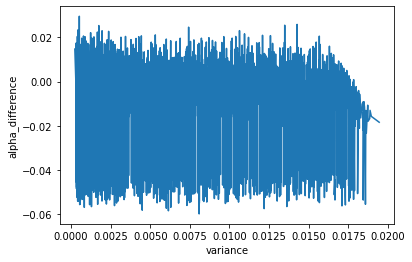

In [89]:
# plot recovered vs. actual parameter value difference against variance

sns.lineplot(data=rec_summary, x='variance', y='alpha_difference')

In [92]:
min(sim_variance)

0.00024375660497785614

<AxesSubplot:ylabel='Density'>

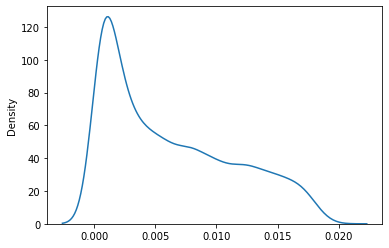

In [83]:
sns.kdeplot(sim_variance)

<AxesSubplot:>

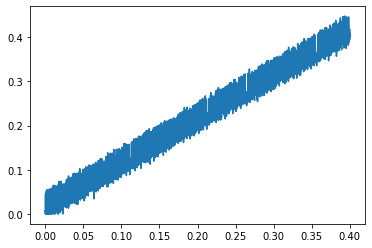

In [84]:
sns.lineplot(x=random_alpha, y=rec_alpha)

<AxesSubplot:>

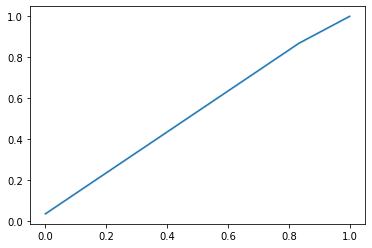

In [91]:
sns.lineplot(x=random_prior, y=rec_prior)

### Concatenate subject 1 and 2

In [85]:
sim_data = []

for params in rand_params:
    sim = [params[1] + params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [87]:
len(sim_data)

50

In [52]:
rec_alpha = []
rec_prior = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model, response=sim, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    rec_prior.append(gp_result.x[0]) # prior
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.9880466646192854
mean squared error 0.0005716156671482433
iteration 1
R2: 0.9924355986625949
mean squared error 0.0003585259538762519
iteration 2
R2: 0.9912895881229039
mean squared error 0.0004083816969952239
iteration 3
R2: 0.9910705130795433
mean squared error 0.00043617095175143054
iteration 4
R2: 0.9924753396879203
mean squared error 0.00035235696721723947
iteration 5
R2: 0.9888345652997204
mean squared error 0.0005371707095052511
iteration 6
R2: 0.9906782616383926
mean squared error 0.00043543493907676666
iteration 7
R2: 0.9922639338761089
mean squared error 0.00037230338737001604
iteration 8
R2: 0.991698067976407
mean squared error 0.0003946757307514114
iteration 9
R2: 0.9919423390449269
mean squared error 0.00038647120364708053
iteration 10
R2: 0.9510434075157777
mean squared error 0.0005471257317446528
iteration 11
R2: 0.9587168537668961
mean squared error 0.00041795024251845177
iteration 12
R2: 0.9635786442693167
mean squared error 0.00039432492437129895
ite

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at t

R2: 0.9825858142624936
mean squared error 0.0010712185353387467
iteration 21
R2: 0.9925528493719274
mean squared error 0.0004439501841366873
iteration 22
R2: 0.9932813631490018
mean squared error 0.00039259143571497053
iteration 23


C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at t

R2: 0.9850178462907786
mean squared error 0.0008965534472570731
iteration 24
R2: 0.9933925139722266
mean squared error 0.0003947390954088029
iteration 25


C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at t

R2: 0.9861416244326474
mean squared error 0.0008204066884027049
iteration 26
R2: 0.992947492922663
mean squared error 0.0004246005047849102
iteration 27
R2: 0.9933980220497295
mean squared error 0.00040732771867543505
iteration 28
R2: 0.9941296403250818
mean squared error 0.0003555747444407648
iteration 29
R2: 0.9925524580400825
mean squared error 0.00044245187603426136
iteration 30
R2: 0.9434190050786874
mean squared error 0.0005622427159528502
iteration 31
R2: 0.9548592778321033
mean squared error 0.00045851259722527504
iteration 32
R2: 0.955643911087612
mean squared error 0.00042428694469473423
iteration 33
R2: 0.9456225301664666
mean squared error 0.0005294743008397505
iteration 34
R2: 0.9472043845601702
mean squared error 0.0004947486636680421
iteration 35
R2: 0.9543906772689169
mean squared error 0.0004664866225260871
iteration 36
R2: 0.9607933313970167
mean squared error 0.000403906432869544
iteration 37
R2: 0.9613010758751137
mean squared error 0.000373564005545397
iteration 38

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


R2: 0.9890079489660667
mean squared error 0.0005701460099790139
iteration 71
R2: 0.9928413039471629
mean squared error 0.00038530934590189927
iteration 72
R2: 0.9919292969870015
mean squared error 0.0004155624555521338
iteration 73


C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


R2: 0.9867274747593432
mean squared error 0.0006746069021774257
iteration 74
R2: 0.9912675111582337
mean squared error 0.00046123183377194573
iteration 75


C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


R2: 0.9909279226114829
mean squared error 0.0004833524426959586
iteration 76
R2: 0.9931187986947676
mean squared error 0.00036777300471931517
iteration 77
R2: 0.9926630129857058
mean squared error 0.0003912593190183669
iteration 78
R2: 0.9928653842242404
mean squared error 0.00037036879712705473
iteration 79
R2: 0.9917628864428124
mean squared error 0.00043603691938833483
iteration 80
R2: 0.9677673503044232
mean squared error 0.0005666260506191341
iteration 81
R2: 0.9760864676438838
mean squared error 0.0004152124006709986
iteration 82
R2: 0.974310850958177
mean squared error 0.000435913162083506
iteration 83
R2: 0.9703030690242663
mean squared error 0.0005290130523899237
iteration 84
R2: 0.9790933867397065
mean squared error 0.00037365979811000135
iteration 85
R2: 0.9680682210038947
mean squared error 0.0005512760203628162
iteration 86
R2: 0.9794086790803439
mean squared error 0.0003559728804713845
iteration 87
R2: 0.9800622061050119
mean squared error 0.0003608426144368922
iteration 

<AxesSubplot:ylabel='Density'>

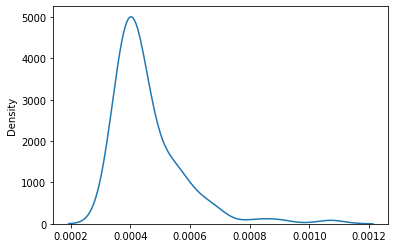

In [63]:
sns.kdeplot(data=rec_mse)

In [65]:
list(zip(rand_params, rec_alpha, rec_prior, rec_mse))

[((0.8669261709281284, 1), 0.9191783335185225, 1.0, 0.0005716156671482433),
 ((0.8669261709281284, 0.5),
  0.8680724548687246,
  0.5294621496996903,
  0.0003585259538762519),
 ((0.8669261709281284, 0),
  0.8633213777020511,
  0.04001741106035085,
  0.0004083816969952239),
 ((0.8669261709281284, 1), 0.9173809757889069, 1.0, 0.00043617095175143054),
 ((0.8669261709281284, 0.167),
  0.8669991748034834,
  0.20232023891287282,
  0.00035235696721723947),
 ((0.8669261709281284, 1), 0.9133521366807699, 1.0, 0.0005371707095052511),
 ((0.8669261709281284, 0.333),
  0.8613901400703106,
  0.3733230149241921,
  0.00043543493907676666),
 ((0.8669261709281284, 0.667),
  0.8754718290101741,
  0.695648345041298,
  0.00037230338737001604),
 ((0.8669261709281284, 0.5),
  0.8689747938916391,
  0.533166588379677,
  0.0003946757307514114),
 ((0.8669261709281284, 0),
  0.8725199122039012,
  0.03232212373375377,
  0.00038647120364708053),
 ((0.4059519446699531, 1), 0.45641584608616836, 1.0, 0.0005471257317446

### Concatenate subject 1 and 5

In [178]:
trials = tn.iloc[:,:5]

In [179]:
trials.reset_index(inplace=True)

In [180]:
n_card_per_trial = 7

trials['trial'] = trials.index + 1

trials['n_blue'] = n_card_per_trial - trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1,
                         trials['outcome'] - trials['outcome'] * (trials['n_red'] / n_card_per_trial), \
                         trials['outcome'] - trials['outcome'] * (
                                     n_card_per_trial - trials['n_red']) / n_card_per_trial)
trials['normed_signed_e_v'] = normalize(trials['e_v'])
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

trials['cs_signed_e_v'] = trials['e_v'].cumsum()
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

count_red = abs(trials.outcome[lambda x: x == -1].cumsum())
count_blue = abs(trials.outcome[lambda x: x == 1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

track_freq = [1] * len(trials)
for i, outcome in enumerate(trials['outcome'].values):
    if (i == 0):
        continue
    if (i > 0):
        if (outcome != trials['outcome'].values[i - 1]):
            continue
        if (outcome == trials['outcome'].values[i - 1]):
            track_freq[i] = track_freq[i - 1] + 1
trials['n_consec_colour'] = track_freq

trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']
normalized_signed_colour_count = normalize(trials['signed_n_consec_colour'].values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count
trials['normed_unsigned_colour_count'] = [(v / 5) for v in trials.n_consec_colour]

In [181]:
del trials['level_0']

In [182]:
del trials['index']

In [183]:
sim_data = []

for params in rand_params:
    sim = [params[1] + params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [184]:
rec_alpha = []
rec_prior = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model, response=sim, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    rec_prior.append(gp_result.x[0]) # prior
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.990864232618299
mean squared error 0.0004887756515809342
iteration 1
R2: 0.7804072989198672
mean squared error 0.0003974703092601874
iteration 2
R2: 0.9108465760978509
mean squared error 0.00039280519848156325
iteration 3
R2: 0.9717526009399734
mean squared error 0.0003775292097029096
iteration 4
R2: 0.9924335891174386
mean squared error 0.0004291119798847217
iteration 5
R2: 0.9937865432415475
mean squared error 0.00034985522750586424
iteration 6
R2: 0.9044885385987288
mean squared error 0.00041946436631782474
iteration 7
R2: 0.9712921427665462
mean squared error 0.0003858852857058516
iteration 8
R2: 0.8598025971575898
mean squared error 0.00034518511506558577
iteration 9
R2: 0.9658363738908722
mean squared error 0.0004210494054809045
iteration 10
R2: 0.5448607456590391
mean squared error 0.0004289671422886818
iteration 11
R2: 0.5874753277250566
mean squared error 0.00039903812327418025
iteration 12
R2: 0.9449822090415241
mean squared error 0.0004282138007965203
itera

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


R2: 0.9911570101148557
mean squared error 0.00048313916595116904
iteration 16
R2: 0.8254326683495169
mean squared error 0.00037568015080604683
iteration 17
R2: 0.9938605429003342
mean squared error 0.00034609448127216765
iteration 18
R2: 0.8486541249254254
mean squared error 0.000401231443362938
iteration 19
R2: 0.8404899568286734
mean squared error 0.00044292923848113496
iteration 20
R2: 0.993697357574411
mean squared error 0.00034751881069637586
iteration 21
R2: 0.9713513774715758
mean squared error 0.0003671470041819776
iteration 22
R2: 0.9653668880884009
mean squared error 0.0004142848866149766
iteration 23
R2: 0.9706604469630916
mean squared error 0.00035301597144580133
iteration 24
R2: 0.9712518047721627
mean squared error 0.0003833201260094323
iteration 25
R2: 0.5285112257071352
mean squared error 0.00035316067723264484
iteration 26
R2: 0.593906156117013
mean squared error 0.0003382979144252171
iteration 27
R2: 0.8996875776852705
mean squared error 0.0004258159631609734
iteratio

<AxesSubplot:ylabel='Density'>

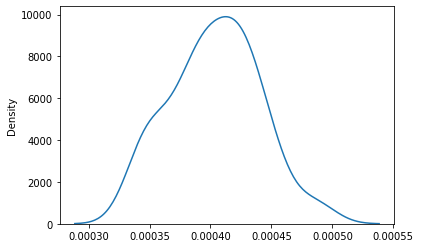

In [186]:
sns.kdeplot(data=rec_mse)

In [188]:
pd.DataFrame(list(zip(rand_params, rec_alpha, rec_prior, rec_mse)))

,0,1,2,3
0,"(0.8496250844380849, 0.667)",0.840157,0.707267,0.000489
1,"(0.14403800340738537, 0.667)",0.138247,0.705029,0.000397
2,"(0.2305031831484825, 0.167)",0.231573,0.201372,0.000393
3,"(0.4064771981140668, 0)",0.416072,0.028168,0.000378
4,"(0.8699166630984495, 0)",0.866310,0.037273,0.000429
5,"(0.8699166630984495, 0.5)",0.864697,0.536382,0.000350
6,"(0.2305031831484825, 0.667)",0.231021,0.698985,0.000419
7,"(0.4064771981140668, 0.5)",0.418151,0.531603,0.000386
8,"(0.16846119430056838, 0.333)",0.168433,0.368290,0.000345
9,"(0.3940728808702164, 0.333)",0.399304,0.363889,0.000421


### Concatenate subject 2 and 5

In [100]:
trials = tm.iloc[:,:5]

In [101]:
trials.reset_index(inplace=True)

In [102]:
n_card_per_trial = 7

trials['trial'] = trials.index + 1

trials['n_blue'] = n_card_per_trial - trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1,
                         trials['outcome'] - trials['outcome'] * (trials['n_red'] / n_card_per_trial), \
                         trials['outcome'] - trials['outcome'] * (
                                     n_card_per_trial - trials['n_red']) / n_card_per_trial)
trials['normed_signed_e_v'] = normalize(trials['e_v'])
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

trials['cs_signed_e_v'] = trials['e_v'].cumsum()
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

count_red = abs(trials.outcome[lambda x: x == -1].cumsum())
count_blue = abs(trials.outcome[lambda x: x == 1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

track_freq = [1] * len(trials)
for i, outcome in enumerate(trials['outcome'].values):
    if (i == 0):
        continue
    if (i > 0):
        if (outcome != trials['outcome'].values[i - 1]):
            continue
        if (outcome == trials['outcome'].values[i - 1]):
            track_freq[i] = track_freq[i - 1] + 1
trials['n_consec_colour'] = track_freq

trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']
normalized_signed_colour_count = normalize(trials['signed_n_consec_colour'].values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count
trials['normed_unsigned_colour_count'] = [(v / 5) for v in trials.n_consec_colour]

In [103]:
del trials['level_0']

In [104]:
del trials['index']

In [105]:
sim_data = []

for params in rand_params:
    sim = [params[1] + params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [106]:
rec_alpha = []
rec_prior = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model, response=sim, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    rec_prior.append(gp_result.x[0]) # prior
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.9897046495774383
mean squared error 0.00043205682515526806
iteration 1
R2: 0.6991125750958727
mean squared error 0.00044153558141431633
iteration 2
R2: 0.8917707093642676
mean squared error 0.0003570485062629022
iteration 3
R2: 0.9560065508624779
mean squared error 0.00044601038710923187
iteration 4
R2: 0.9917615783805965
mean squared error 0.000370696165846008
iteration 5
R2: 0.9923328097063728
mean squared error 0.0003328986936453813
iteration 6
R2: 0.8749776251355932
mean squared error 0.00042688130252148437
iteration 7
R2: 0.9595635583074843
mean squared error 0.0003896878899008907
iteration 8
R2: 0.7656598995919736
mean squared error 0.00048036920047054595
iteration 9
R2: 0.954949935506181
mean squared error 0.0003887804772246949
iteration 10
R2: 0.49373416268779513
mean squared error 0.0004103171419017019
iteration 11
R2: 0.4820904439006386
mean squared error 0.0003939321078653867
iteration 12
R2: 0.9373836672406908
mean squared error 0.00037507772339798174
iter

R2: 0.9341168132574444
mean squared error 0.0003792363272461486
iteration 47
R2: 0.9229277253160331
mean squared error 0.00047527748562687804
iteration 48
R2: 0.9897885565790587
mean squared error 0.000420613929378388
iteration 49
R2: 0.7718237654658167
mean squared error 0.00033453934592384433


In [110]:
pd.DataFrame(list(zip(rand_params, rec_alpha, rec_prior, rec_mse)))

,0,1,2,3
0,"(0.8496250844380849, 0.667)",0.853453,0.701287,0.000432
1,"(0.14403800340738537, 0.667)",0.134640,0.706177,0.000442
2,"(0.2305031831484825, 0.167)",0.225448,0.204123,0.000357
3,"(0.4064771981140668, 0)",0.409818,0.032984,0.000446
4,"(0.8699166630984495, 0)",0.881988,0.026556,0.000371
5,"(0.8699166630984495, 0.5)",0.867603,0.537579,0.000333
6,"(0.2305031831484825, 0.667)",0.228583,0.705438,0.000427
7,"(0.4064771981140668, 0.5)",0.401770,0.539334,0.000390
8,"(0.16846119430056838, 0.333)",0.165034,0.369930,0.000480
9,"(0.3940728808702164, 0.333)",0.378869,0.377955,0.000389


## Without prior parameter

In [107]:
def objective_single_model_np(params, response, trials, stat: str):
    ss_tot = np.sum((response-np.mean(response))**2)
    pred = params[1] * trials[stat]
    return np.sum((response-pred)**2)

### Concatenated subjects 1 and 2

In [168]:
trials = tm.iloc[:,:5]

In [169]:
trials.reset_index(inplace=True)

In [170]:
n_card_per_trial = 7

trials['trial'] = trials.index + 1

trials['n_blue'] = n_card_per_trial - trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1,
                         trials['outcome'] - trials['outcome'] * (trials['n_red'] / n_card_per_trial), \
                         trials['outcome'] - trials['outcome'] * (
                                     n_card_per_trial - trials['n_red']) / n_card_per_trial)
trials['normed_signed_e_v'] = normalize(trials['e_v'])
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

trials['cs_signed_e_v'] = trials['e_v'].cumsum()
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

count_red = abs(trials.outcome[lambda x: x == -1].cumsum())
count_blue = abs(trials.outcome[lambda x: x == 1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

track_freq = [1] * len(trials)
for i, outcome in enumerate(trials['outcome'].values):
    if (i == 0):
        continue
    if (i > 0):
        if (outcome != trials['outcome'].values[i - 1]):
            continue
        if (outcome == trials['outcome'].values[i - 1]):
            track_freq[i] = track_freq[i - 1] + 1
trials['n_consec_colour'] = track_freq

trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']
normalized_signed_colour_count = normalize(trials['signed_n_consec_colour'].values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count
trials['normed_unsigned_colour_count'] = [(v / 5) for v in trials.n_consec_colour]

In [171]:
del trials['level_0']

In [172]:
del trials['index']

In [173]:
sim_data = []

for params in rand_params:
    sim = [params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [174]:
rec_alpha = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model_np, response=sim, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.9847273669629166
mean squared error 0.000637140148530282
iteration 1
R2: 0.6495507736385187
mean squared error 0.0005347681883692759
iteration 2
R2: 0.832354723090361
mean squared error 0.0006095073381102732
iteration 3
R2: 0.9401964219257358
mean squared error 0.0006015617687665152
iteration 4
R2: 0.9857871670373558
mean squared error 0.000624319261103606
iteration 5
R2: 0.983911308956105
mean squared error 0.0006799230600029978
iteration 6
R2: 0.8292127918501182
mean squared error 0.0005938488946300356
iteration 7
R2: 0.9223793801295539
mean squared error 0.0007329671713880235
iteration 8
R2: 0.7453178656106378
mean squared error 0.0005605957442249399
iteration 9
R2: 0.9356015419102168
mean squared error 0.0006137768683189593
iteration 10
R2: 0.09480160137105631
mean squared error 0.00062477996386433
iteration 11
R2: 0.27198414716600117
mean squared error 0.0005392703925327365
iteration 12
R2: 0.8871562923575401
mean squared error 0.0006632343056593356
iteration 13


R2: 0.9036653752592454
mean squared error 0.0005998379597487418
iteration 48
R2: 0.9850121067756438
mean squared error 0.0006270233888931581
iteration 49
R2: 0.6214155780994515
mean squared error 0.0006121333886064585


<AxesSubplot:ylabel='Density'>

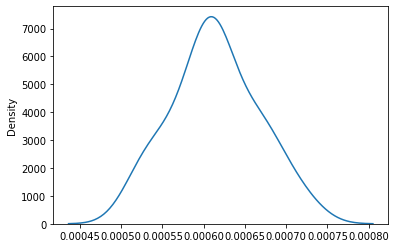

In [175]:
sns.kdeplot(data=rec_mse)

In [176]:
a = [v[0] for v in rand_params]

np.subtract(a, rec_alpha)

array([-0.05766584, -0.04964491, -0.05303841, -0.05918678, -0.05268738,
       -0.0512741 , -0.05788391, -0.05590786, -0.05212756, -0.05592213,
       -0.05532247, -0.04913312, -0.05626629, -0.05523616, -0.05309611,
       -0.05901891, -0.05263021, -0.0566451 , -0.05018863, -0.05928971,
       -0.05382684, -0.05673643, -0.06169079, -0.05312252, -0.04909593,
       -0.05993847, -0.05522761, -0.0558727 , -0.05691429, -0.05578077,
       -0.05357552, -0.05590126, -0.05457764, -0.05527481, -0.05814344,
       -0.05442944, -0.05864294, -0.05744662, -0.05380561, -0.05557865,
       -0.05703046, -0.05459466, -0.05777116, -0.05389664, -0.05910342,
       -0.05550238, -0.05559075, -0.05404217, -0.05633808, -0.05470774])

In [177]:
list(zip(a, rec_alpha))

[(0.8496250844380849, 0.9072909266089495),
 (0.14403800340738537, 0.1936829103808781),
 (0.2305031831484825, 0.2835415883787883),
 (0.4064771981140668, 0.465663982693167),
 (0.8699166630984495, 0.9226040463477531),
 (0.8699166630984495, 0.9211907619945531),
 (0.2305031831484825, 0.28838708981720856),
 (0.4064771981140668, 0.4623850560875963),
 (0.16846119430056838, 0.22058874965869535),
 (0.3940728808702164, 0.44999500867421727),
 (0.0830781767066765, 0.13840064490223739),
 (0.0830781767066765, 0.13221130063541733),
 (0.31389201654897236, 0.37015830435786046),
 (0.31389201654897236, 0.3691281778795153),
 (0.6154778798327065, 0.6685739850305943),
 (0.8496250844380849, 0.9086439949761085),
 (0.14403800340738537, 0.19666820936465668),
 (0.8699166630984495, 0.9265617639072962),
 (0.16846119430056838, 0.21864982687452555),
 (0.16846119430056838, 0.2277509054555253),
 (0.8699166630984495, 0.9237434998450438),
 (0.4064771981140668, 0.4632136280599236),
 (0.3940728808702164, 0.4557636722659786

### Concatenated subjects 2 and 5

In [125]:
trials = tn.iloc[:,:5]

In [126]:
trials.reset_index(inplace=True)

In [127]:
n_card_per_trial = 7

trials['trial'] = trials.index + 1

trials['n_blue'] = n_card_per_trial - trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1,
                         trials['outcome'] - trials['outcome'] * (trials['n_red'] / n_card_per_trial), \
                         trials['outcome'] - trials['outcome'] * (
                                     n_card_per_trial - trials['n_red']) / n_card_per_trial)
trials['normed_signed_e_v'] = normalize(trials['e_v'])
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

trials['cs_signed_e_v'] = trials['e_v'].cumsum()
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

count_red = abs(trials.outcome[lambda x: x == -1].cumsum())
count_blue = abs(trials.outcome[lambda x: x == 1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

track_freq = [1] * len(trials)
for i, outcome in enumerate(trials['outcome'].values):
    if (i == 0):
        continue
    if (i > 0):
        if (outcome != trials['outcome'].values[i - 1]):
            continue
        if (outcome == trials['outcome'].values[i - 1]):
            track_freq[i] = track_freq[i - 1] + 1
trials['n_consec_colour'] = track_freq

trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']
normalized_signed_colour_count = normalize(trials['signed_n_consec_colour'].values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count
trials['normed_unsigned_colour_count'] = [(v / 5) for v in trials.n_consec_colour]

In [128]:
del trials['level_0']

In [129]:
del trials['index']

In [130]:
sim_data = []

for params in rand_params:
    sim = [params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [132]:
rec_alpha = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model_np, response=sim, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.9910433703266648
mean squared error 0.0005037370729621917
iteration 1
R2: 0.6785388946896156
mean squared error 0.0006323335184271732
iteration 2
R2: 0.8327719070432438
mean squared error 0.00066104148846215
iteration 3
R2: 0.9487531314793822
mean squared error 0.0006546766737279252
iteration 4
R2: 0.9900348339328067
mean squared error 0.0005765869535982065
iteration 5
R2: 0.990523055350161
mean squared error 0.0005417907866164374
iteration 6
R2: 0.8564709712139301
mean squared error 0.0006375382316201446
iteration 7
R2: 0.9568606728482695
mean squared error 0.0005512163552016273
iteration 8
R2: 0.7156872670981673
mean squared error 0.0006652996434270352
iteration 9
R2: 0.9614485115024161
mean squared error 0.0004900922826151748
iteration 10
R2: 0.2827254949826705
mean squared error 0.0006445105825167419
iteration 11
R2: 0.34474346047796933
mean squared error 0.000626979885754164
iteration 12
R2: 0.9285409545417231
mean squared error 0.0005547504522045155
iteration 13

R2: 0.9170951913081583
mean squared error 0.0006208177679055302
iteration 48
R2: 0.9887403868964727
mean squared error 0.0006138753990109496
iteration 49
R2: 0.6510368207262376
mean squared error 0.0006655840689947036


<AxesSubplot:ylabel='Density'>

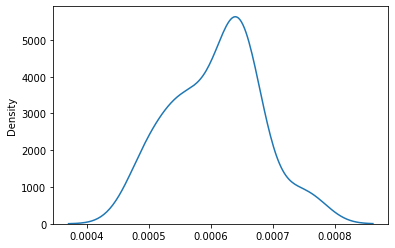

In [133]:
sns.kdeplot(data=rec_mse)

In [134]:
a = [v[0] for v in rand_params]

np.subtract(a, rec_alpha)

array([-0.0474199 , -0.04877616, -0.04441696, -0.04611495, -0.0460831 ,
       -0.04454571, -0.05139413, -0.04256661, -0.05308002, -0.05004427,
       -0.04752466, -0.04935565, -0.04556643, -0.04980591, -0.04723266,
       -0.04606527, -0.04605608, -0.04064312, -0.049986  , -0.04433233,
       -0.04546348, -0.04465231, -0.04548892, -0.0449191 , -0.04801489,
       -0.04913364, -0.04619776, -0.0478585 , -0.04582457, -0.04908557,
       -0.04449938, -0.04483858, -0.04877706, -0.04264817, -0.04971697,
       -0.04923409, -0.04665731, -0.04549492, -0.04410089, -0.04855379,
       -0.04782147, -0.05088968, -0.05001098, -0.04767961, -0.04508947,
       -0.0489407 , -0.04446776, -0.04374425, -0.04797404, -0.05160138])

### Concatenated subject 2 and 5

In [111]:
sim_data = []

for params in rand_params:
    sim = [params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_e_v'].values]
    sim_data.append(sim)

In [117]:
rec_alpha = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model_np, response=sim, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[1] * trials['normed_signed_e_v']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.9870671219439878
mean squared error 0.0005555062206778782
iteration 1
R2: 0.6609651355392099
mean squared error 0.0005619312086037928
iteration 2
R2: 0.8342660549363108
mean squared error 0.0005764271037665948
iteration 3
R2: 0.937202895636501
mean squared error 0.0006053207576015479
iteration 4
R2: 0.9863233306913737
mean squared error 0.0006007724831611408
iteration 5
R2: 0.9864521922807965
mean squared error 0.0005957111517784334
iteration 6
R2: 0.8474011228308955
mean squared error 0.0005614141428839557
iteration 7
R2: 0.9310494193571714
mean squared error 0.0006690973456235392
iteration 8
R2: 0.7960756650698485
mean squared error 0.0004799926583651186
iteration 9
R2: 0.9338157018433475
mean squared error 0.0006037460099152683
iteration 10
R2: 0.0813961159092117
mean squared error 0.0006375122065616597
iteration 11
R2: 0.053265986379935626
mean squared error 0.0007538025402997526
iteration 12
R2: 0.9112163575757667
mean squared error 0.0005567885233260481
iteratio

R2: 0.8959995793532337
mean squared error 0.0006478508117718685
iteration 48
R2: 0.9834816802530963
mean squared error 0.0006846278108785054
iteration 49
R2: 0.5260649748396085
mean squared error 0.0006229470432906996


<AxesSubplot:ylabel='Density'>

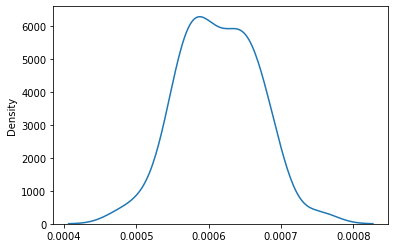

In [119]:
sns.kdeplot(data=rec_mse)

In [124]:
a = [v[0] for v in rand_params]

np.subtract(a, rec_alpha)

array([-0.0553889 , -0.05467432, -0.05064929, -0.05127841, -0.0570801 ,
       -0.05397713, -0.05727772, -0.05538129, -0.06082664, -0.05440446,
       -0.05298329, -0.0572149 , -0.0553396 , -0.0588047 , -0.0538614 ,
       -0.05419116, -0.0582231 , -0.06028037, -0.05187367, -0.05720828,
       -0.05706862, -0.0561792 , -0.05736933, -0.06218767, -0.05514713,
       -0.05472403, -0.05416052, -0.05556663, -0.05366826, -0.04889257,
       -0.05986695, -0.05785347, -0.05851416, -0.05862778, -0.05247441,
       -0.05903067, -0.05551027, -0.05521627, -0.0517304 , -0.05330982,
       -0.05806458, -0.04800338, -0.05165473, -0.05879708, -0.05852451,
       -0.05777537, -0.05855945, -0.05622807, -0.05587418, -0.05156906])

### try with signed colours tracker model

In [146]:
sim_data = []

for params in rand_params:
    sim = [params[0] * ev + random.uniform(0, noise) for ev in trials['normed_signed_colour_count'].values]
    sim_data.append(sim)

In [147]:
rec_alpha = []
rec_mse = []

for i, sim in enumerate(sim_data):
    ss_tot =  np.sum((sim-np.mean(sim))**2)
    print("iteration", i)
    gp_result = gp_minimize(partial(objective_single_model_np, response=sim, trials=trials, stat='normed_signed_colour_count'), param_search_space, random_state=42)
    rec_alpha.append(gp_result.x[1]) # alpha
    
    optimal_ss_res = gp_result.fun
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    
    pred = gp_result.x[1] * trials['normed_signed_colour_count']
    mse = mean_squared_error(sim, pred)
    rec_mse.append(mse)
    print("mean squared error", mse)
    print("=" * 100)

iteration 0
R2: 0.9803526506594057
mean squared error 0.0006168990179305312
iteration 1
R2: 0.5952441525605046
mean squared error 0.0006020038463723919
iteration 2
R2: 0.7386545179401234
mean squared error 0.0006558942673239904
iteration 3
R2: 0.9126198544950981
mean squared error 0.0006267198136164448
iteration 4
R2: 0.9844538238947252
mean squared error 0.000522952342006197
iteration 5
R2: 0.9789524052115572
mean squared error 0.0006737085878297684
iteration 6
R2: 0.8270829194969475
mean squared error 0.0005227594473833567
iteration 7
R2: 0.9294087207655461
mean squared error 0.0005285231146762466
iteration 8
R2: 0.6366673540963182
mean squared error 0.0005961442189734916
iteration 9
R2: 0.9083768422135408
mean squared error 0.0006546986292356488
iteration 10
R2: 0.12952733609417355
mean squared error 0.0006753312801470612
iteration 11
R2: -0.01105398994538409
mean squared error 0.0007140184820899893
iteration 12
R2: 0.8592289804575961
mean squared error 0.0006155106892334218
iterati

R2: 0.8602393789079833
mean squared error 0.0005989487727581672
iteration 48
R2: 0.982127592983676
mean squared error 0.0005691603967796617
iteration 49
R2: 0.6008405986041954
mean squared error 0.0005510844258848443


<AxesSubplot:ylabel='Density'>

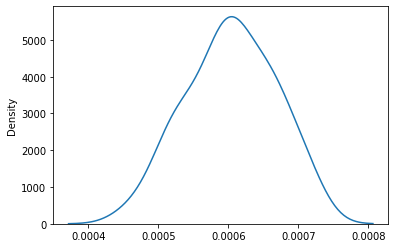

In [148]:
sns.kdeplot(data=rec_mse)

In [149]:
a = [v[0] for v in rand_params]

np.subtract(a, rec_alpha)

array([-0.06256547, -0.06841811, -0.06050394, -0.06636135, -0.06864612,
       -0.06372512, -0.07161896, -0.0644967 , -0.07061921, -0.06671737,
       -0.0729906 , -0.07007334, -0.06871565, -0.06476235, -0.06473651,
       -0.05985423, -0.06065093, -0.06530974, -0.06238119, -0.06034612,
       -0.06432642, -0.06432413, -0.0683763 , -0.06428846, -0.06404485,
       -0.06795462, -0.06411183, -0.06631838, -0.06017222, -0.06375332,
       -0.06516499, -0.05863434, -0.06289366, -0.06356932, -0.0642058 ,
       -0.06990149, -0.05833495, -0.06537324, -0.07021441, -0.06839465,
       -0.06608803, -0.06236626, -0.07174106, -0.06690197, -0.06210602,
       -0.06380113, -0.06306809, -0.05702027, -0.06586347, -0.0664407 ])

In [153]:
list(zip(trials['normed_signed_colour_count'].values, sim_data[0]))

[(0.36363636363636365, 0.31423907275286234),
 (0.2727272727272727, 0.23668459459585253),
 (0.5454545454545454, 0.48257985350402205),
 (0.6363636363636364, 0.6071687791903493),
 (0.7272727272727273, 0.6832307965605775),
 (0.8181818181818182, 0.7649506765074782),
 (0.9090909090909091, 0.791773155526388),
 (1.0, 0.8761354444305623),
 (0.36363636363636365, 0.3274264408117135),
 (0.2727272727272727, 0.28111390348813725),
 (0.18181818181818182, 0.15994323681271558),
 (0.09090909090909091, 0.1464991477414923),
 (0.5454545454545454, 0.5281809643339078),
 (0.36363636363636365, 0.3520577292365482),
 (0.2727272727272727, 0.28320042836479176),
 (0.5454545454545454, 0.5218645578411989),
 (0.36363636363636365, 0.31584731496972174),
 (0.2727272727272727, 0.2855336639461908),
 (0.5454545454545454, 0.4965207895273057),
 (0.6363636363636364, 0.5949655586829496),
 (0.36363636363636365, 0.31033044734944704),
 (0.2727272727272727, 0.29992647982910114),
 (0.18181818181818182, 0.1592457562553438),
 (0.545454